# Project Overview: Real Estate Price Regression Model

## Introduction
This Jupyter Notebook presents a project focused on building a regression model for predicting real estate prices. The goal is to develop a reliable model that can accurately estimate the price of a property based on various attributes. The dataset used in this project contains information about different real estate properties, including their prices, characteristics, and locations.

## Dataset Description
The dataset consists of the following columns:

1. ID: Unique identifier for each property.
2. Categoria: Category of the property.
3. Tipo: Type of the property (e.g., house, apartment, etc.).
4. Preco: Price of the property.
5. Bairro: Neighborhood where the property is located.
6. Condominio: Condominium cost (if applicable).
7. IPTU: Property tax value (if applicable).
8. Quartos: Number of bedrooms in the property.
9. Banheiros: Number of bathrooms in the property.
10. Vagas_carro: Number of parking spaces available for cars.
11. Tamanho: Size or area of the property.

The dataset contains 30,991 entries. However, some columns have missing values, including "Bairro," "Condominio," "IPTU," "Quartos," "Banheiros," "Vagas_carro," and "Tamanho."

## Translation of Values (English)
Here is a table that provides translations of the column names from Portuguese to English:

| Portuguese    | English         |
|---------------|-----------------|
| ID            | ID              |
| Categoria     | Category        |
| Tipo          | Type            |
| Preco         | Price           |
| Bairro        | Neighborhood    |
| Condominio    | Condominium     |
| IPTU          | Property Tax    |
| Quartos       | Bedrooms        |
| Banheiros     | Bathrooms       |
| Vagas_carro   | Car Spaces      |
| Tamanho       | Size/Area       |

The translation table above will help in better understanding the column names, especially for those who are more familiar with English.


In [2]:
import pandas as pd
import scipy.stats as stats
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from unidecode import unidecode
import re
import json
import networkx as nx
import joblib

In [3]:
df = pd.read_csv('scraping.csv')

# Data preprocessing

In [4]:
df.head()

Unnamed: 0.1  Unnamed: 0          ID    Categoria         Tipo   Preco  \
0             0           0  2630291775  residencial  Apartamento  2200.0   
1             1           1  2632654333  residencial  Apartamento  1750.0   
2             2           2  2632657266  residencial  Apartamento  2200.0   
3             3           3  2632656214  residencial  Apartamento  2495.0   
4             4           4  2632656214  residencial  Apartamento  2495.0   

             Bairro        Cidade  Condominio   IPTU  Quartos  Banheiros  \
0          Bom Fim   Porto Alegre       450.0  115.0      2.0        1.0   
1        Petrópolis  Porto Alegre       300.0   80.0      2.0        1.0   
2     Passo D areia  Porto Alegre       200.0  100.0      2.0        1.0   
3  Moinhos de Vento  Porto Alegre       360.0   81.0      3.0        2.0   
4  Moinhos de Vento  Porto Alegre       360.0   81.0      3.0        2.0   

   Vagas_carro  Tamanho        Data  \
0          NaN     71.0  2023-05-22   
1          NaN     35.0  2023-05-22   
2          NaN     50.0  2023-05-22   
3          NaN    110.0  2023-05-22   
4          NaN    110.0  2023-05-22   

                                                json  \
0                                       {"Tags": []}   
1                                       {"Tags": []}   
2  {"Tags": ["Aceita animais", "Churrasqueira", "...   
3  {"Tags": ["Ar-condicionado", "Mobiliado", "Var...   
4  {"Tags": ["Ar-condicionado", "Mobiliado", "Var...   

                  Tempo_Data_Coleta  
0  2023-05-22 19:08:05.738982+00:00  
1  2023-05-22 17:28:25.132844+00:00  
2  2023-05-22 18:47:52.035227+00:00  
3  2023-05-22 18:47:52.039121+00:00  
4  2023-05-22 18:53:05.554166+00:00

In [5]:
df['Data'] = pd.to_datetime(df['Data'])
df['Tempo_Data_Coleta'] = pd.to_datetime(df['Tempo_Data_Coleta'])
df['ID'] = df['ID'].astype(str)

In [6]:
df['Tipo'] = df['Tipo'].str.replace('/','_')
df['Tipo'] = df['Tipo'].str.replace(' ','_')

In [7]:
df.replace('', np.nan, inplace=True)

In [8]:
df.replace(' ', np.nan, inplace=True)

In [9]:
df.duplicated(subset=['ID']).sum()

10936

There are repeated IDs, we will remove them based on the most recent collection date

In [10]:
df = df.groupby('ID').apply(lambda x: x.loc[x['Tempo_Data_Coleta'].idxmax()]).reset_index(drop=True)

In [11]:
df.drop(['Tempo_Data_Coleta'], axis=1, inplace=True)

In [12]:
df.duplicated(subset=['ID']).sum()

0

We will also remove the Unnamed column

In [13]:
df.drop(labels=['Unnamed: 0'], inplace=True, axis=1)

In [14]:
df.drop(labels=['Unnamed: 0.1'], inplace=True, axis=1)

The tags column represent a json with amenities or tags that the real state has, lets create a new dataframe and add those columns

In [15]:
df['json'] = df['json'].apply(json.loads)

In [16]:
amenities_df = pd.DataFrame()
amenities_df['DUMMY'] = 0

for index, row in df.iterrows():
    tags_dict = row['json']
    tags_list = tags_dict['Tags']
    
    if len(tags_list) == 0:
        # Add a row with all columns set to 0
        amenities_df.loc[index] = 0
    else:
        for tag_value in tags_list:
            modified_tag_value = re.sub(r'\s+', '_', unidecode(tag_value))
            column_name = 'has_' + modified_tag_value

            if column_name not in amenities_df.columns:
                amenities_df[column_name] = 0

            amenities_df.at[index, column_name] = 1
amenities_df.drop(['DUMMY'], axis=1, inplace=True)

/tmp/ipykernel_867752/1067890261.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  amenities_df[column_name] = 0
/tmp/ipykernel_867752/1067890261.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  amenities_df[column_name] = 0
/tmp/ipykernel_867752/1067890261.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

In [17]:
amenities_df.fillna(0, inplace=True)

In [18]:
df.drop(['json','Data', 'Cidade'], axis=1, inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30991 entries, 0 to 30990
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           30991 non-null  object 
 1   Categoria    30991 non-null  object 
 2   Tipo         30991 non-null  object 
 3   Preco        30991 non-null  float64
 4   Bairro       30983 non-null  object 
 5   Condominio   28271 non-null  float64
 6   IPTU         25435 non-null  float64
 7   Quartos      13871 non-null  float64
 8   Banheiros    27366 non-null  float64
 9   Vagas_carro  14335 non-null  float64
 10  Tamanho      30968 non-null  float64
dtypes: float64(7), object(4)
memory usage: 2.6+ MB


In [20]:
amenities_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30991 entries, 0 to 30990
Columns: 179 entries, has_Elevador to has_Garage_band
dtypes: float64(179)
memory usage: 42.6 MB


Applying a regex for the "Bairro" column

In [21]:
df['Bairro'] = df['Bairro'].str.strip()

In [22]:
DATAFRAME_VAR = {
    'categorical' : ['ID', 'Categoria', 'Tipo', 'Bairro'],
    'continuous' : ['Condominio', 'IPTU', 'Preco', 'Tamanho'],
    'discrete' : ['Quartos', 'Banheiros', 'Vagas_carro'],
}

# Exploratory Data Analysis

## Analyzing Null Data

In [23]:
df[df['Categoria'] == 'comercial'].isnull().sum()

ID                 0
Categoria          0
Tipo               0
Preco              0
Bairro             5
Condominio      2139
IPTU            3730
Quartos        16605
Banheiros       3354
Vagas_carro    11661
Tamanho           14
dtype: int64

In [24]:
df[df['Categoria'] == 'residencial'].isnull().sum()

ID                0
Categoria         0
Tipo              0
Preco             0
Bairro            3
Condominio      581
IPTU           1826
Quartos         515
Banheiros       271
Vagas_carro    4995
Tamanho           9
dtype: int64

<Axes: >

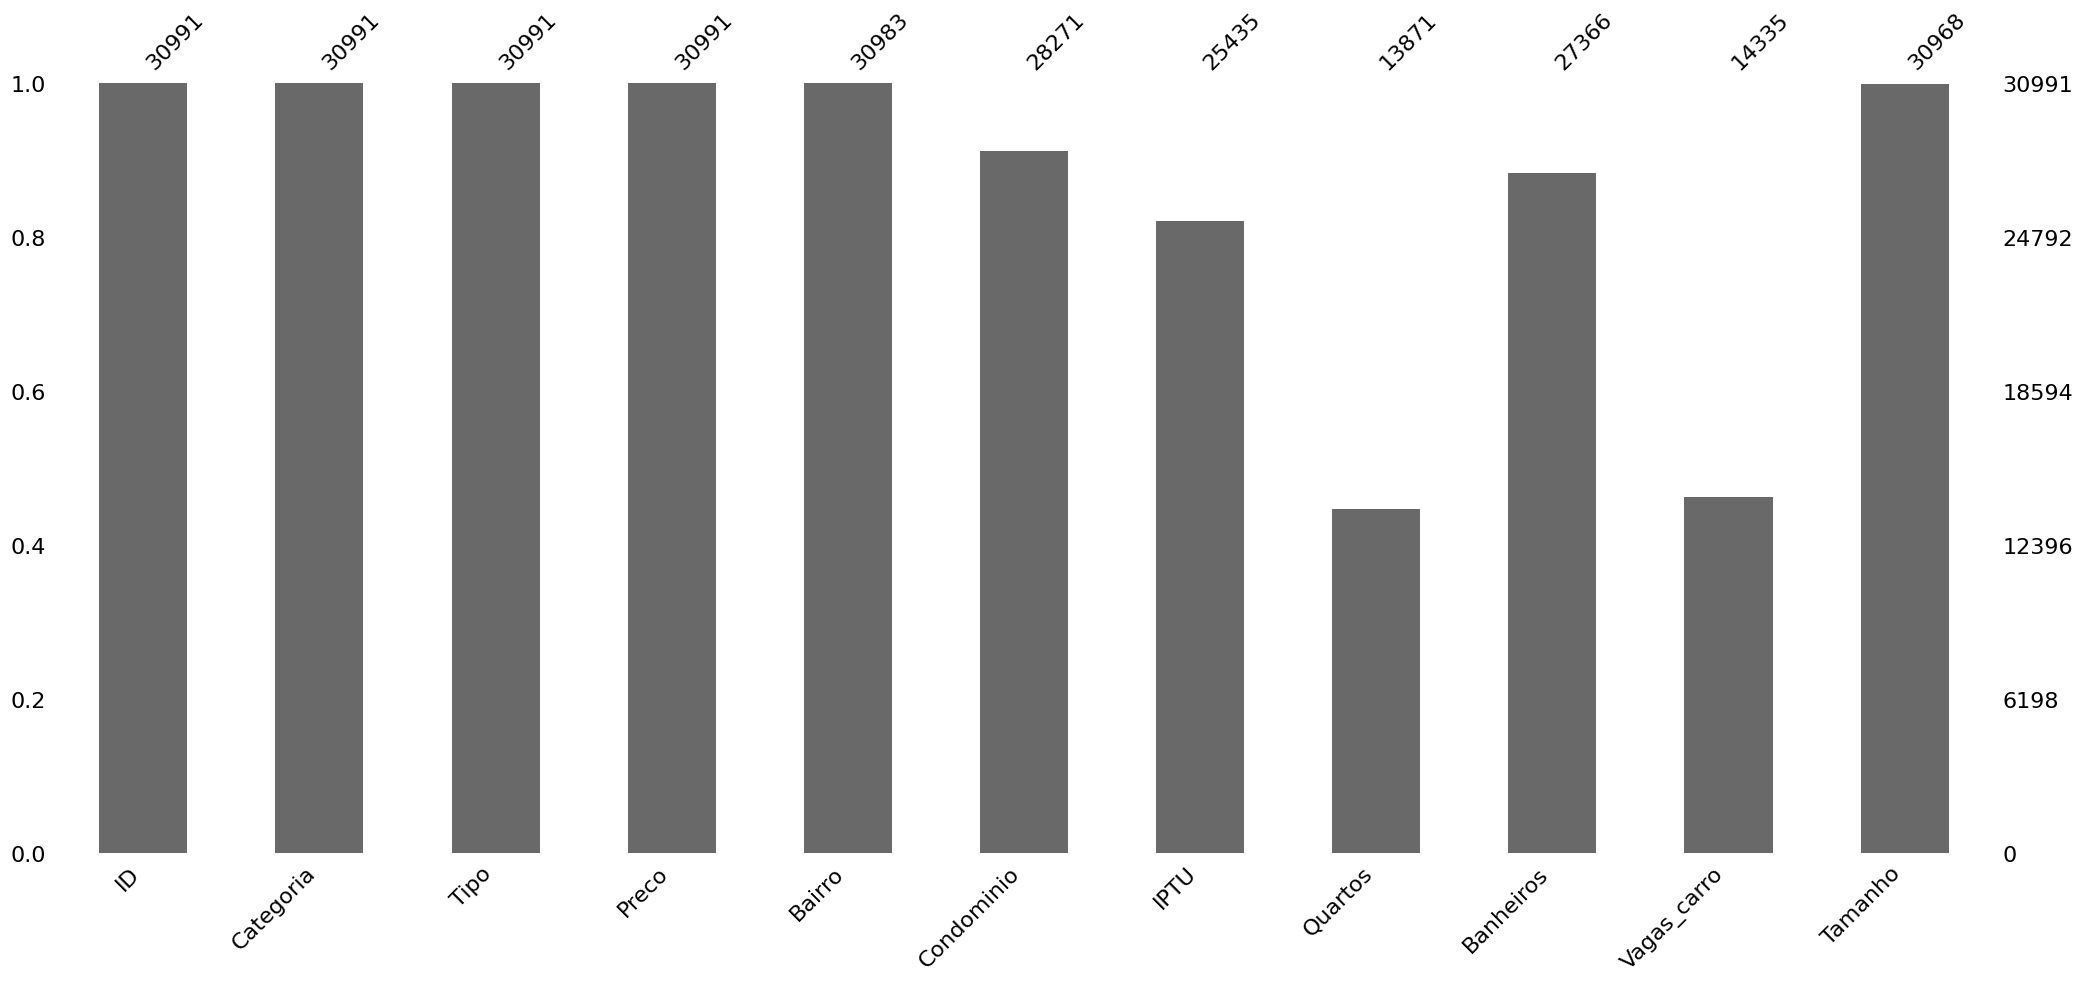

In [25]:
msno.bar(df)

<Axes: >

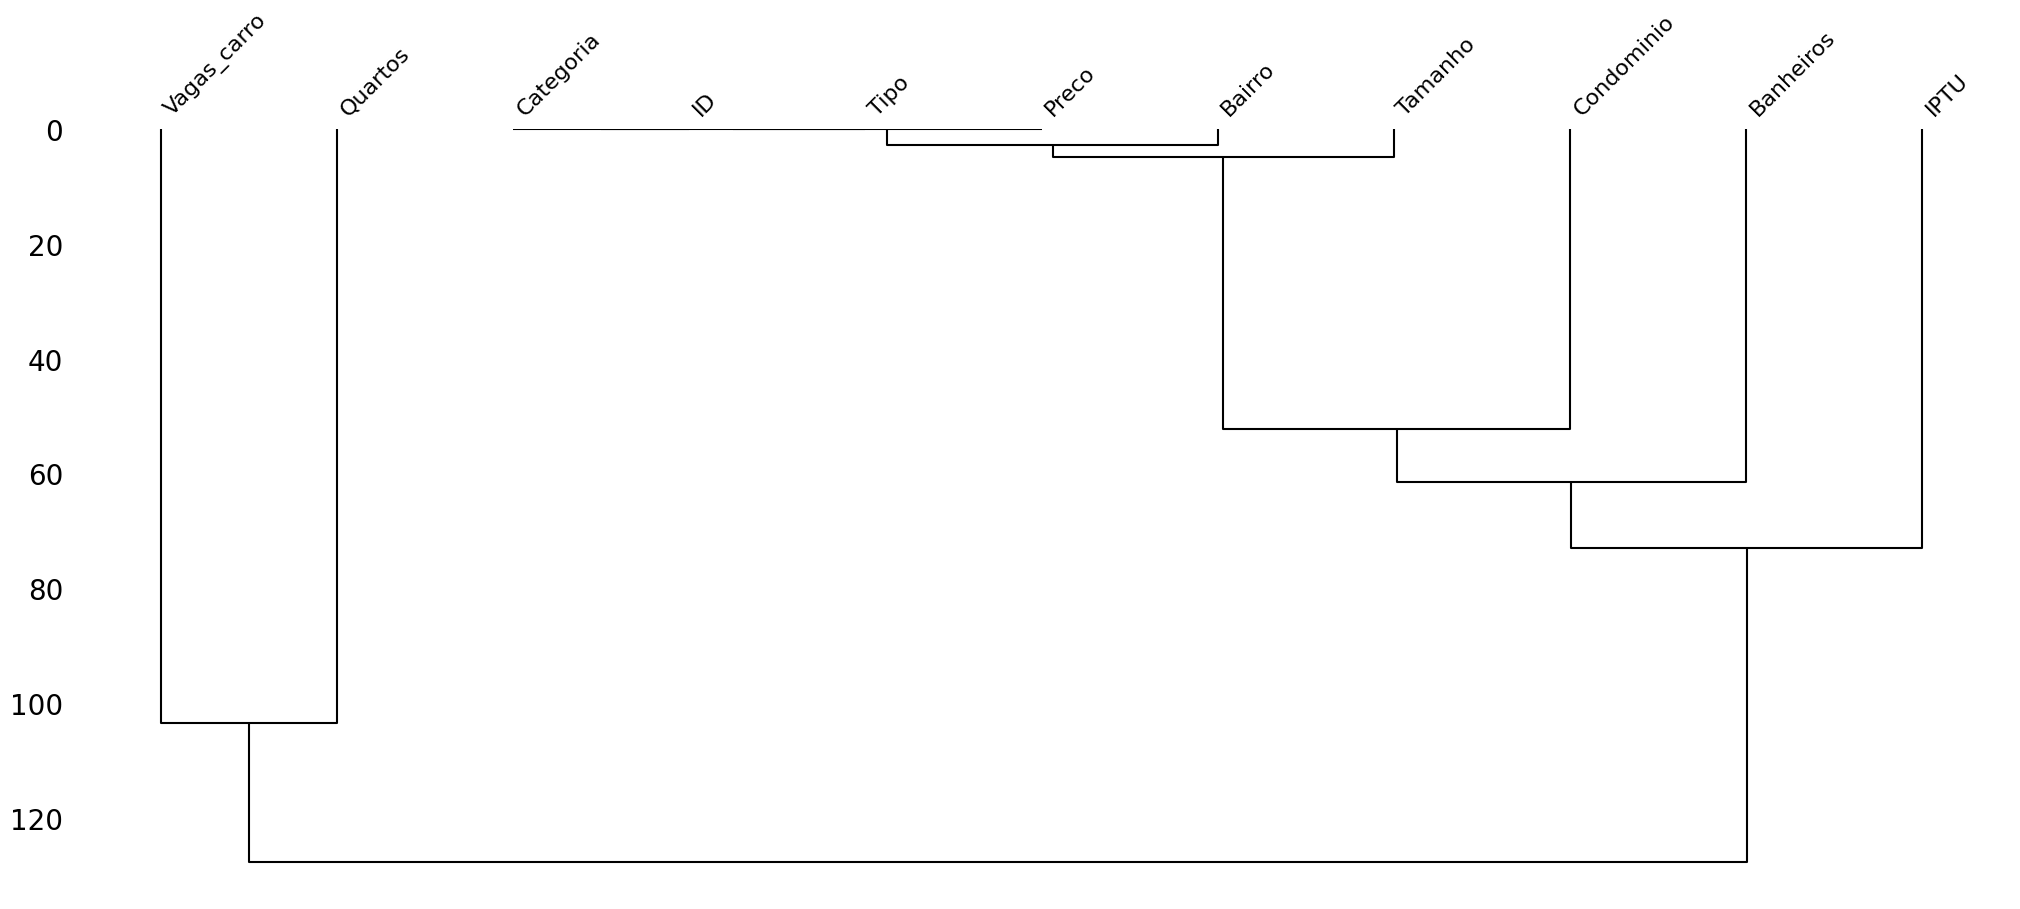

In [26]:
msno.dendrogram(df)

From the dendogram it is possible to see that we have a first level cluster in some columns, we will analyze it.

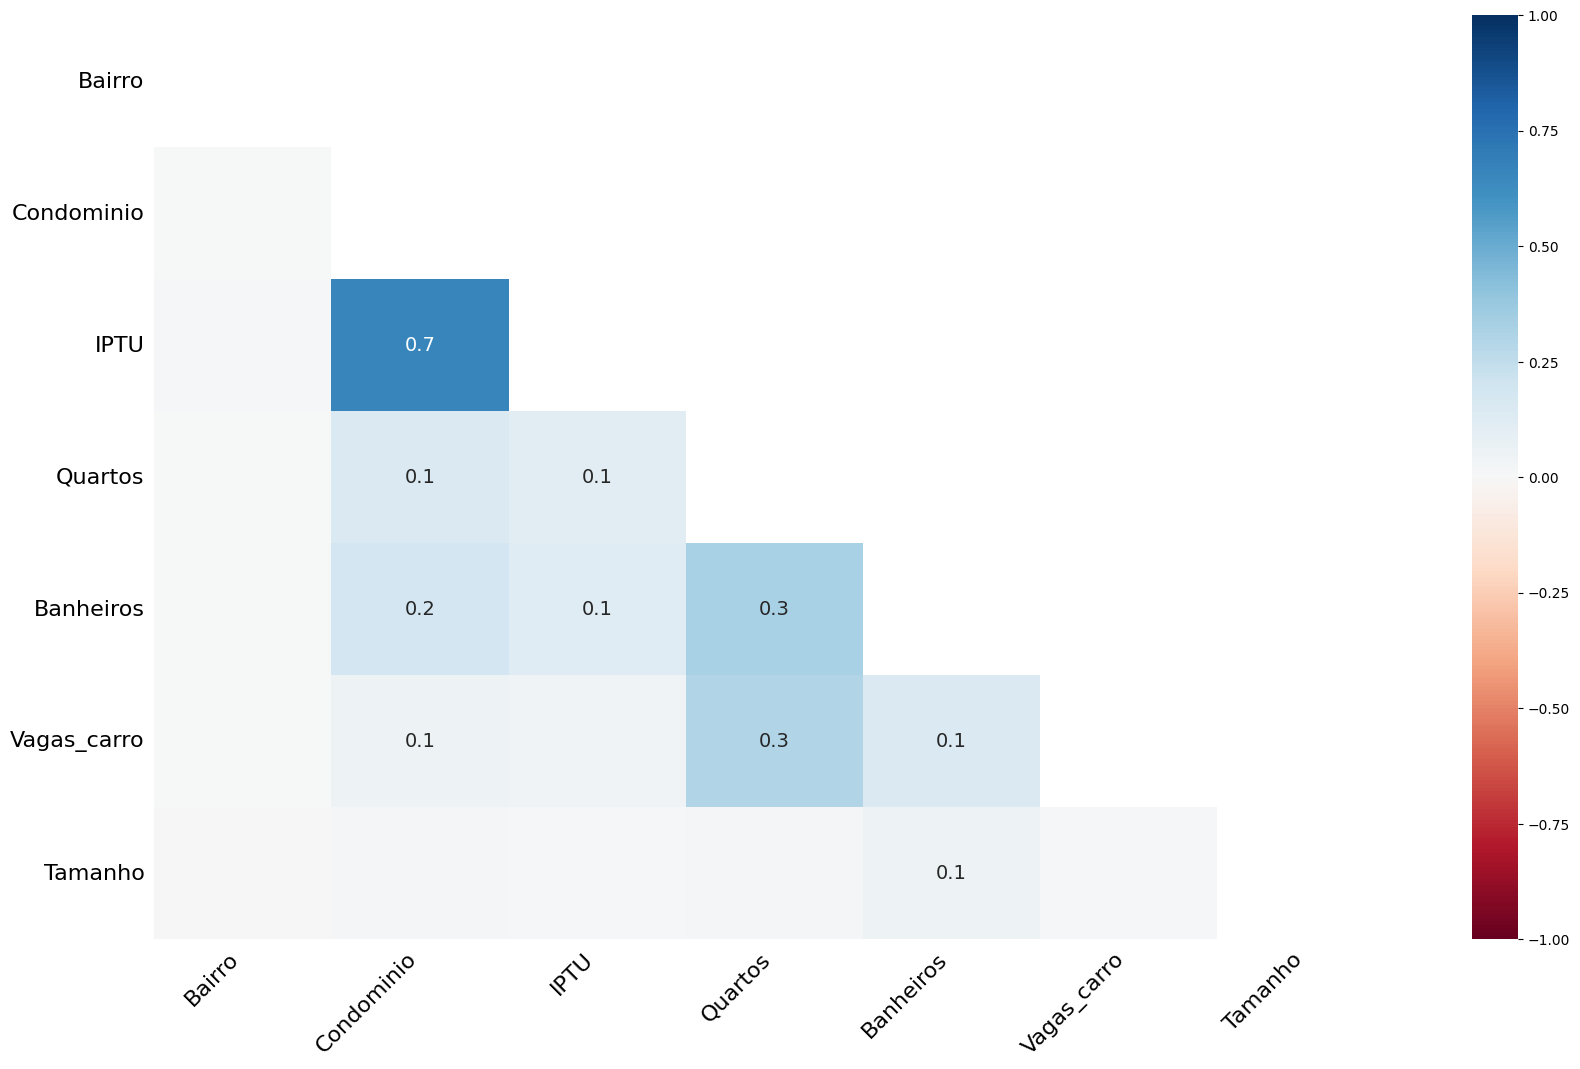

In [27]:
msno.heatmap(df)
plt.show()

As we can see, there is a great correlation between the non-existence of the condominium and IPTU values. Since we cannot find anything else, we will do a group analysis of the categorical variables.

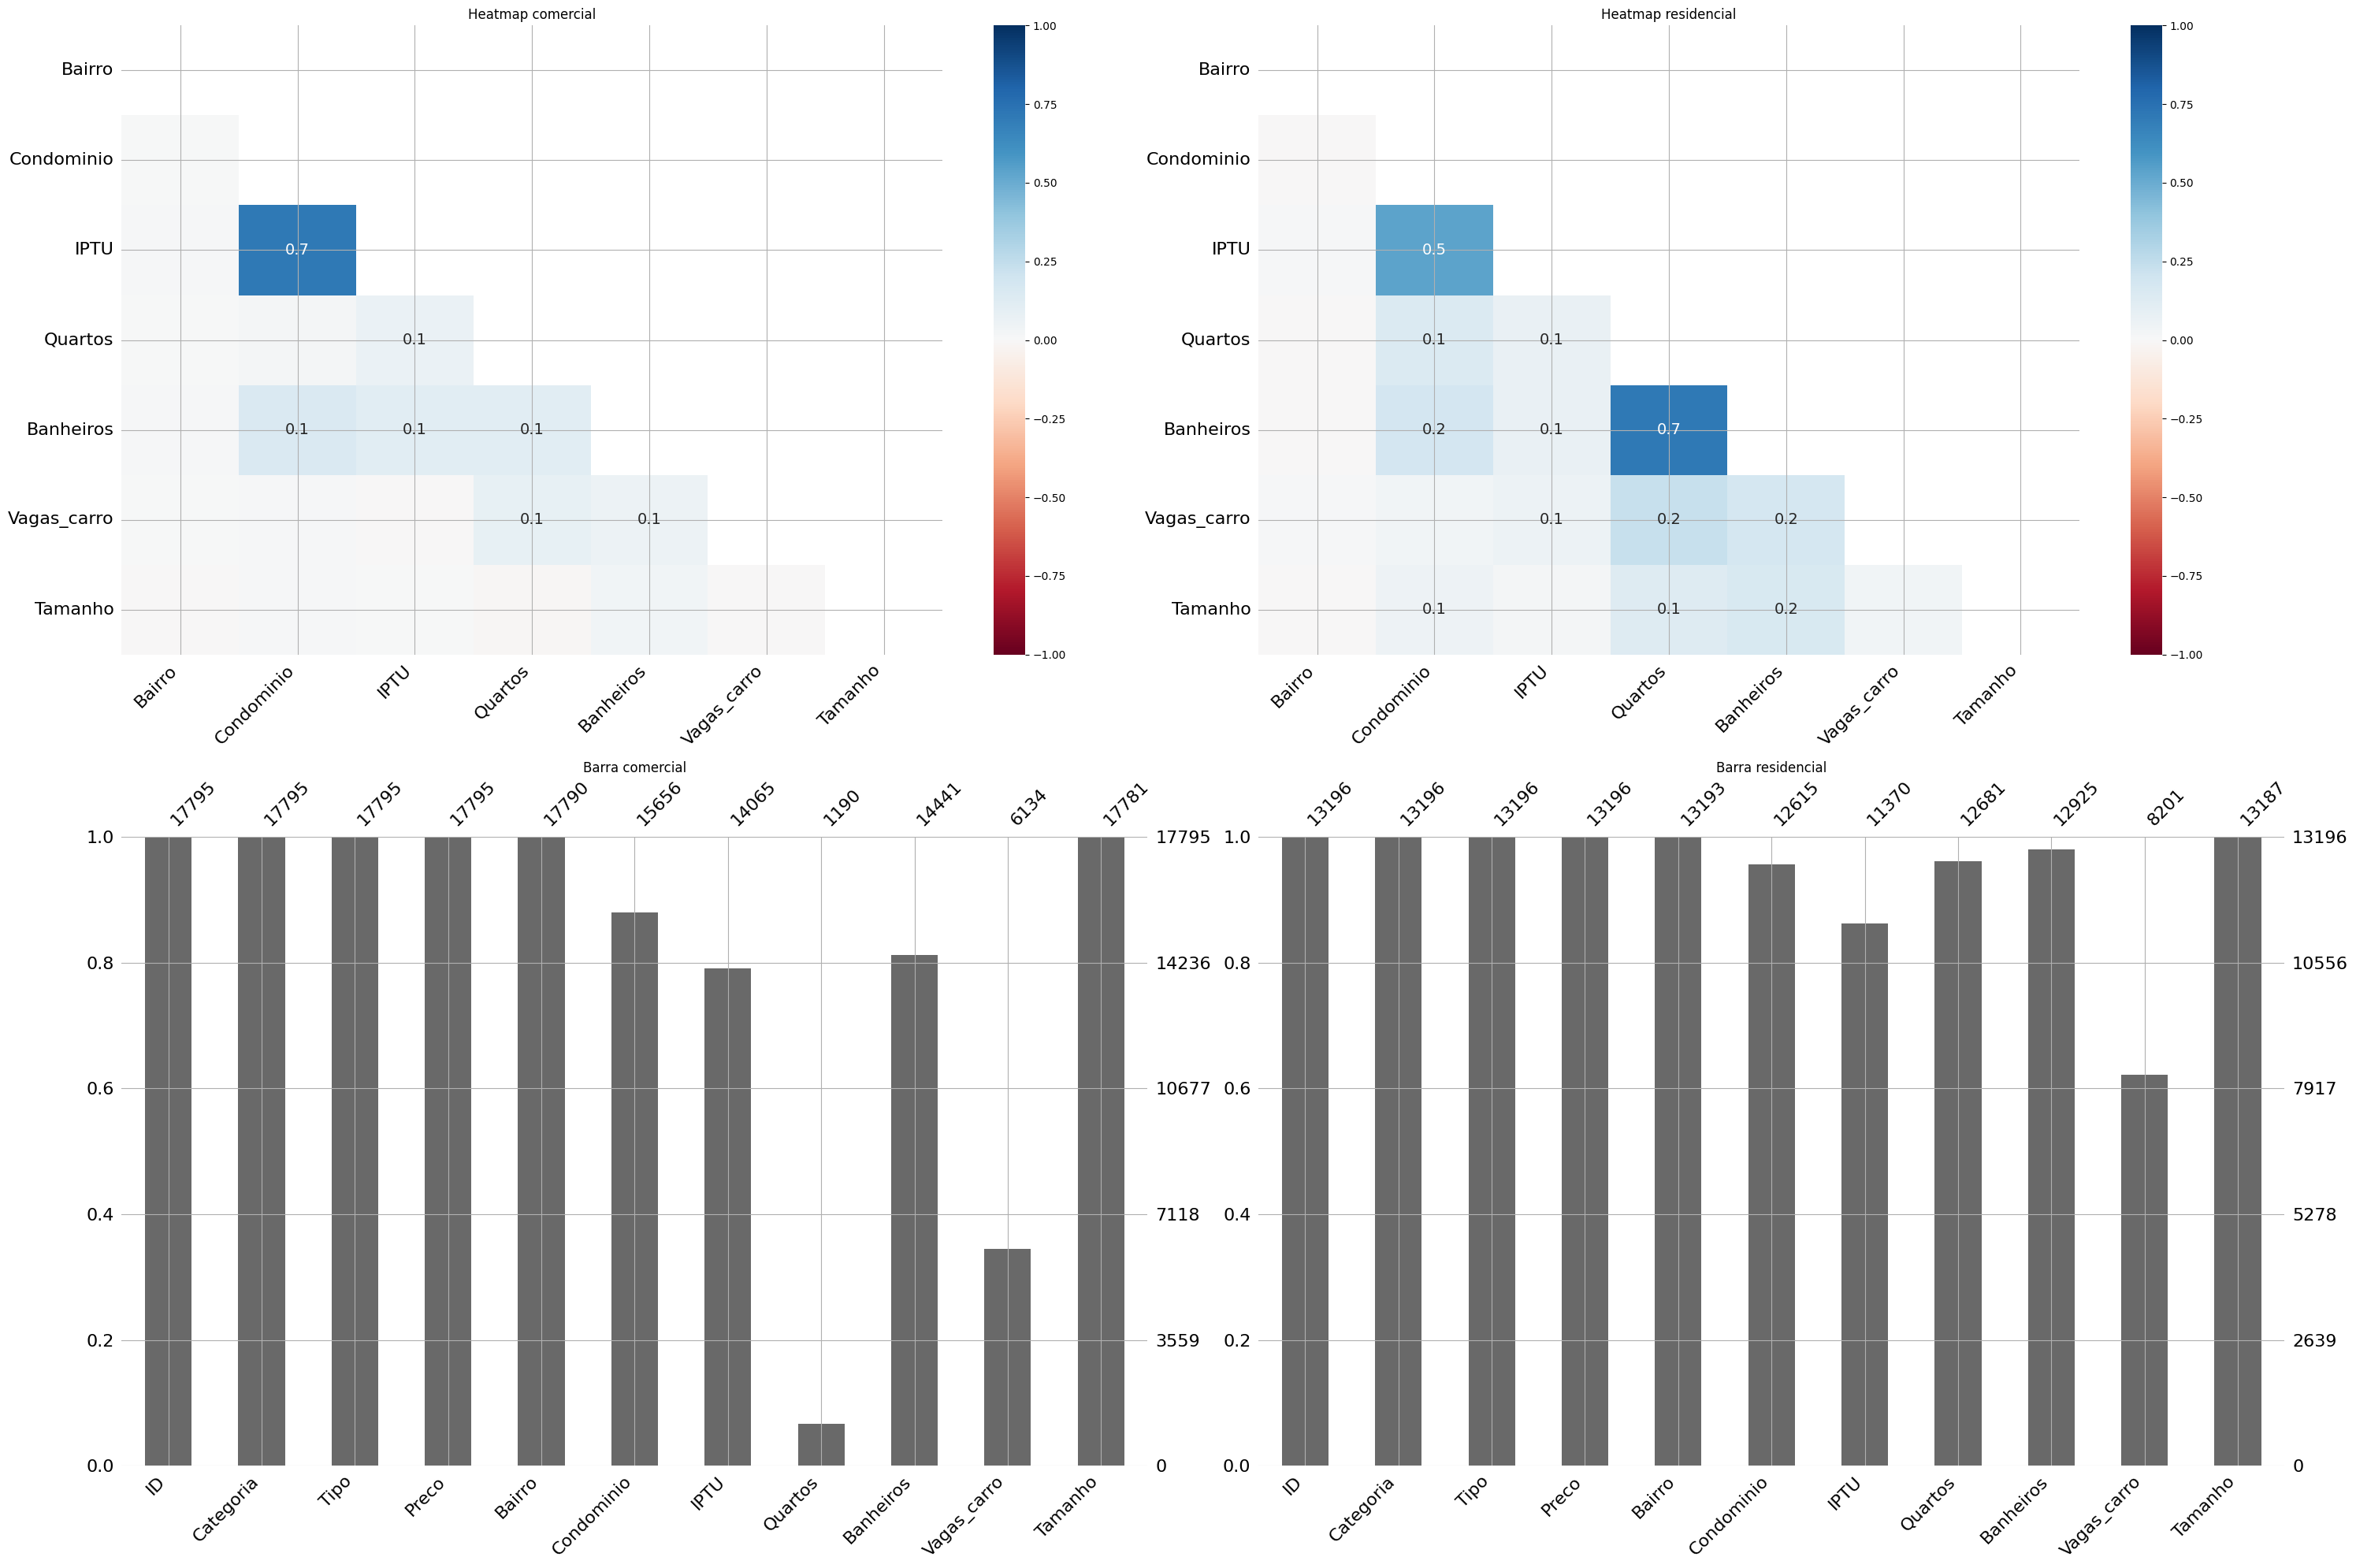

In [28]:
cat_list = df['Categoria'].unique()
figsize=(15*len(cat_list), 10*len(cat_list))
fig, axes = plt.subplots(len(cat_list), len(cat_list), figsize= figsize)

for i, val in enumerate(cat_list):
    ax1 = axes[0, i]
    ax2 = axes[1, i]
    msno.heatmap(df=df[df['Categoria'] == val], ax=ax1)    
    ax1.set_title(f'Heatmap {val}')
    ax1.grid(True)

    msno.bar(df=df[df['Categoria'] == val], ax=ax2)    
    ax2.set_title(f'Barra {val}')
    ax2.grid(True)


plt.tight_layout()
plt.show()


We notice that the number of rooms for the commercial values is very small, reaching more than 80% of null values. In the residential part, the null values of bathrooms and bedrooms have a great correlation, i.e., the null values occur together in a large part of the values. However, the values for car parking spaces have a large amount of null values in both categories.

We will now analyze the type of property

In [29]:
cat_list = df.groupby('Tipo').filter(lambda x: len(x) > 150)['Tipo'].unique()

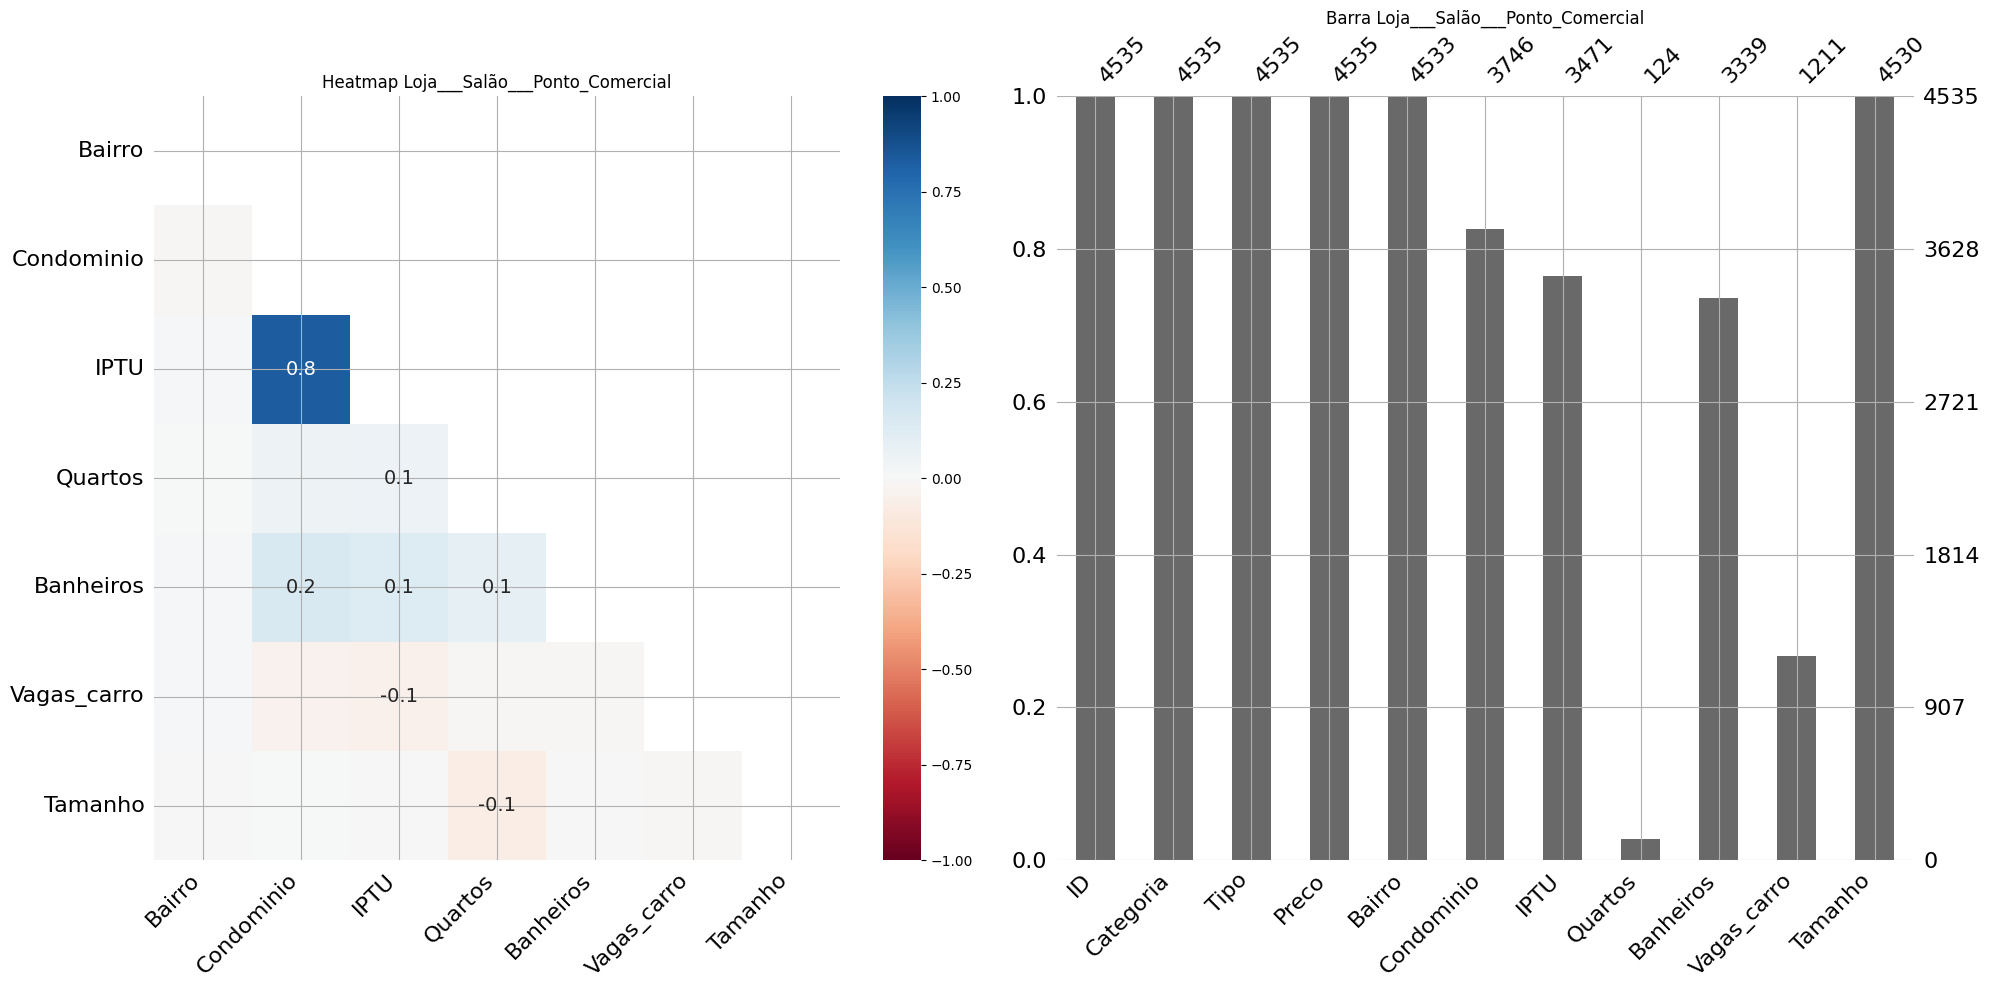

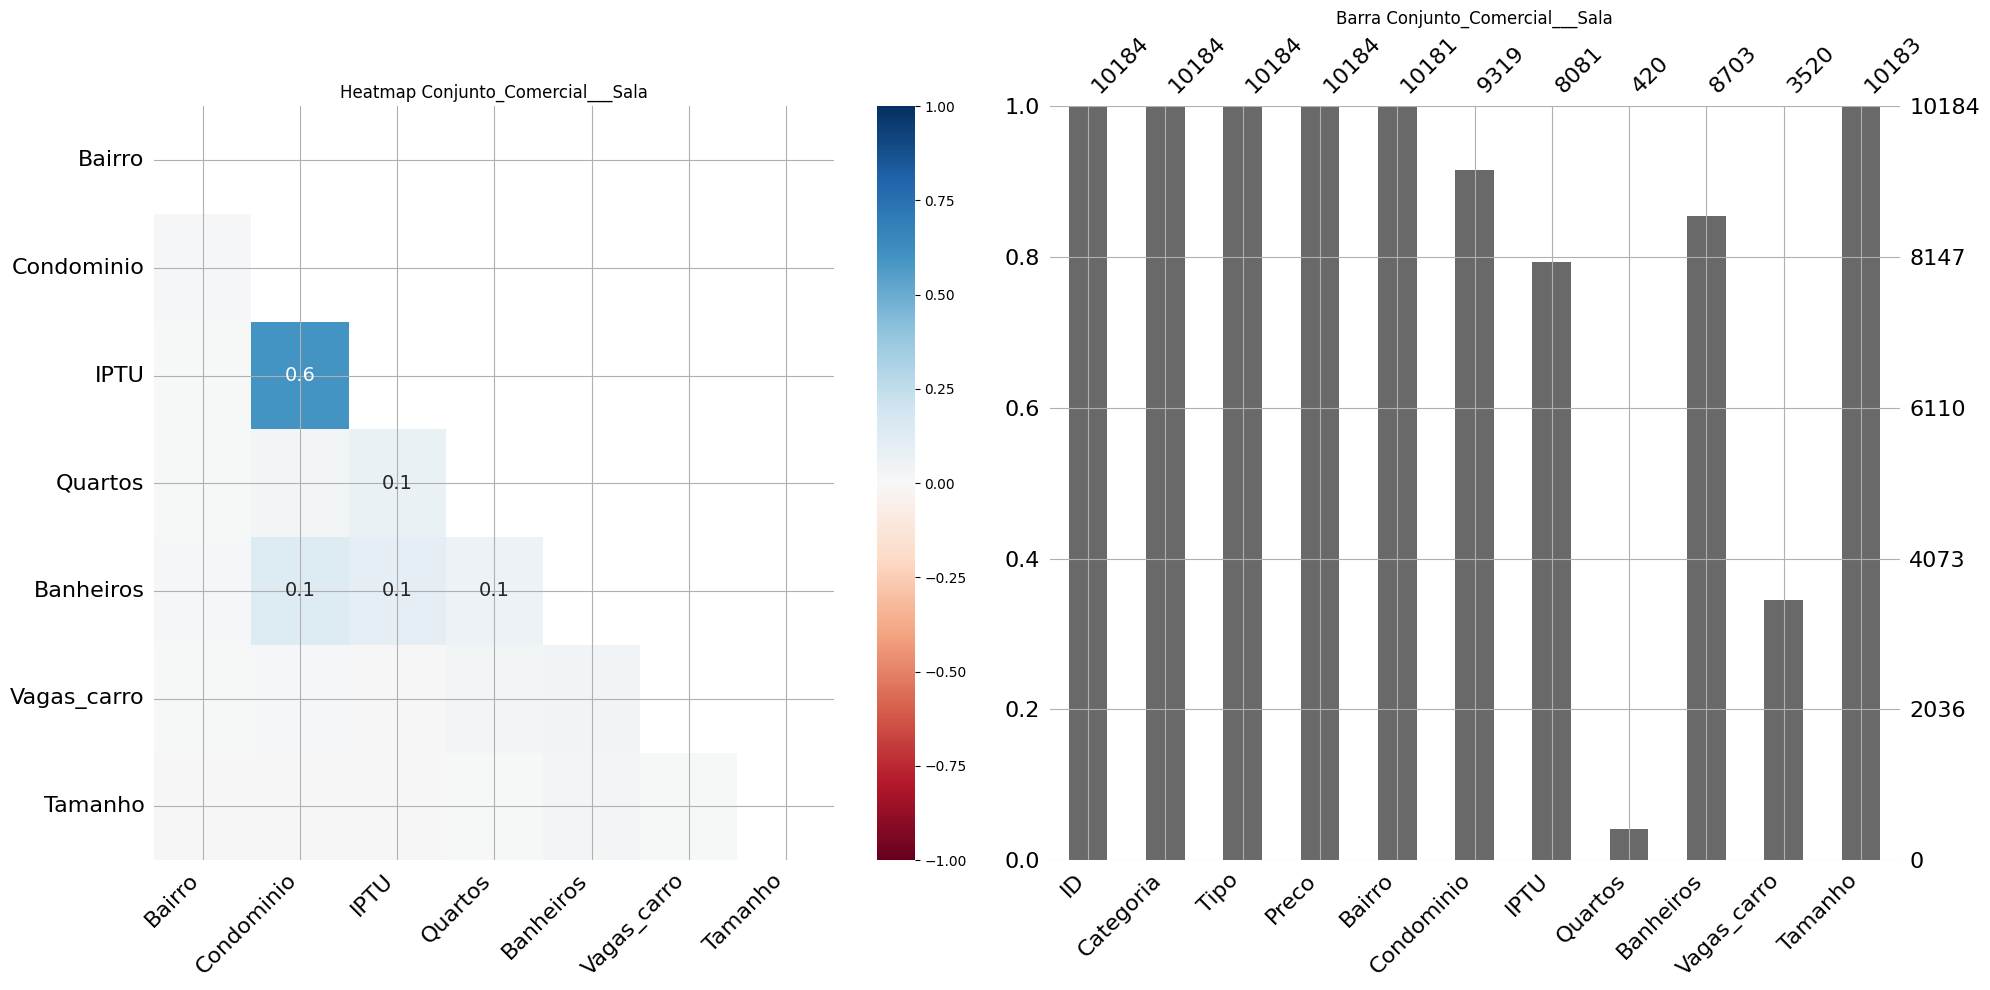

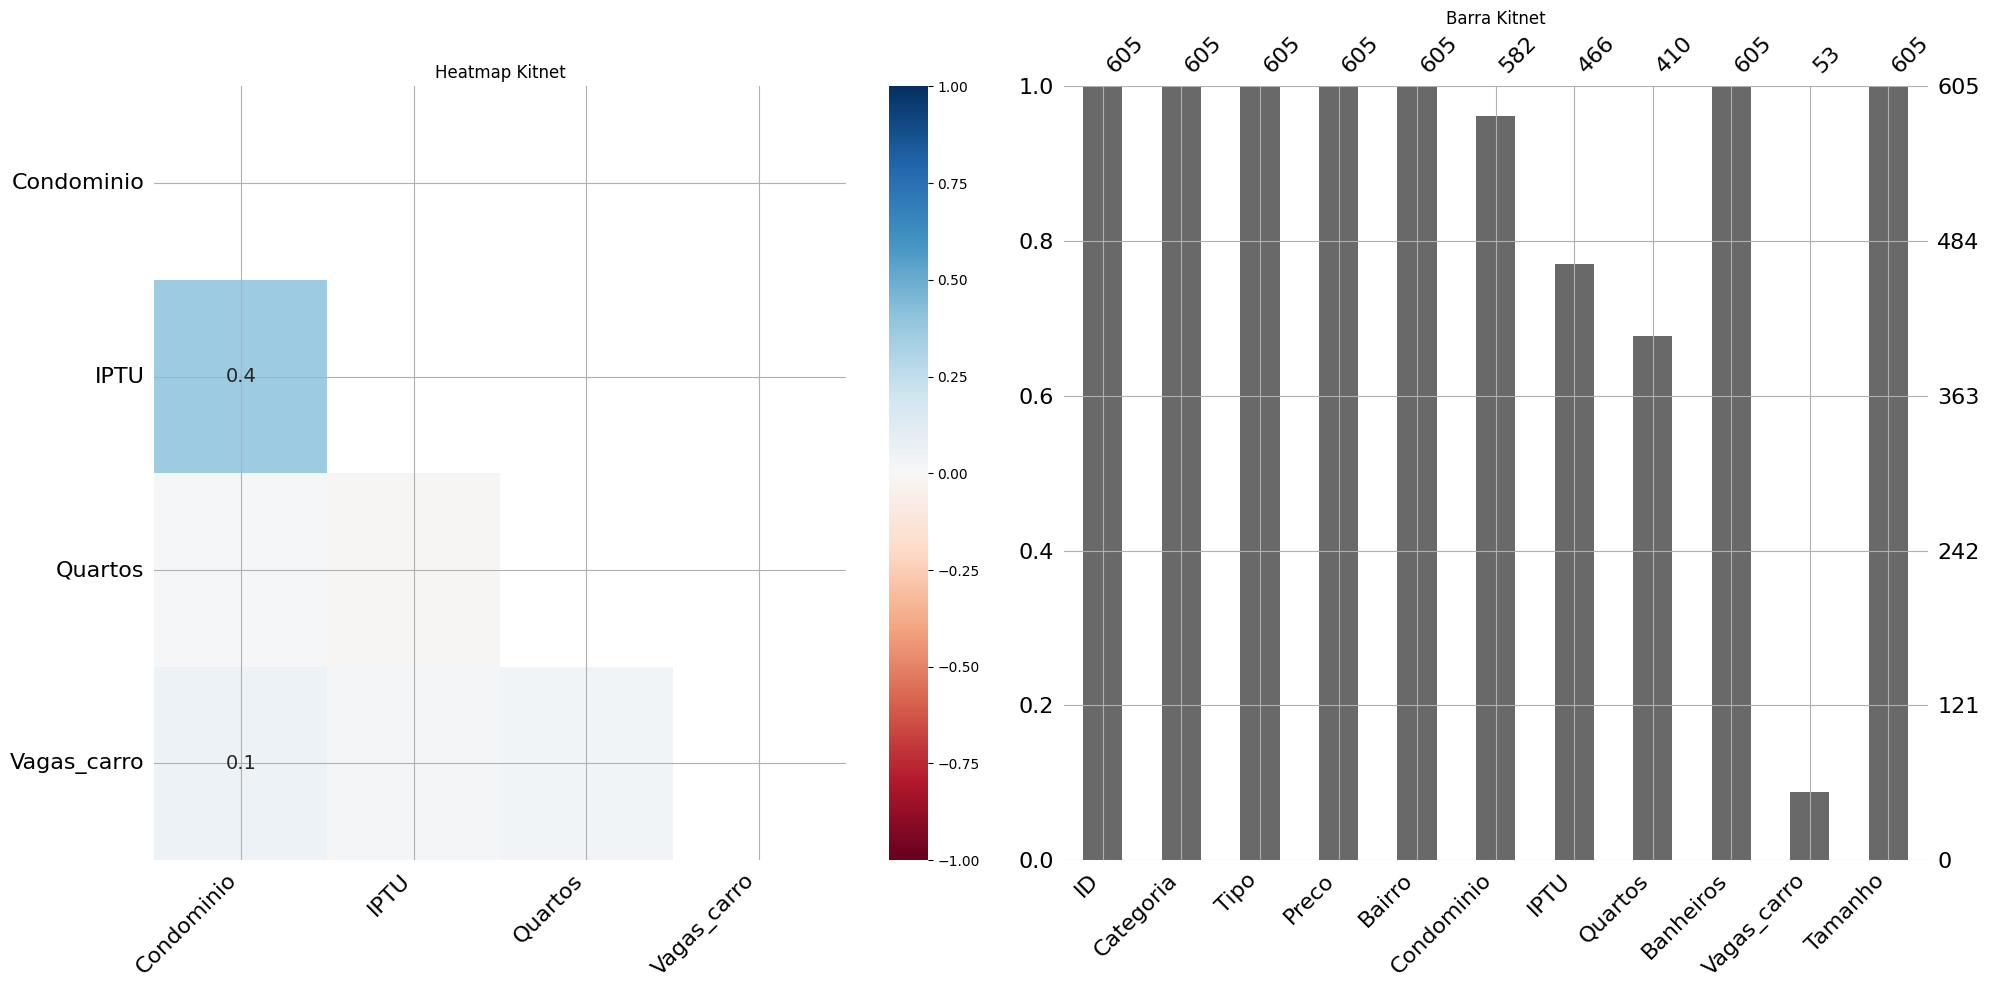

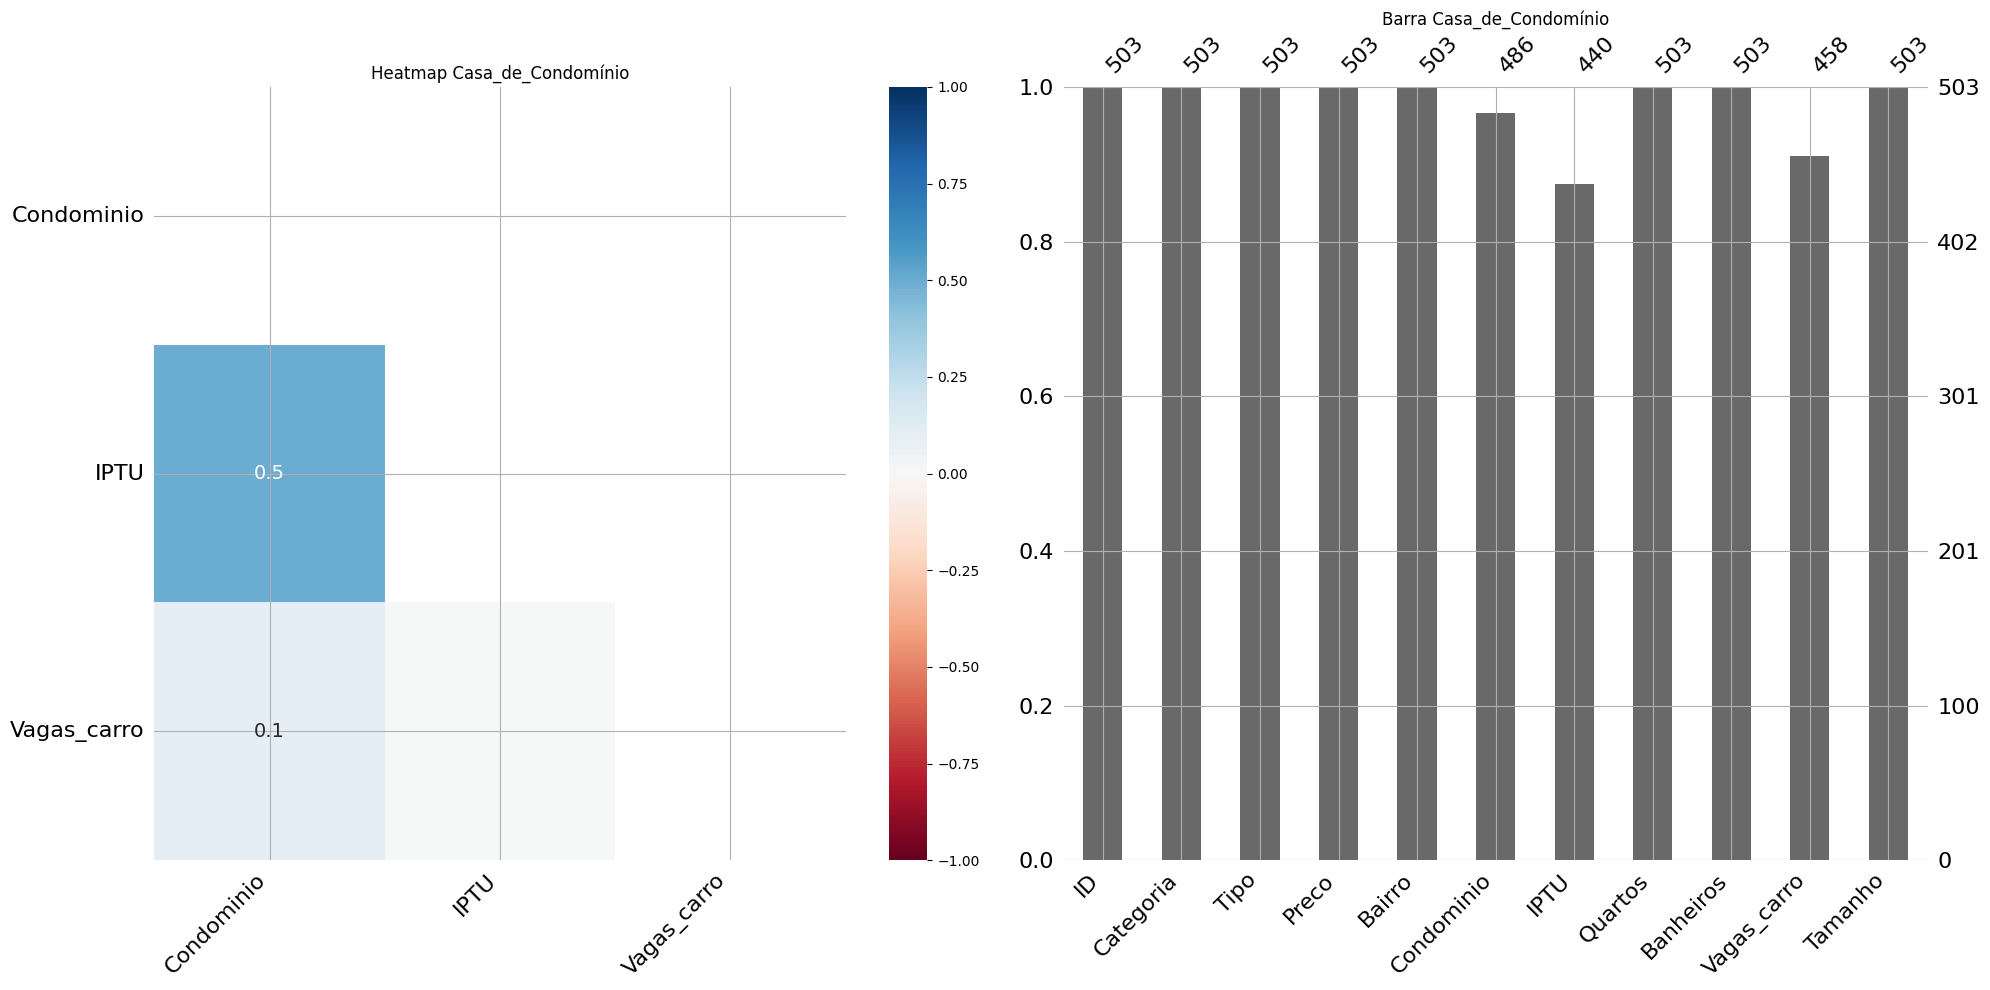

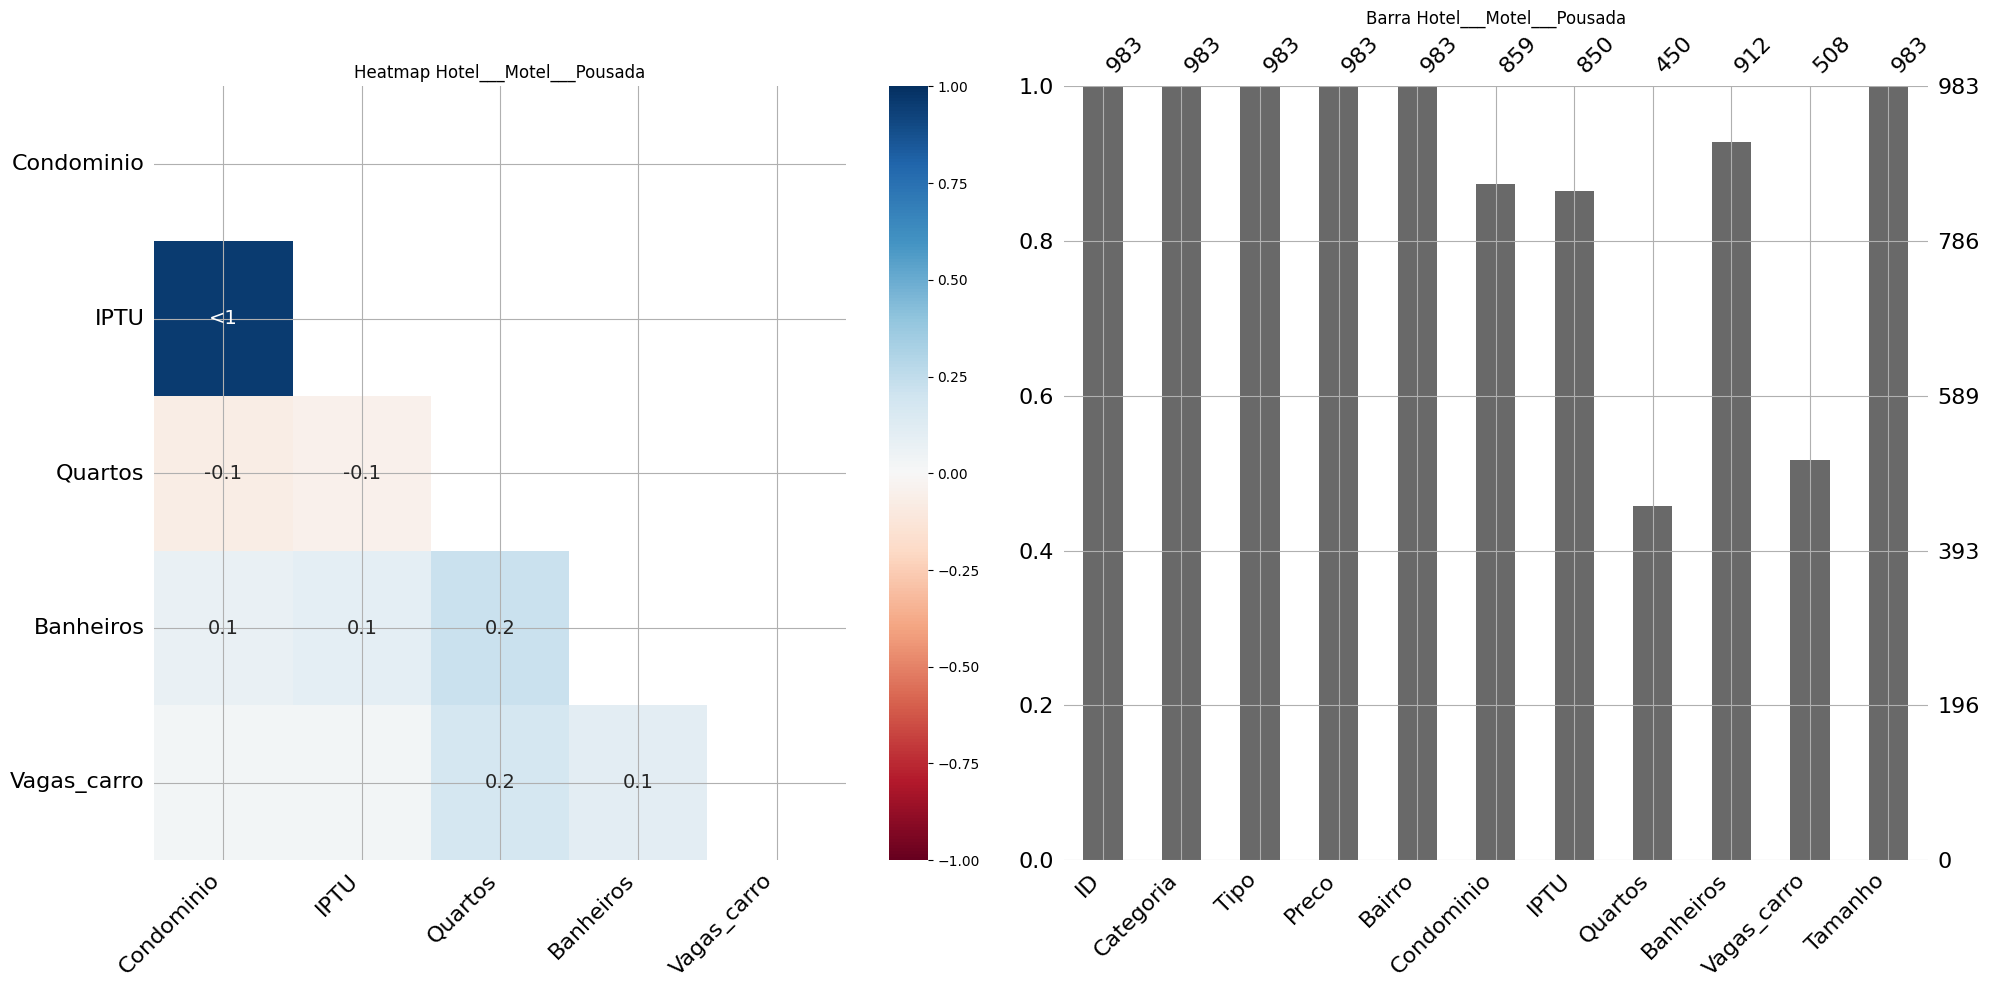

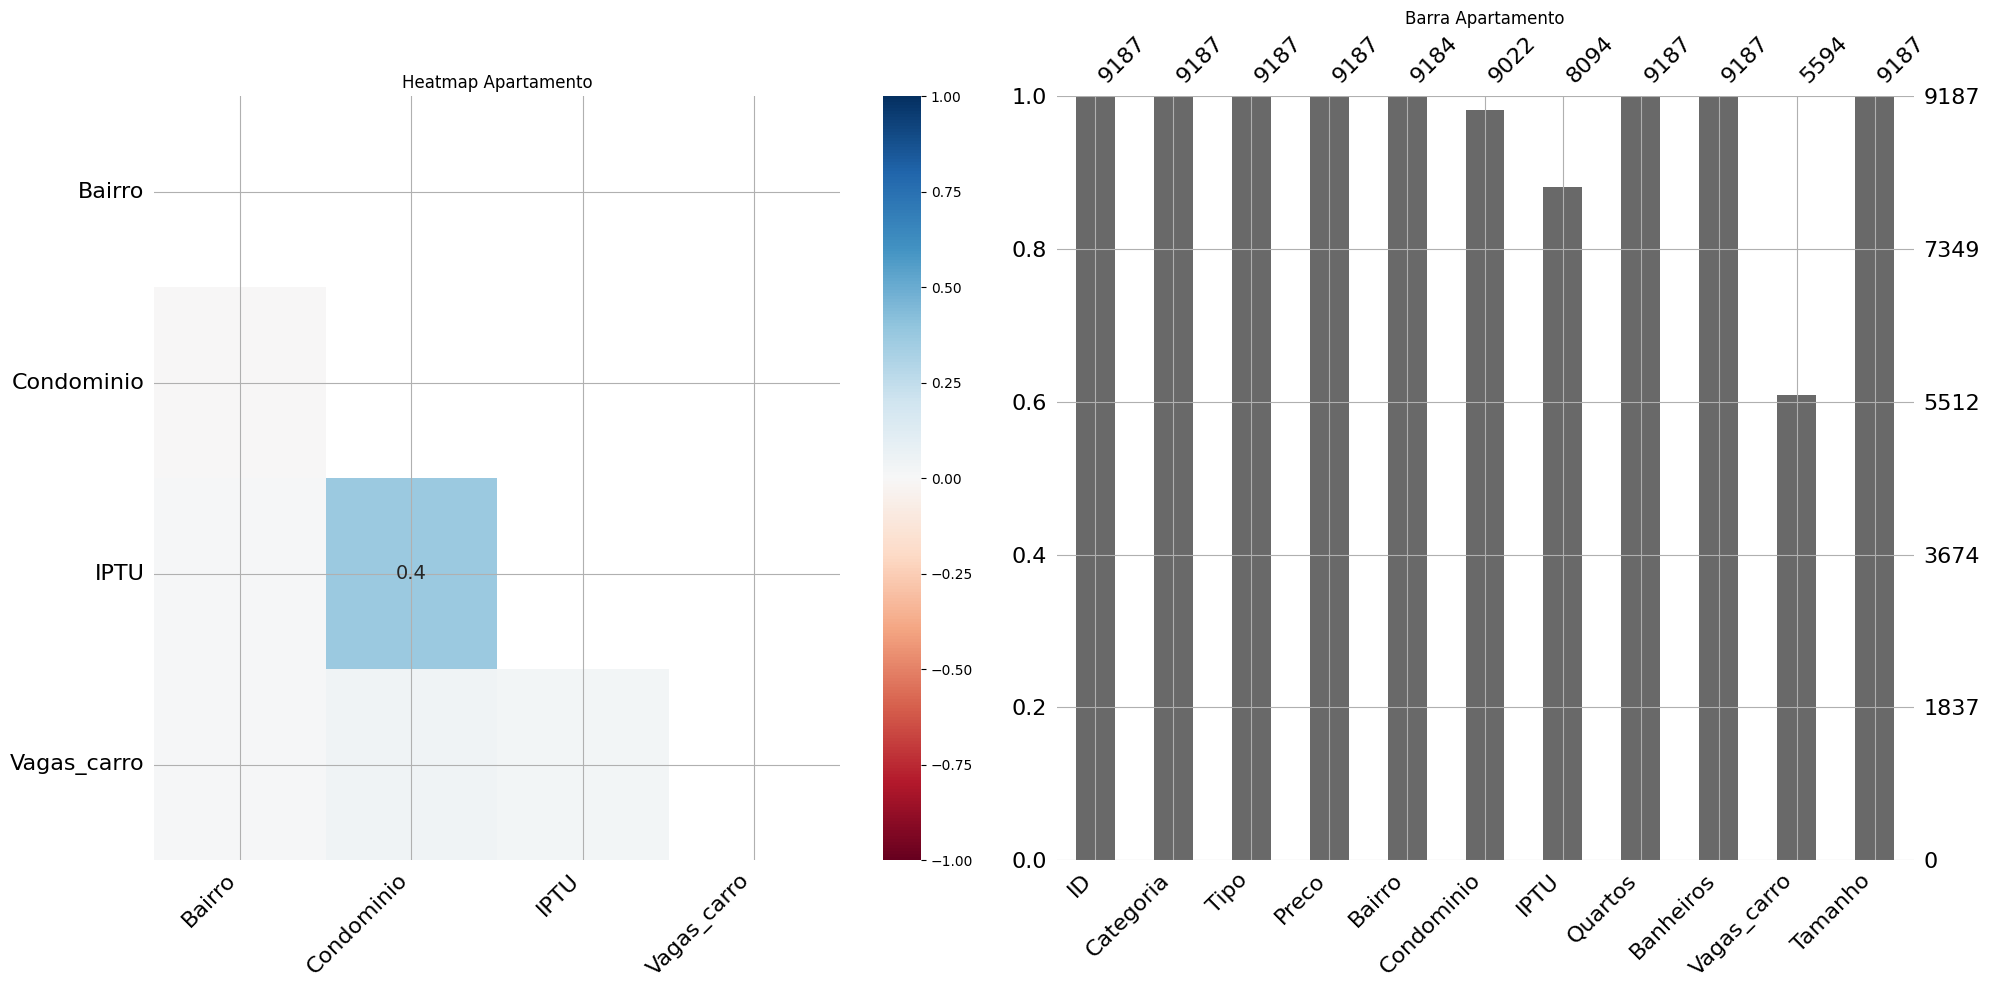

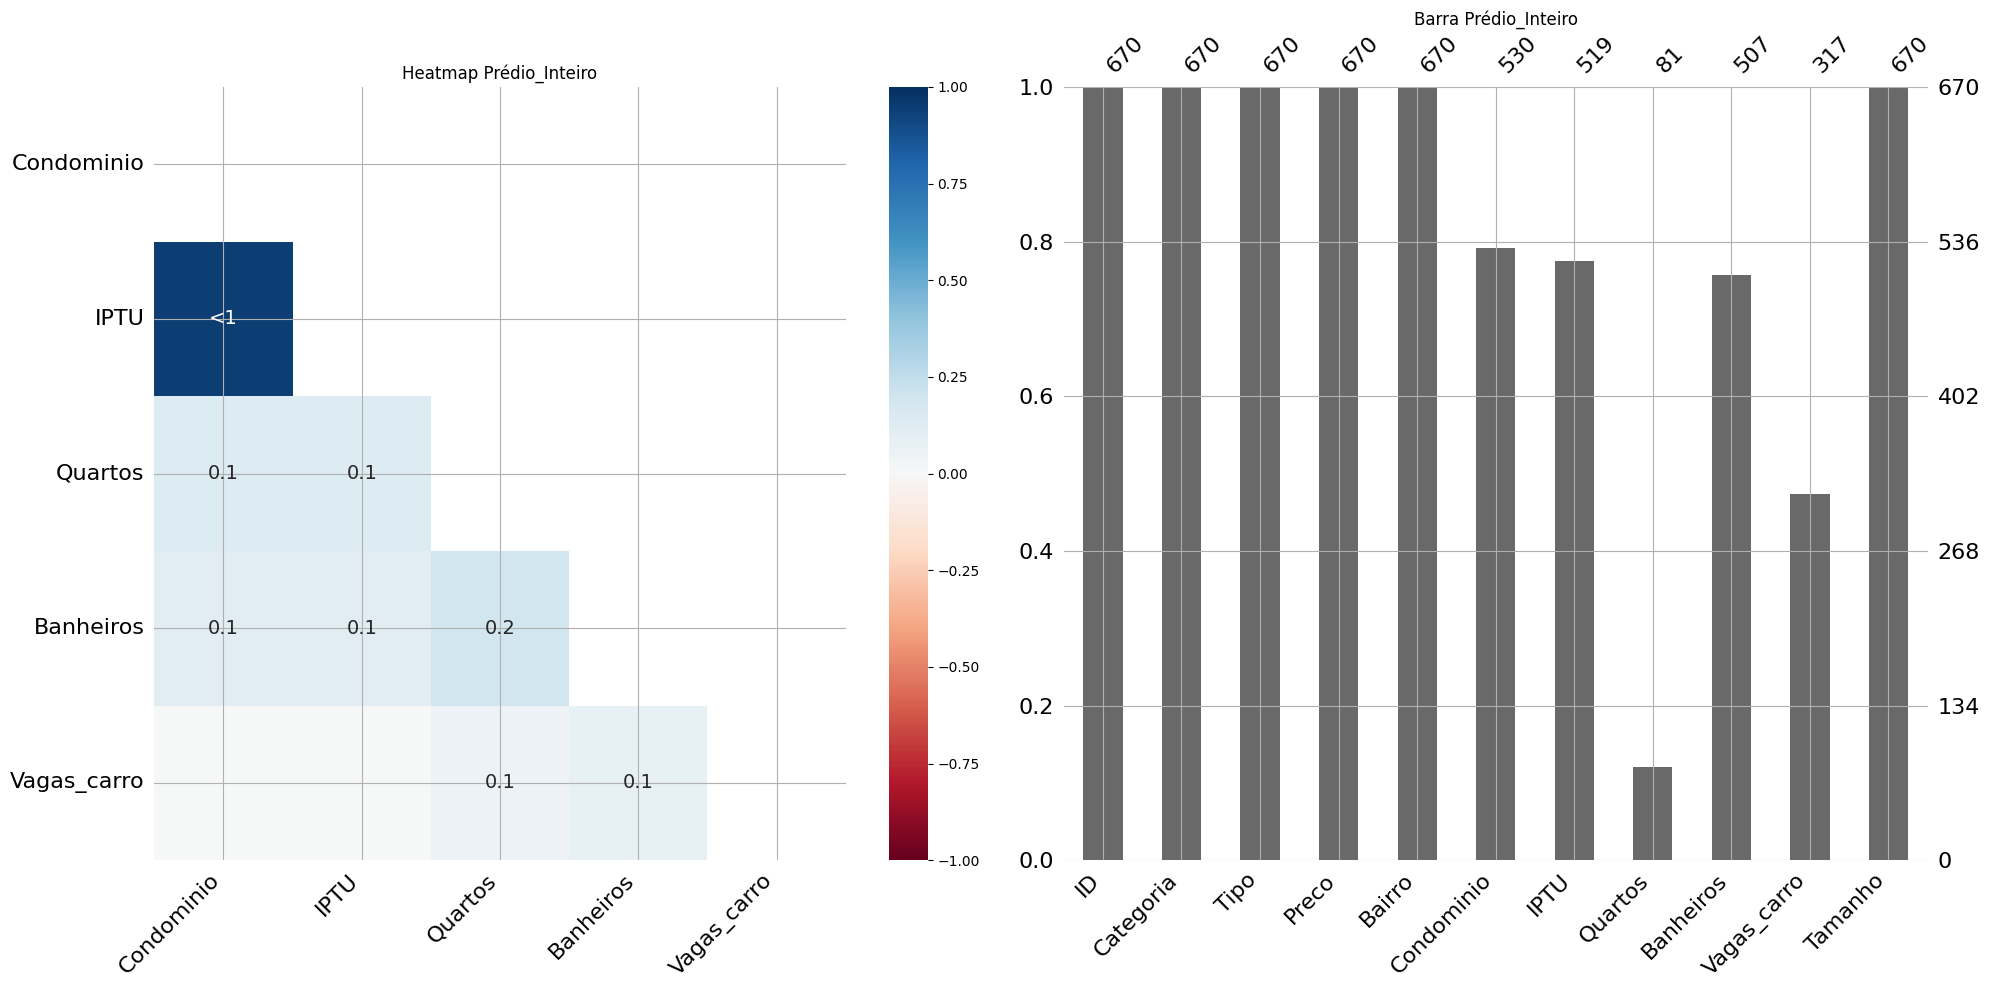

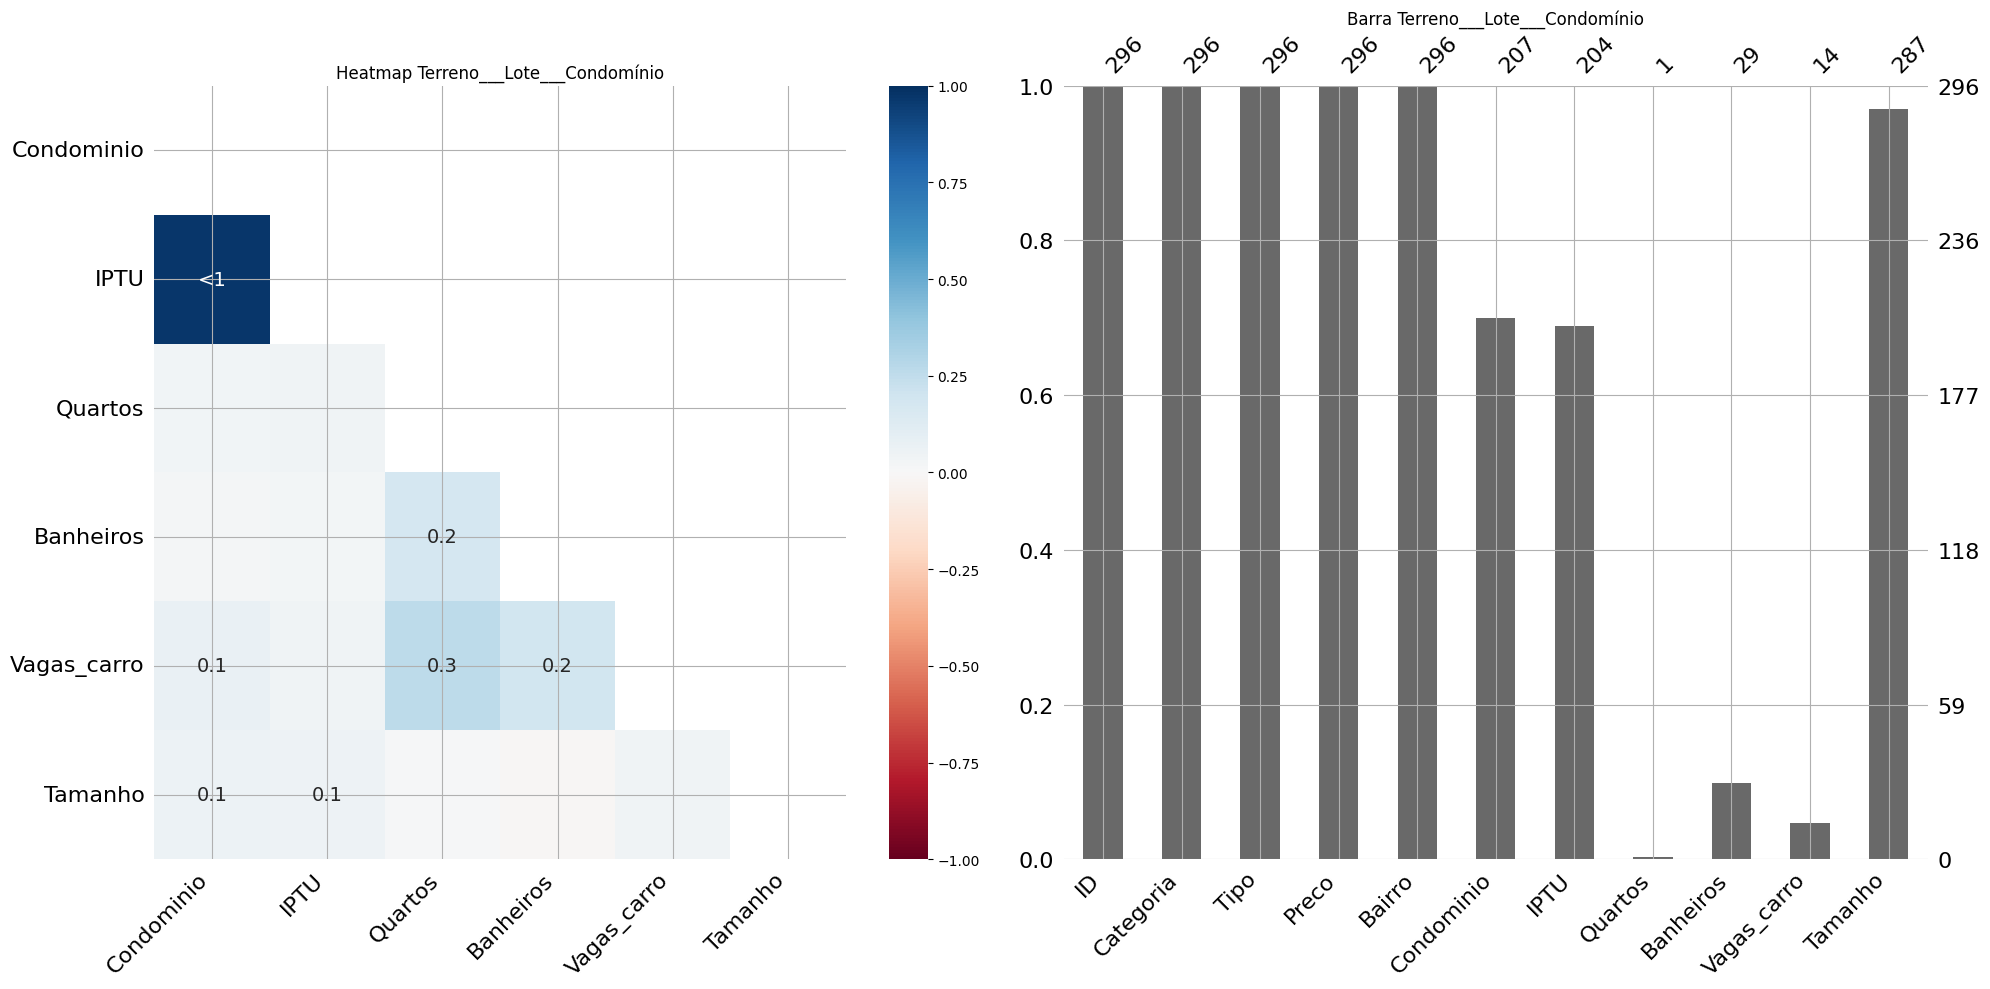

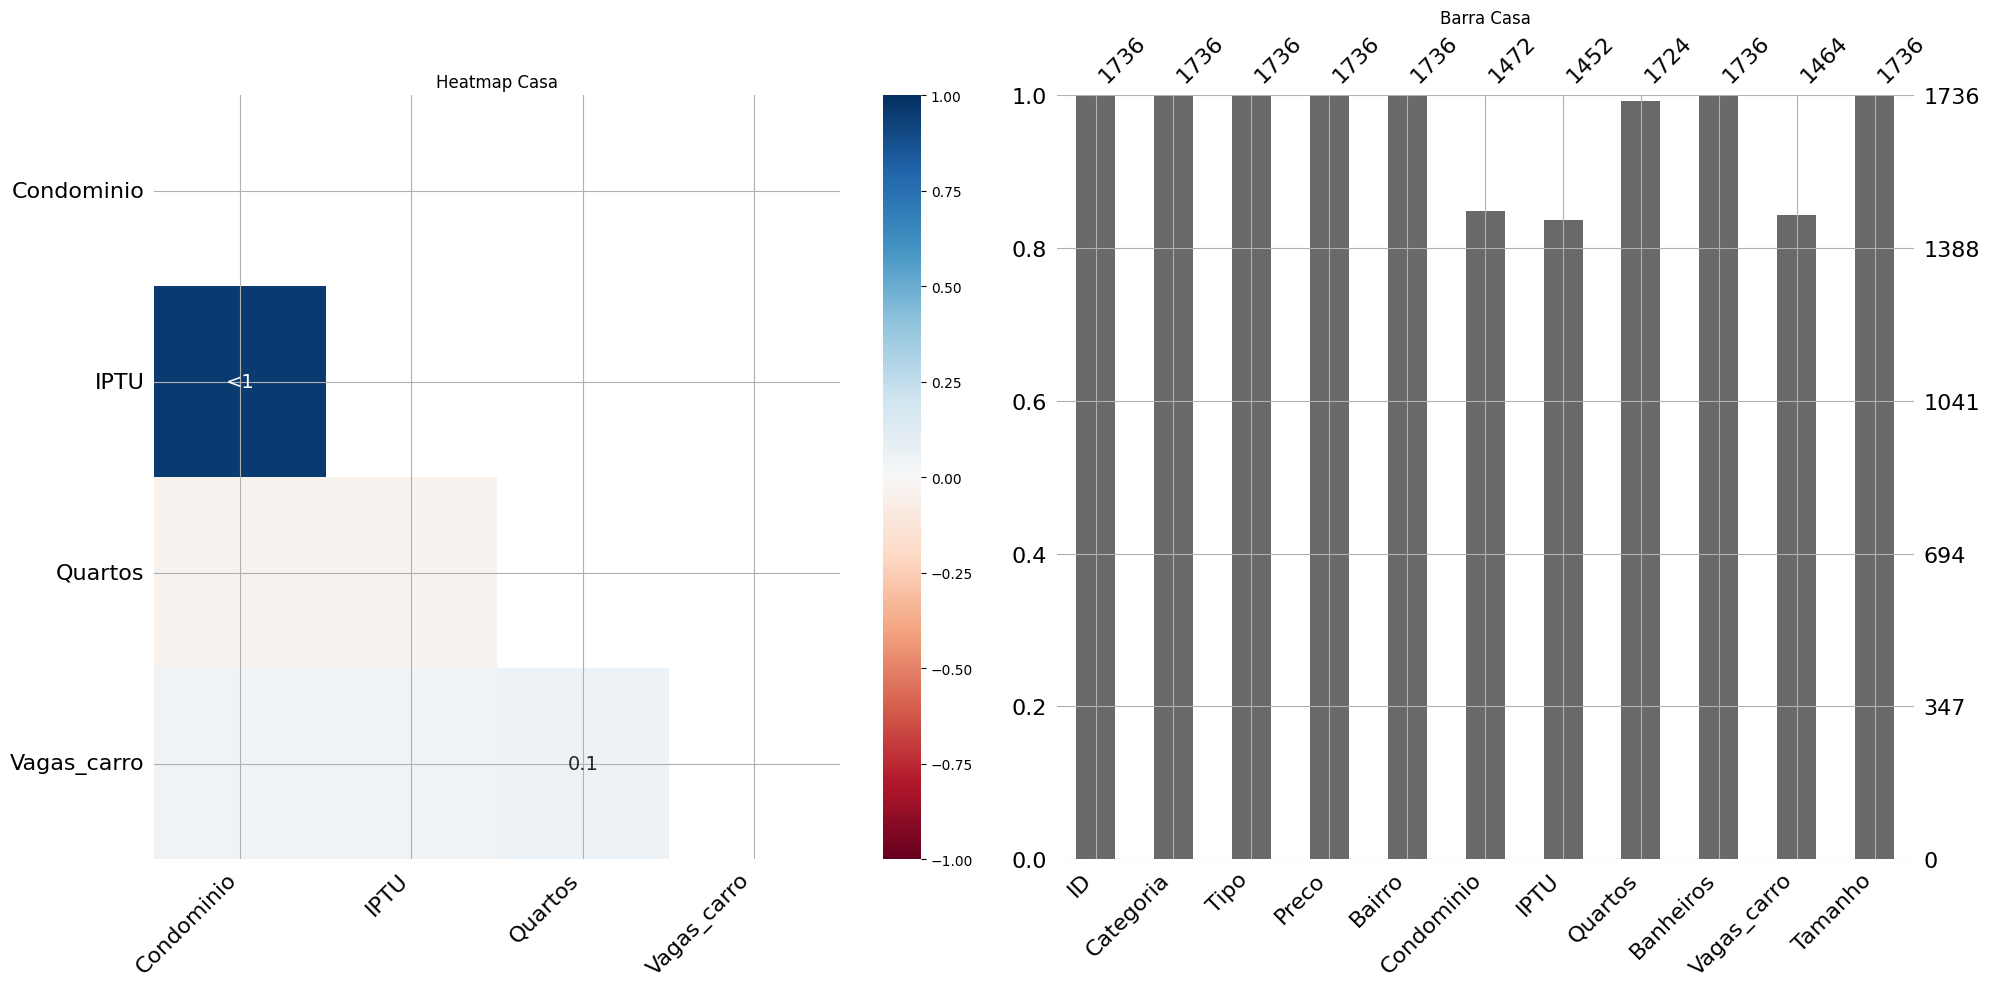

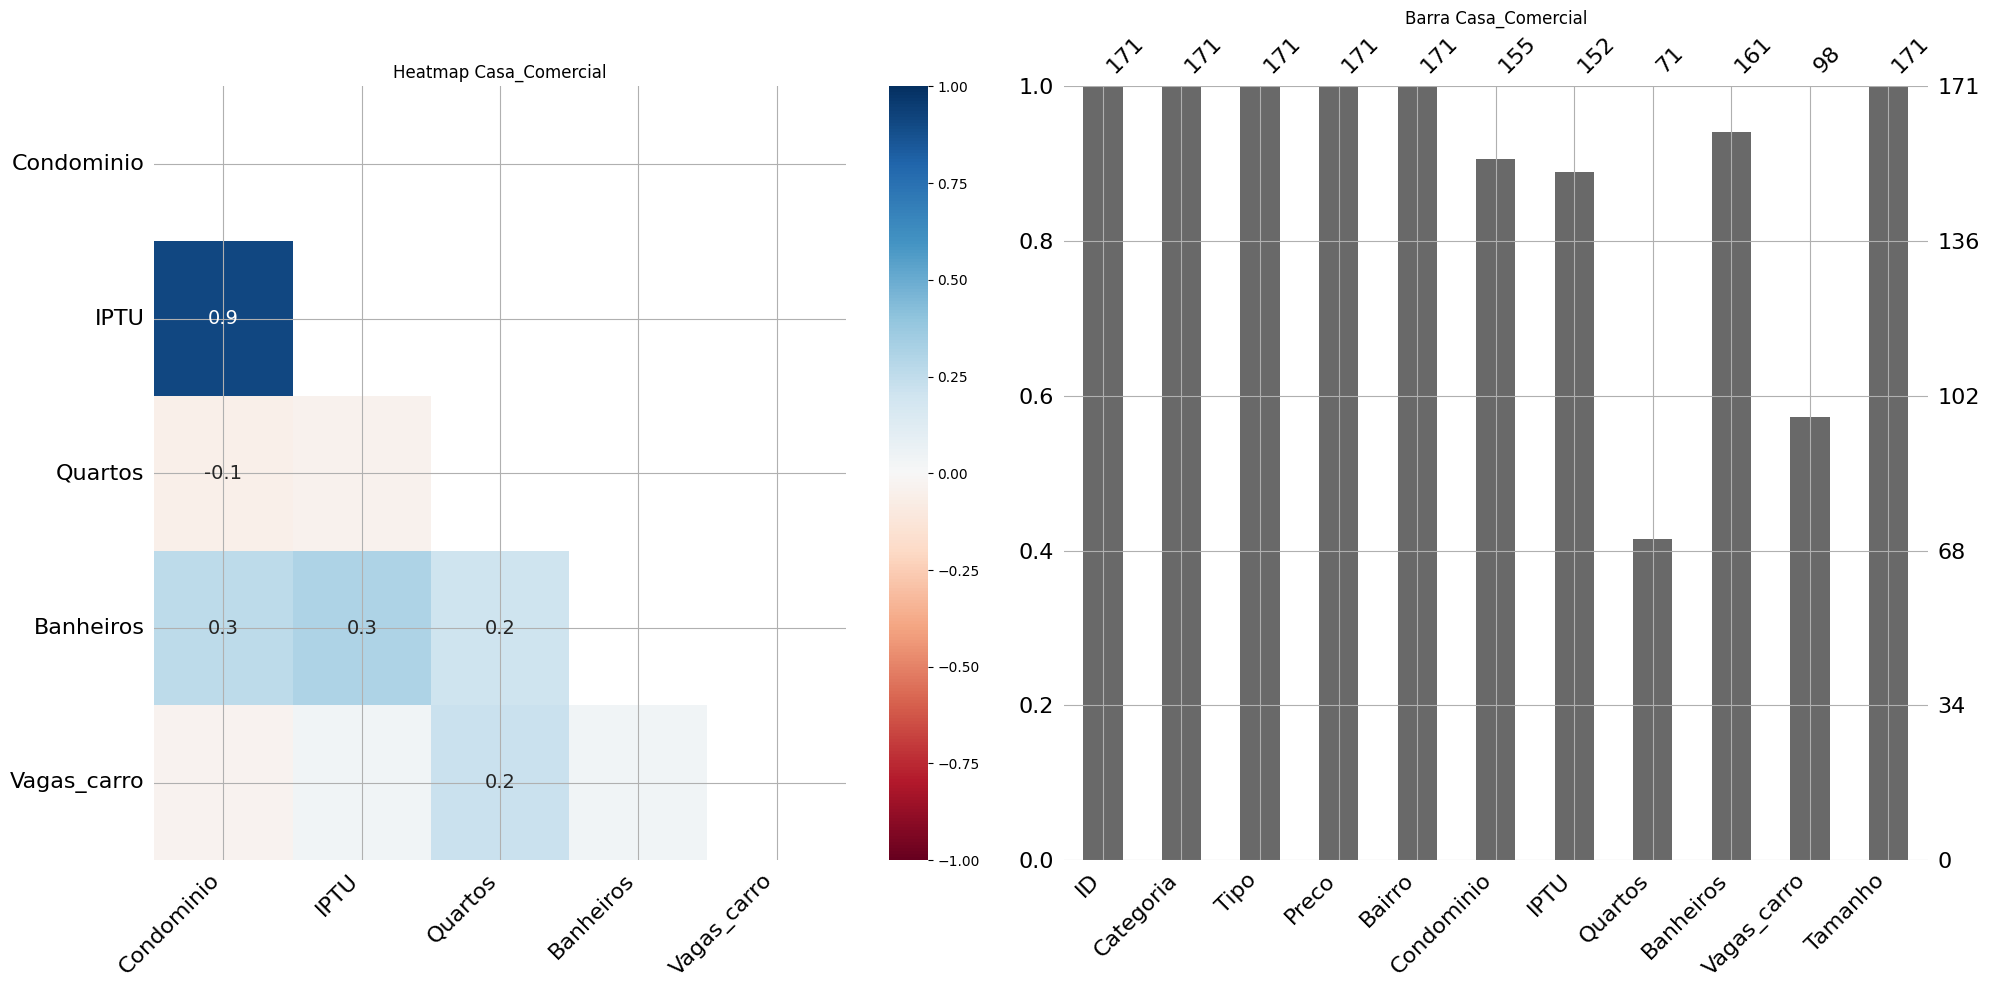

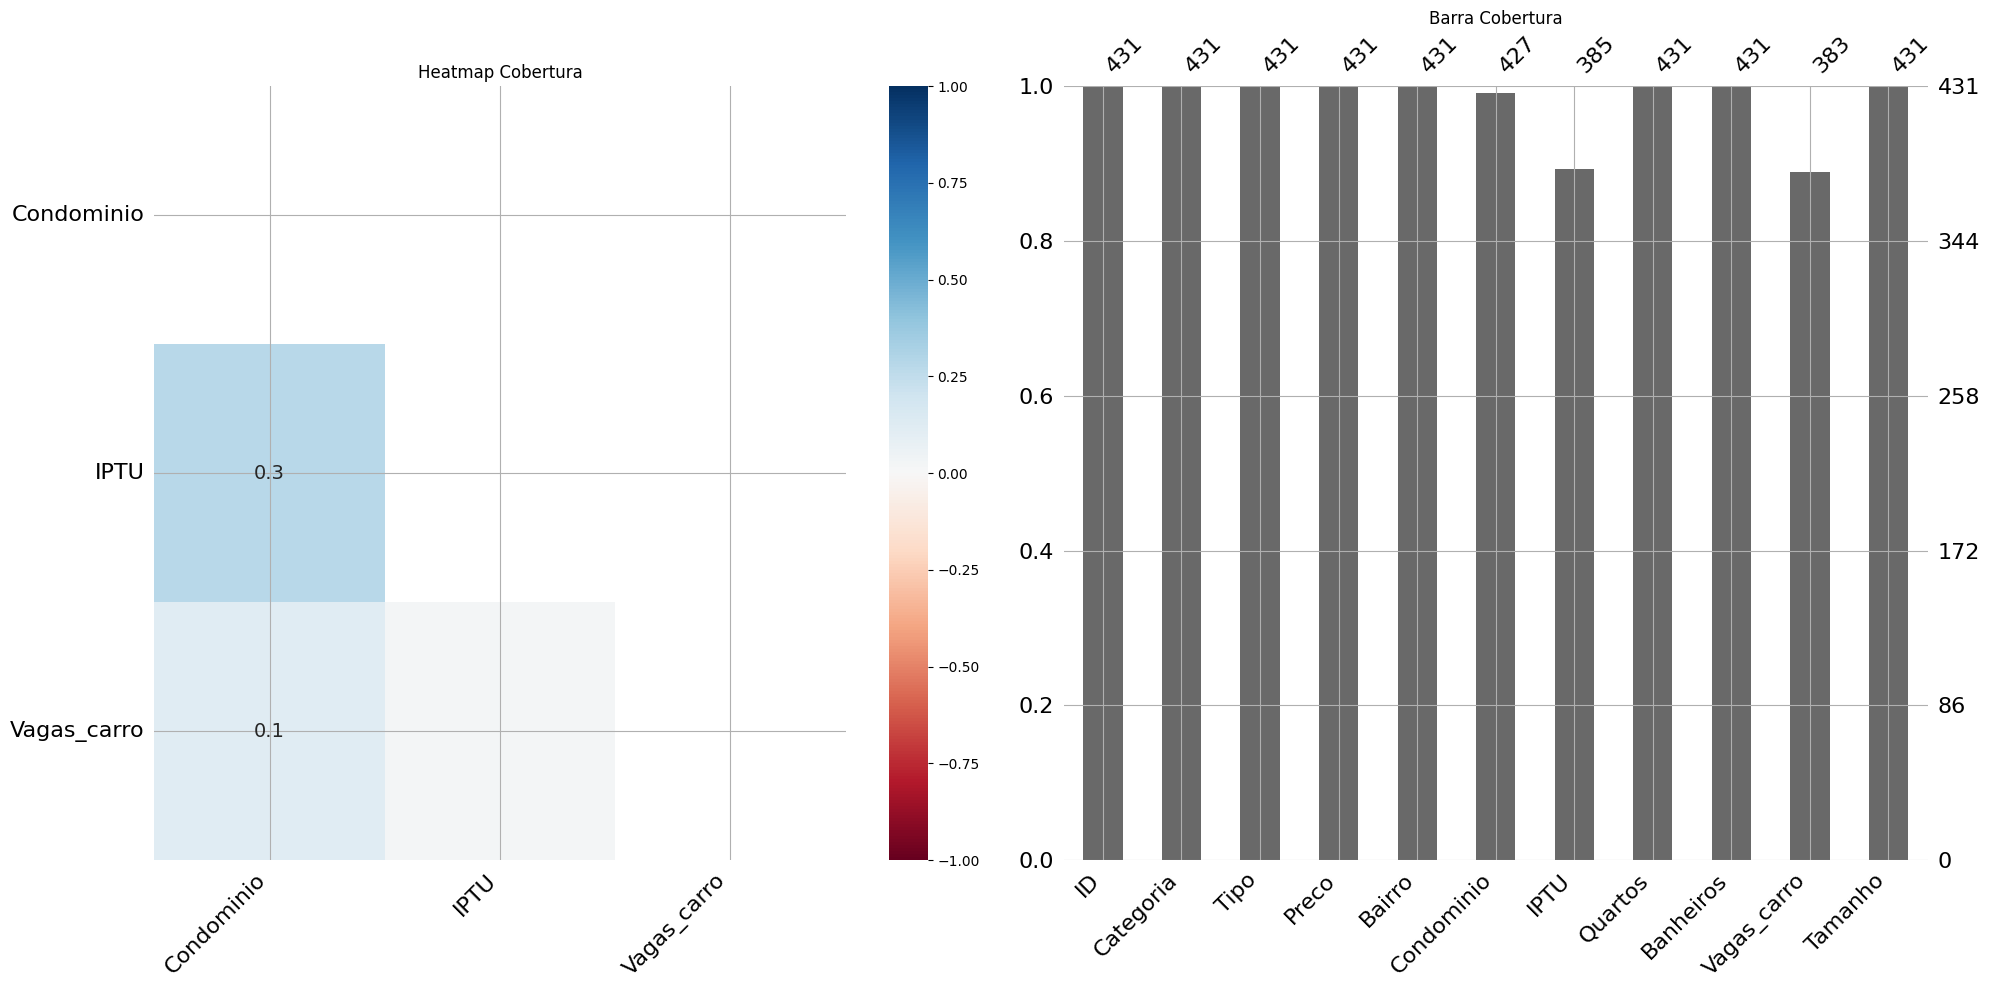

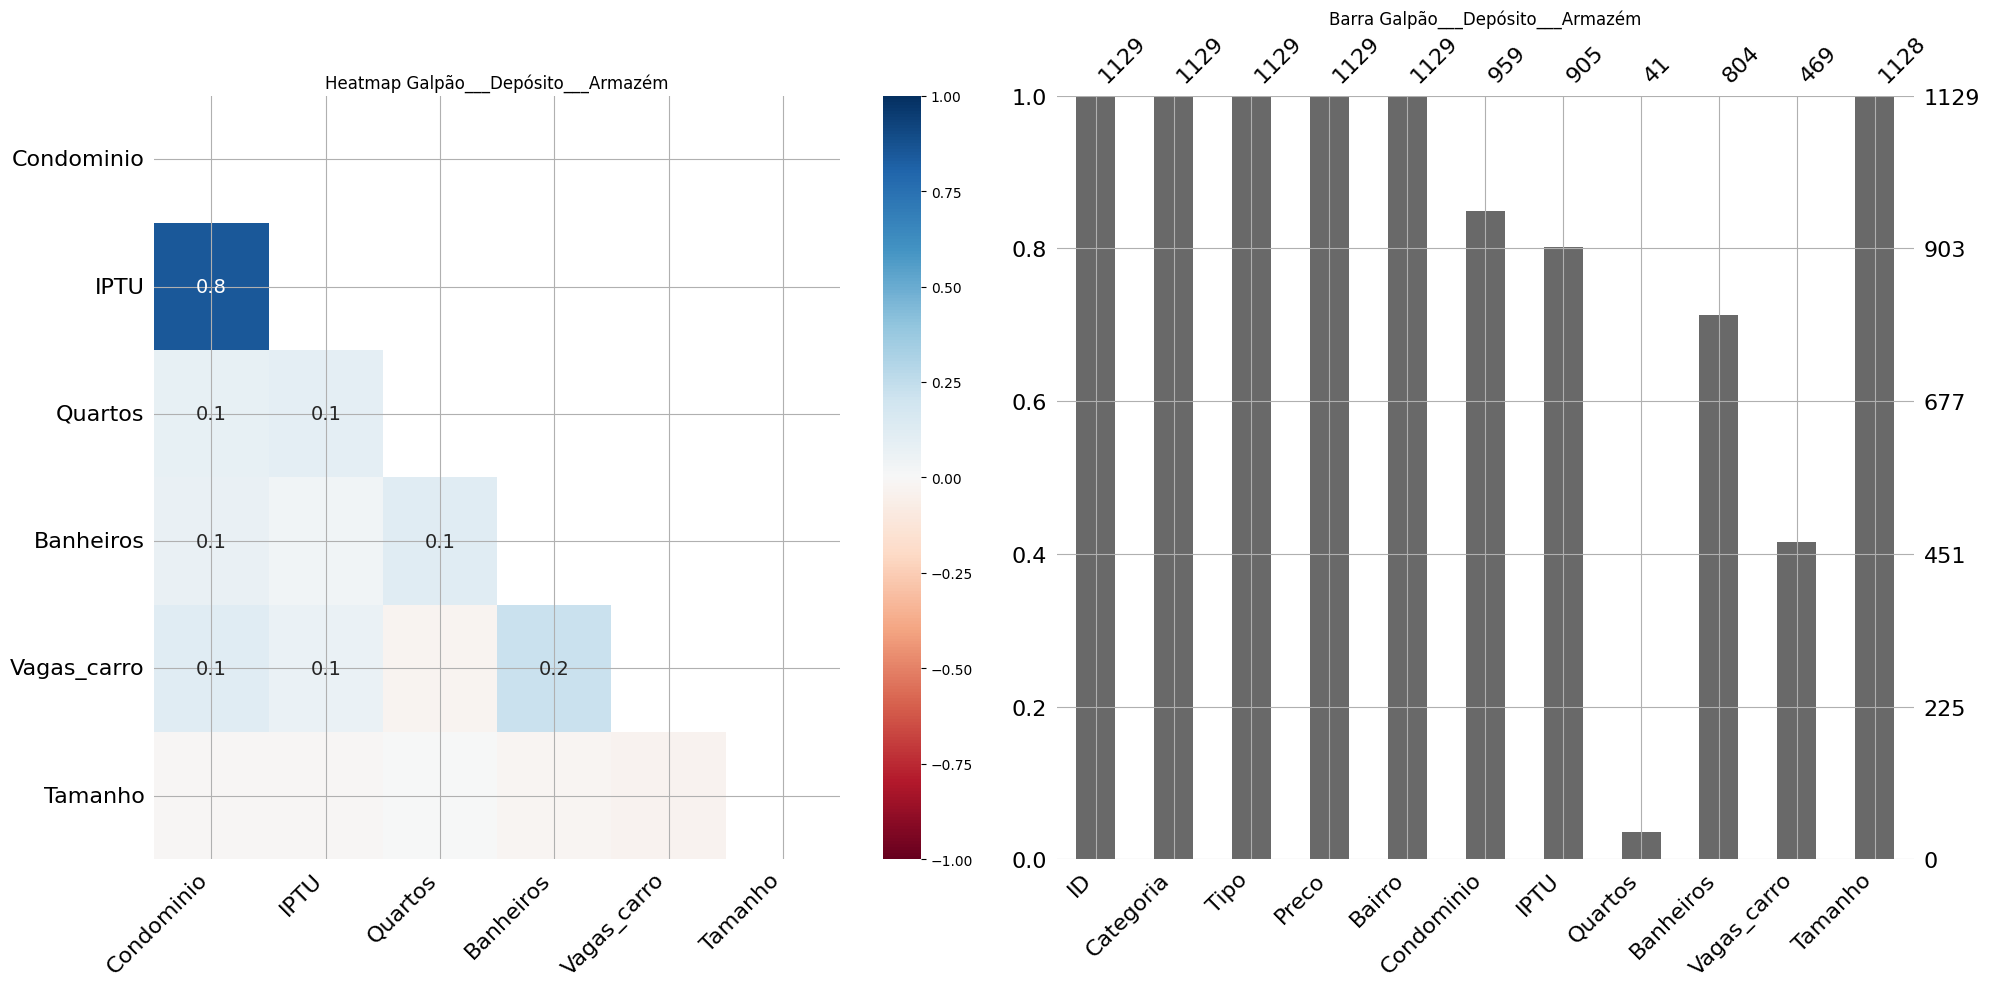

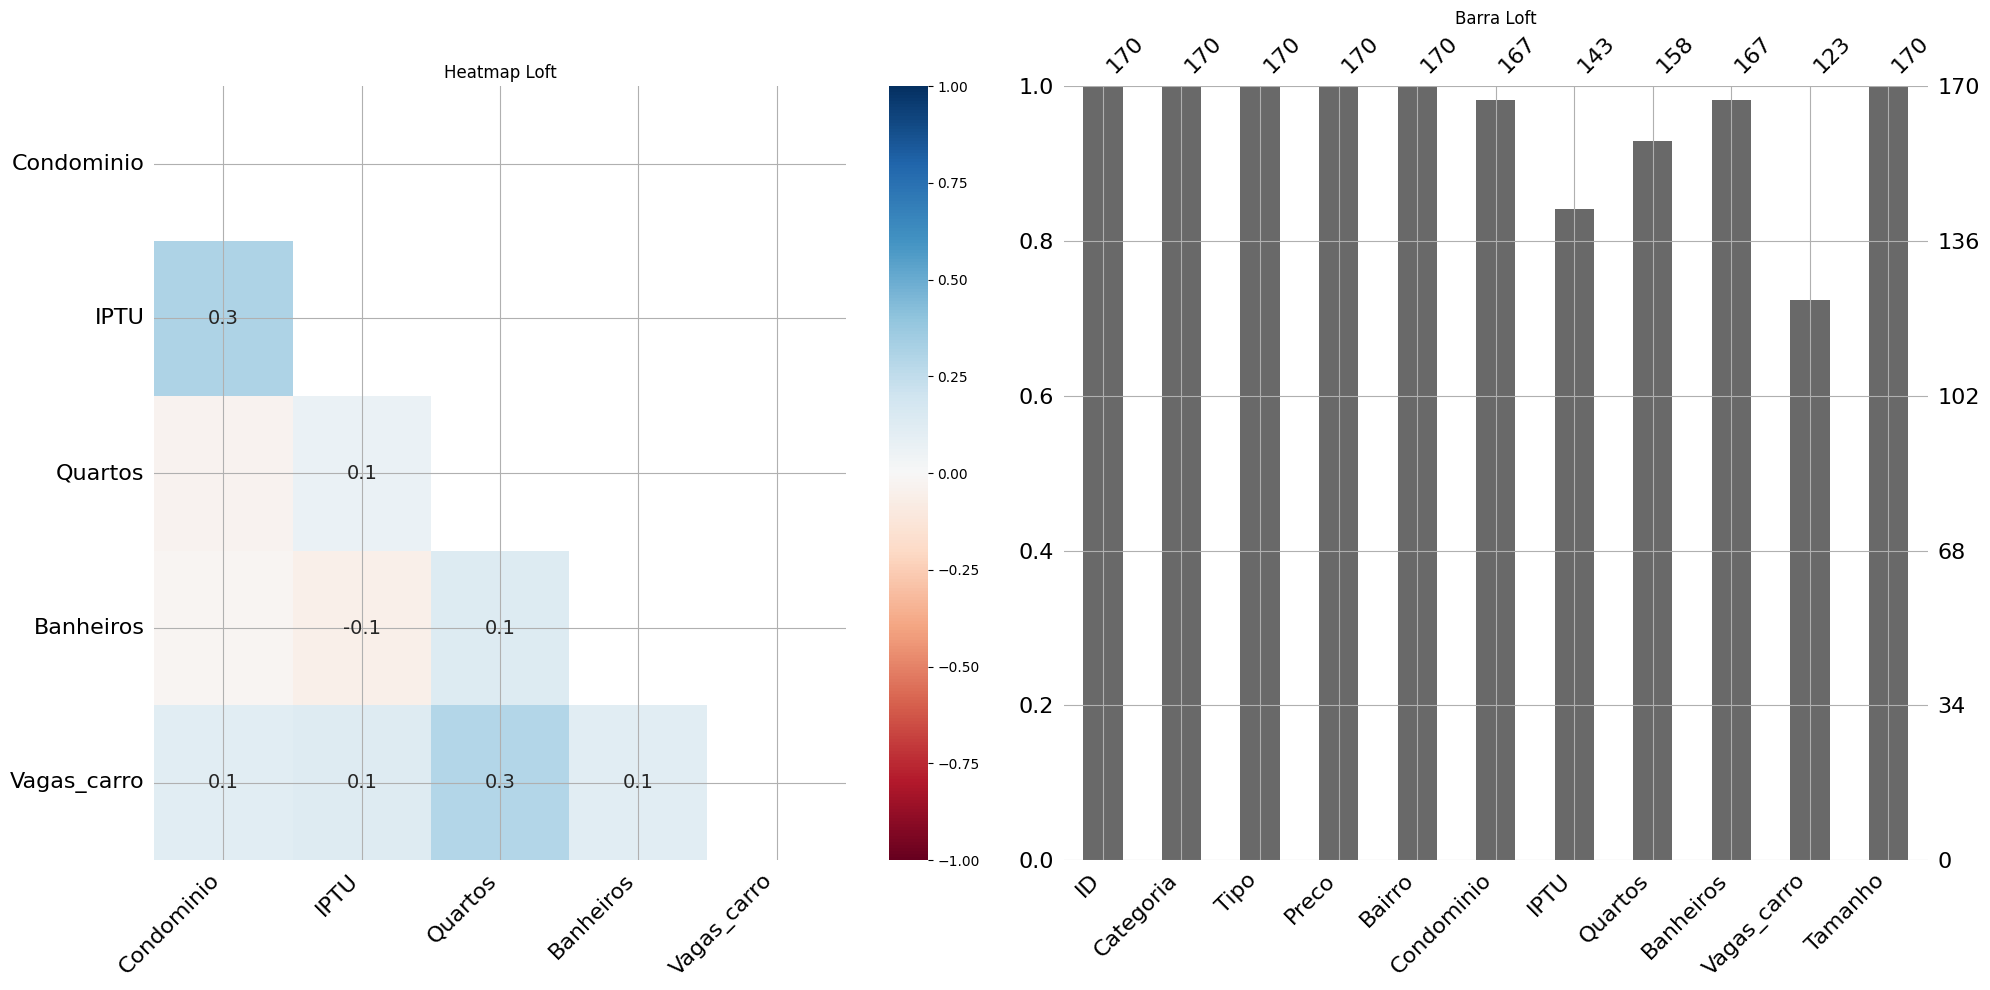

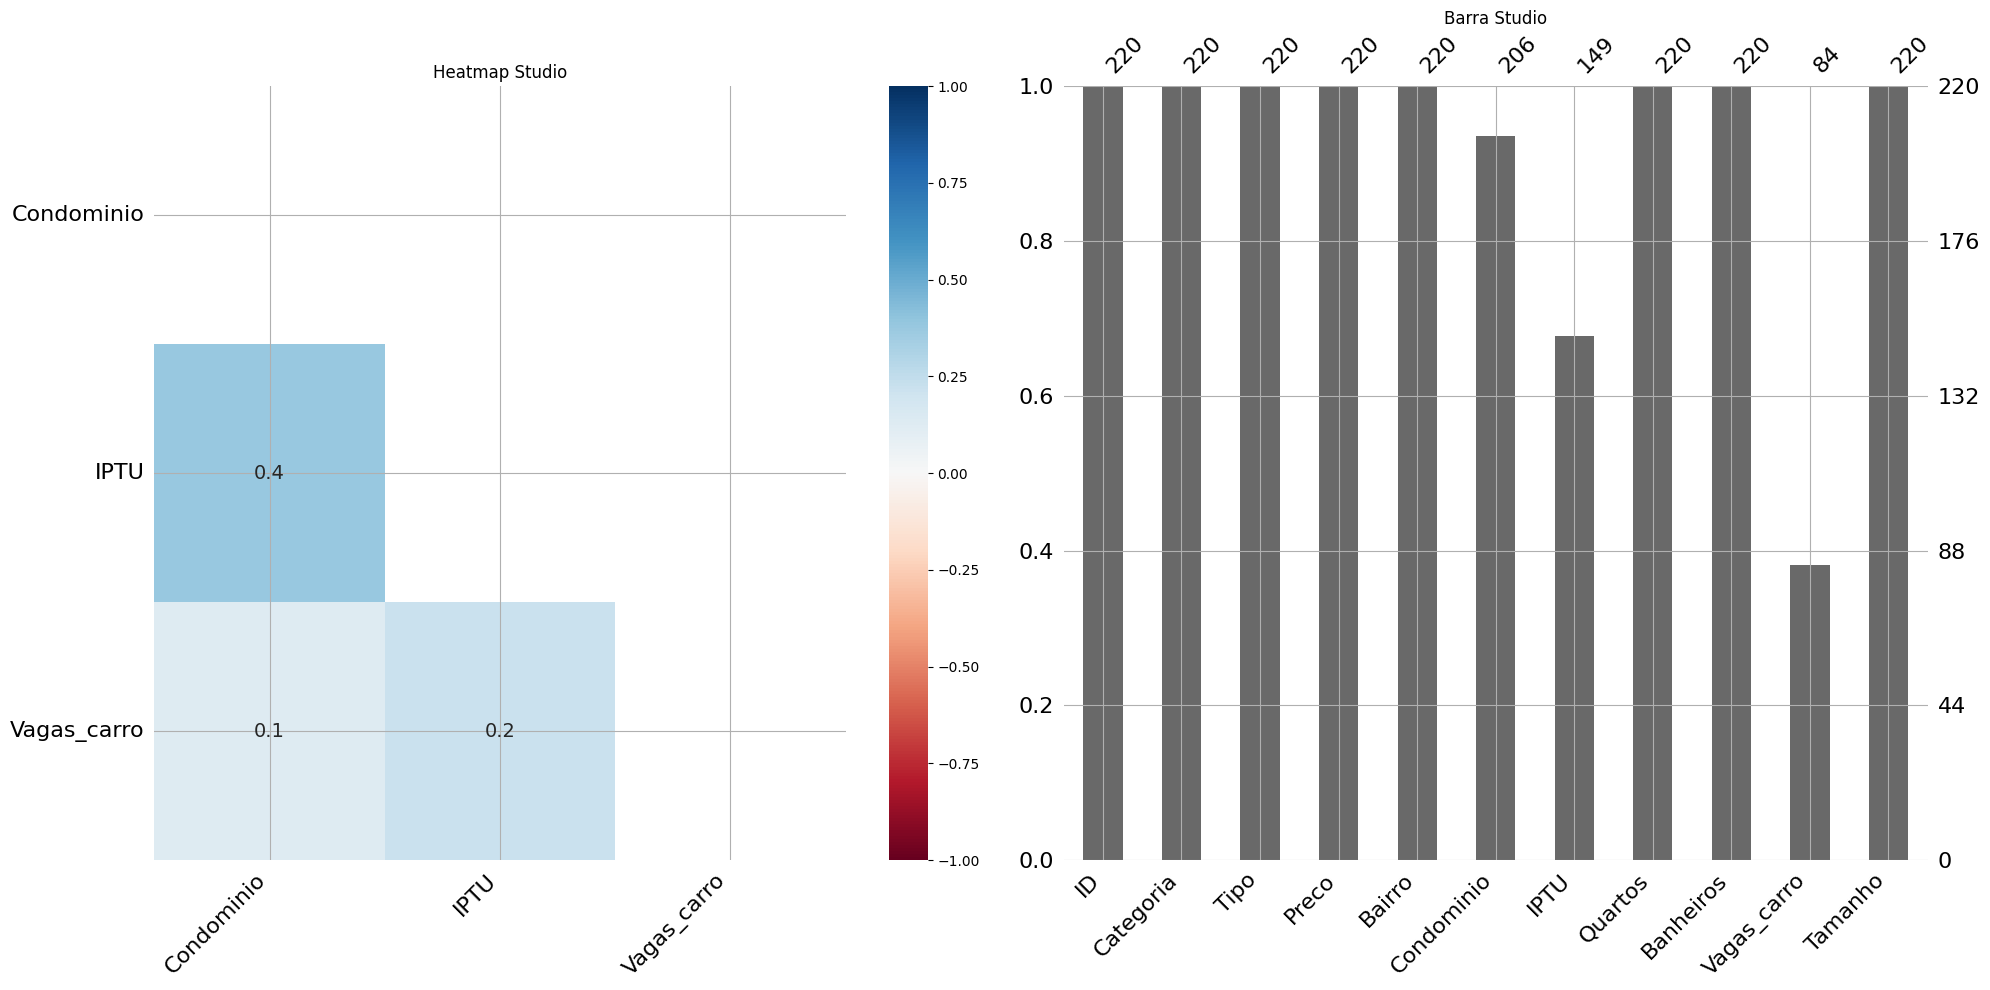

In [30]:
for i, val in enumerate(cat_list):
    figsize=(20, 10)
    fig, axes = plt.subplots(1, 2, figsize= figsize)
    ax1 = axes[0]
    ax2 = axes[1]

    df_filtered = df[df['Tipo'] == val]
    msno.heatmap(df=df_filtered, ax=ax1)    
    ax1.set_title(f'Heatmap {val}')
    ax1.grid(True)
    
    msno.bar(df=df[df['Tipo'] == val], ax=ax2)    
    ax2.set_title(f'Barra {val}')
    ax2.grid(True)

    plt.tight_layout()

plt.show()


The values follow a pattern similar to the category, where there is in almost all values a minimal correlation between IPTU and condominium. This is due to the fact that the variable category has a hierarchical relationship with type, being type a subgroup of the category. We will analyze how the distribution of continuous values vary among themselves.

/tmp/ipykernel_867752/398320104.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(group[['Preco','Condominio','IPTU', 'Tamanho']], ax=ax)


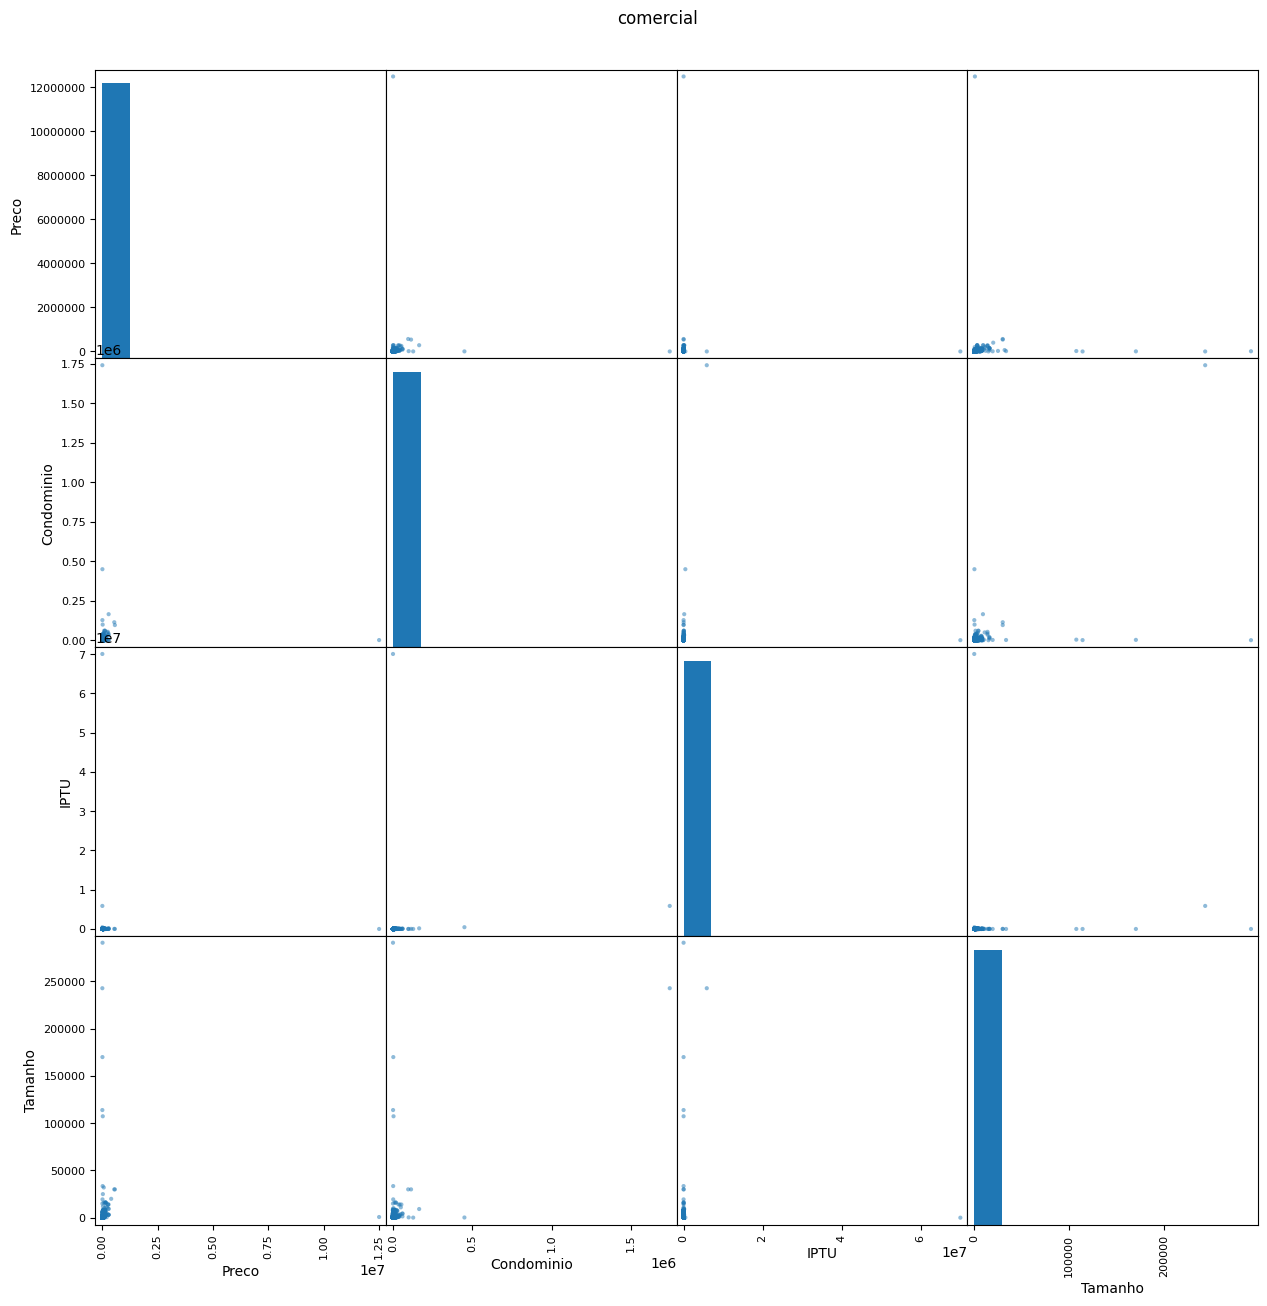

/tmp/ipykernel_867752/398320104.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(group[['Preco','Condominio','IPTU', 'Tamanho']], ax=ax)


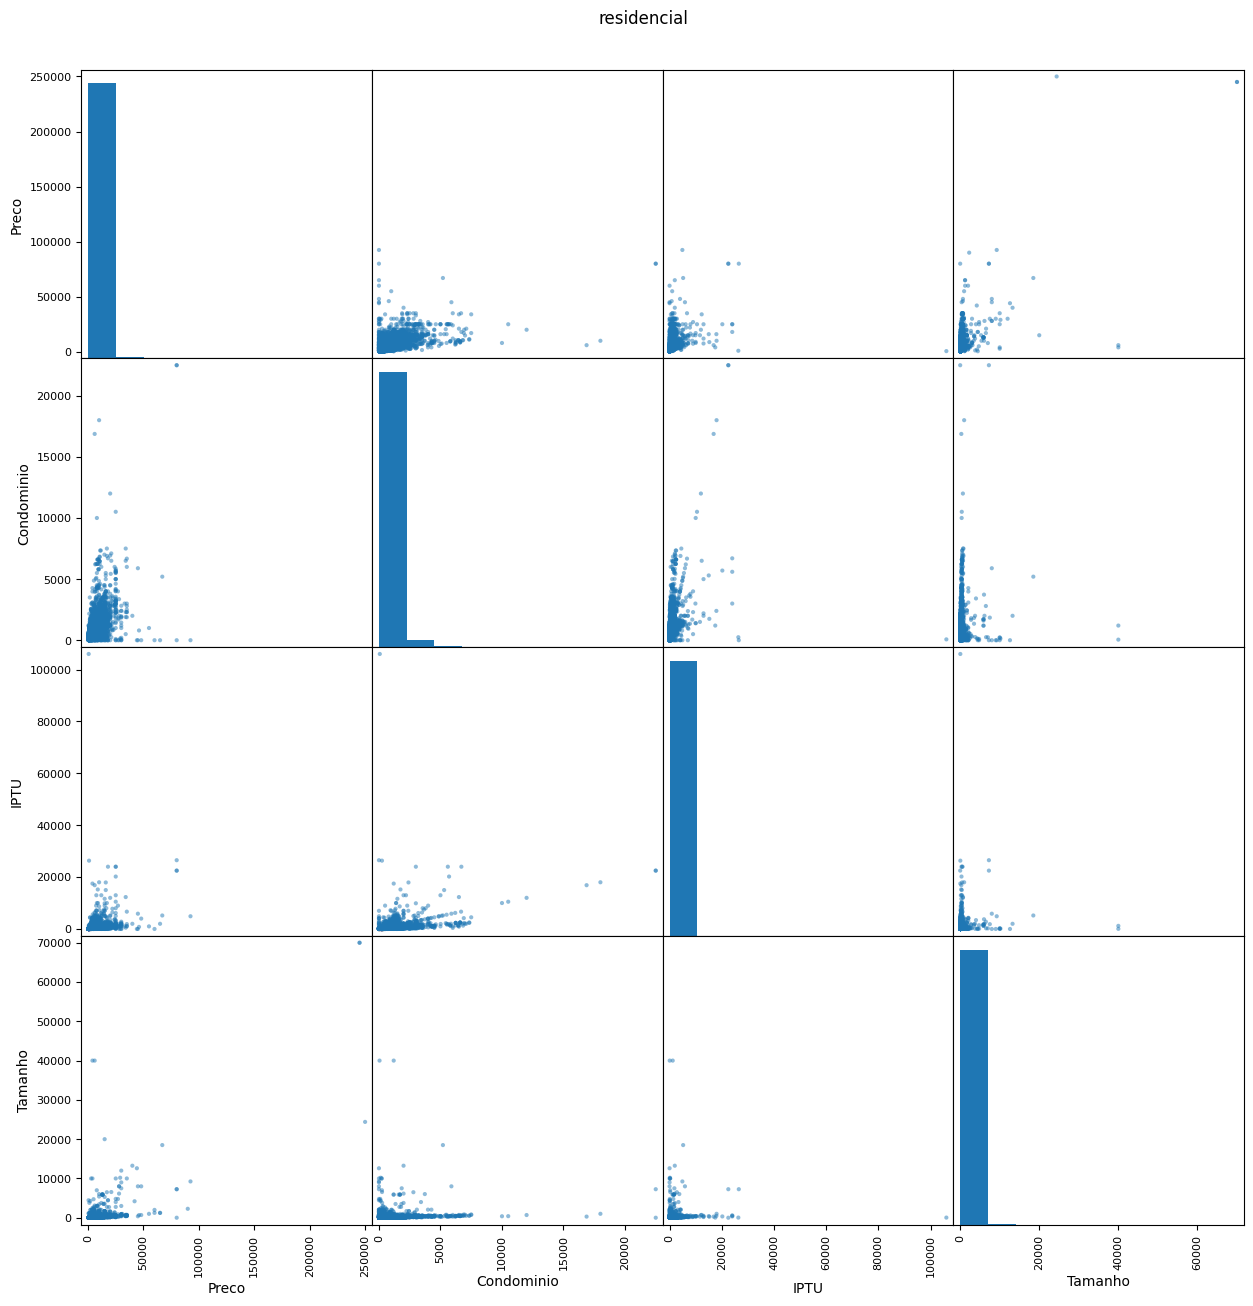

In [31]:
for cat, group in df.groupby('Categoria'):
    fig, ax = plt.subplots(figsize=(15, 15))
    pd.plotting.scatter_matrix(group[['Preco','Condominio','IPTU', 'Tamanho']], ax=ax)
    fig.suptitle(cat, y=0.92)
    plt.show()

We can see that for the residential values, the values seem to follow a linear variation, we will check for both using the pearson correlation.

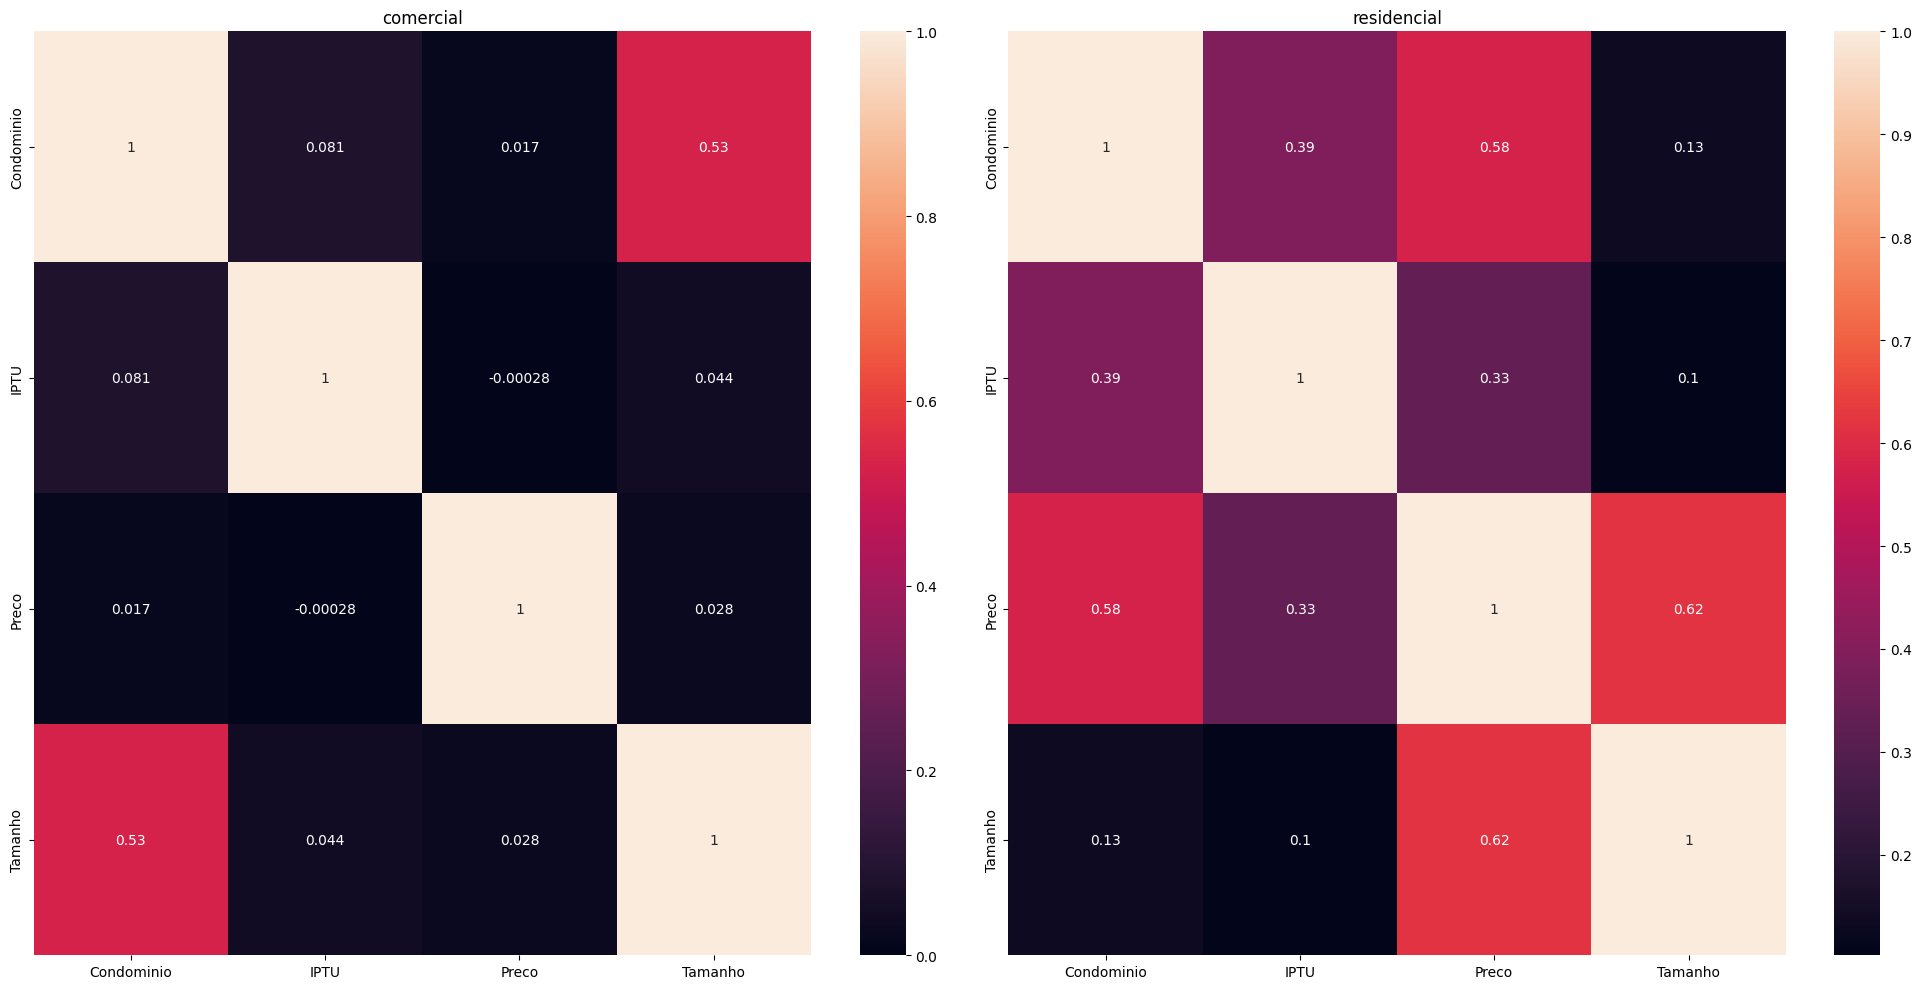

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=len(df['Categoria'].unique()), figsize=(20, 10))

for i, (cat, group) in enumerate(df.groupby('Categoria')):
    sns.heatmap(group[DATAFRAME_VAR['continuous']].corr(), ax=axes[i], annot=True) 
    axes[i].set_title(cat)

plt.tight_layout()
plt.show()


We can see that there is a relevant linear correlation between some values (x < -0.50 and x > 0.50). The variable "Car_Vacancies" has a large amount of null values in both categories, so we will consider removing it. Further analysis is needed to determine how the other null values will be handled.

## Analysis of numerical variables

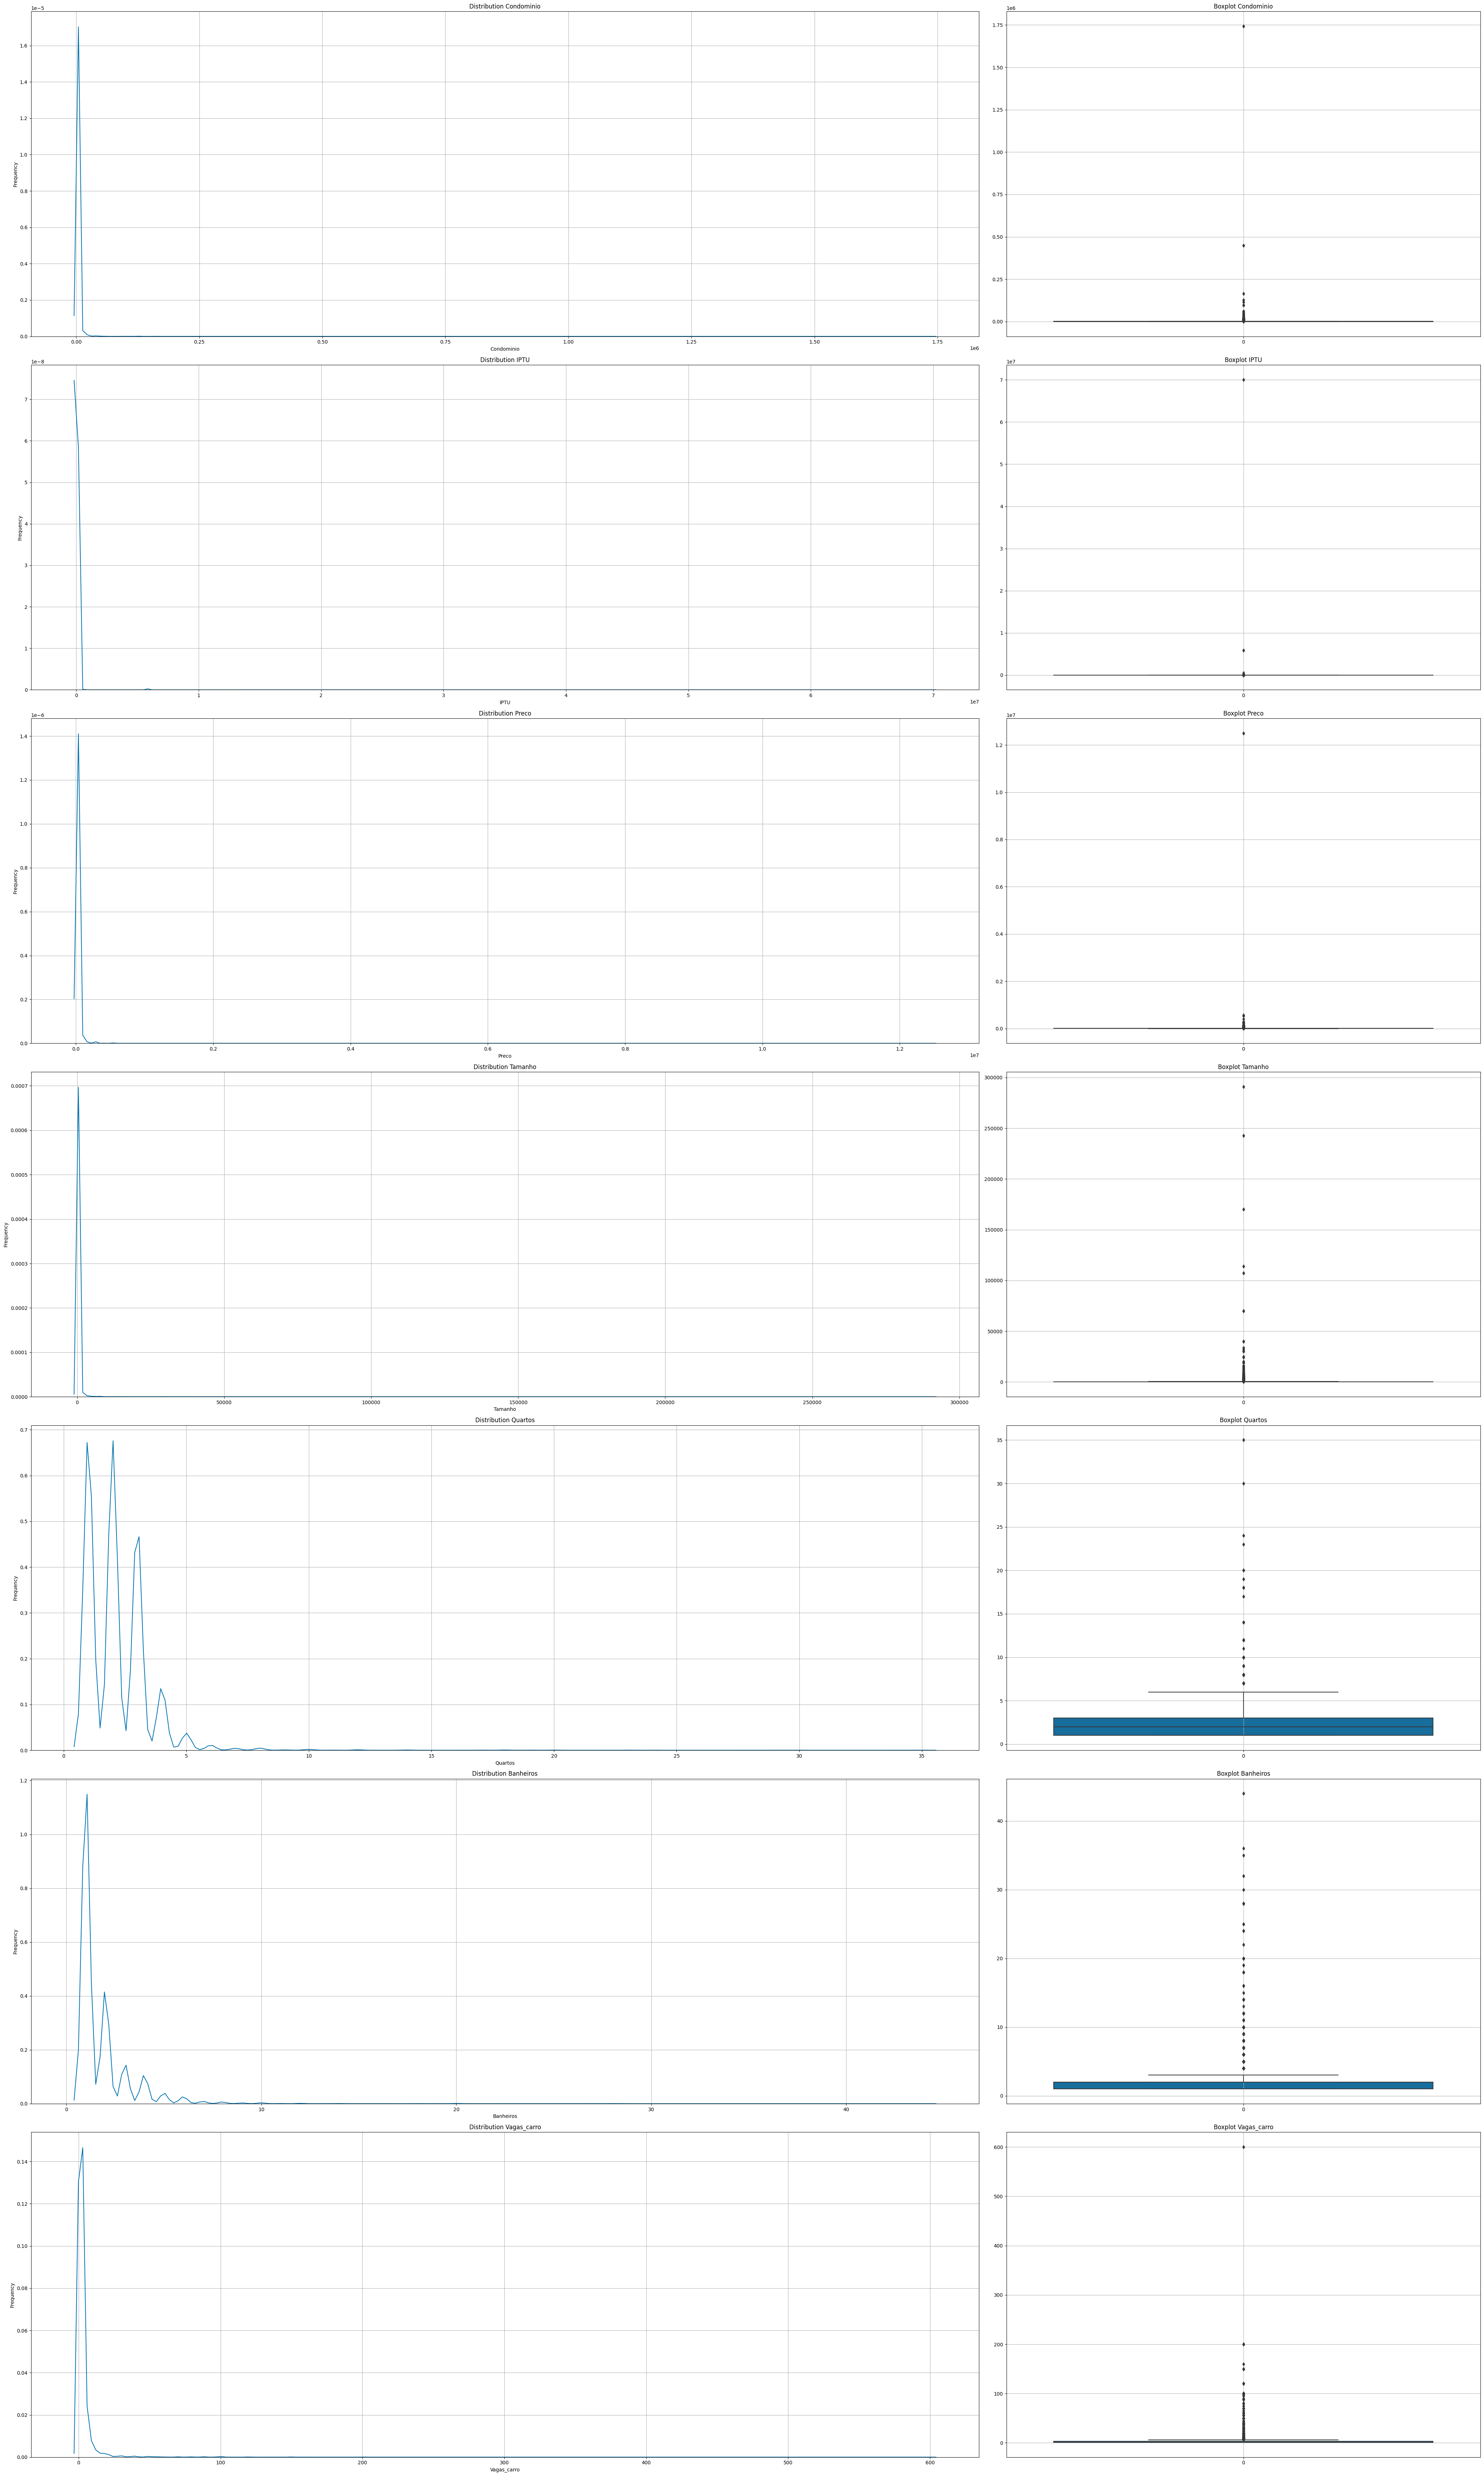

In [33]:
numeric_columns = DATAFRAME_VAR['continuous'] + DATAFRAME_VAR['discrete']
figsize=(6*len(numeric_columns), 10*len(numeric_columns))
sns.set_palette("colorblind")
fig, axes = plt.subplots(len(numeric_columns), 2, figsize= figsize, gridspec_kw={'width_ratios': [2, 1]})

for i, val in enumerate(numeric_columns):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    sns.kdeplot(data=df[val].astype(float), ax=ax1)
    ax1.set_xlabel(val)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Distribution {val}')
    ax1.grid(True)
    
    sns.boxplot(df[val], ax=ax2)
    ax2.set_title(f'Boxplot {val}')
    ax2.grid(True)


plt.tight_layout()
plt.show()


You can see the positive asymmetry and a long tail, indicating the presence of outliers. You can also see a very small spread in the interquartile range. We noticed a difference between the null values between the two groups in the category, so we will analyze both separately.

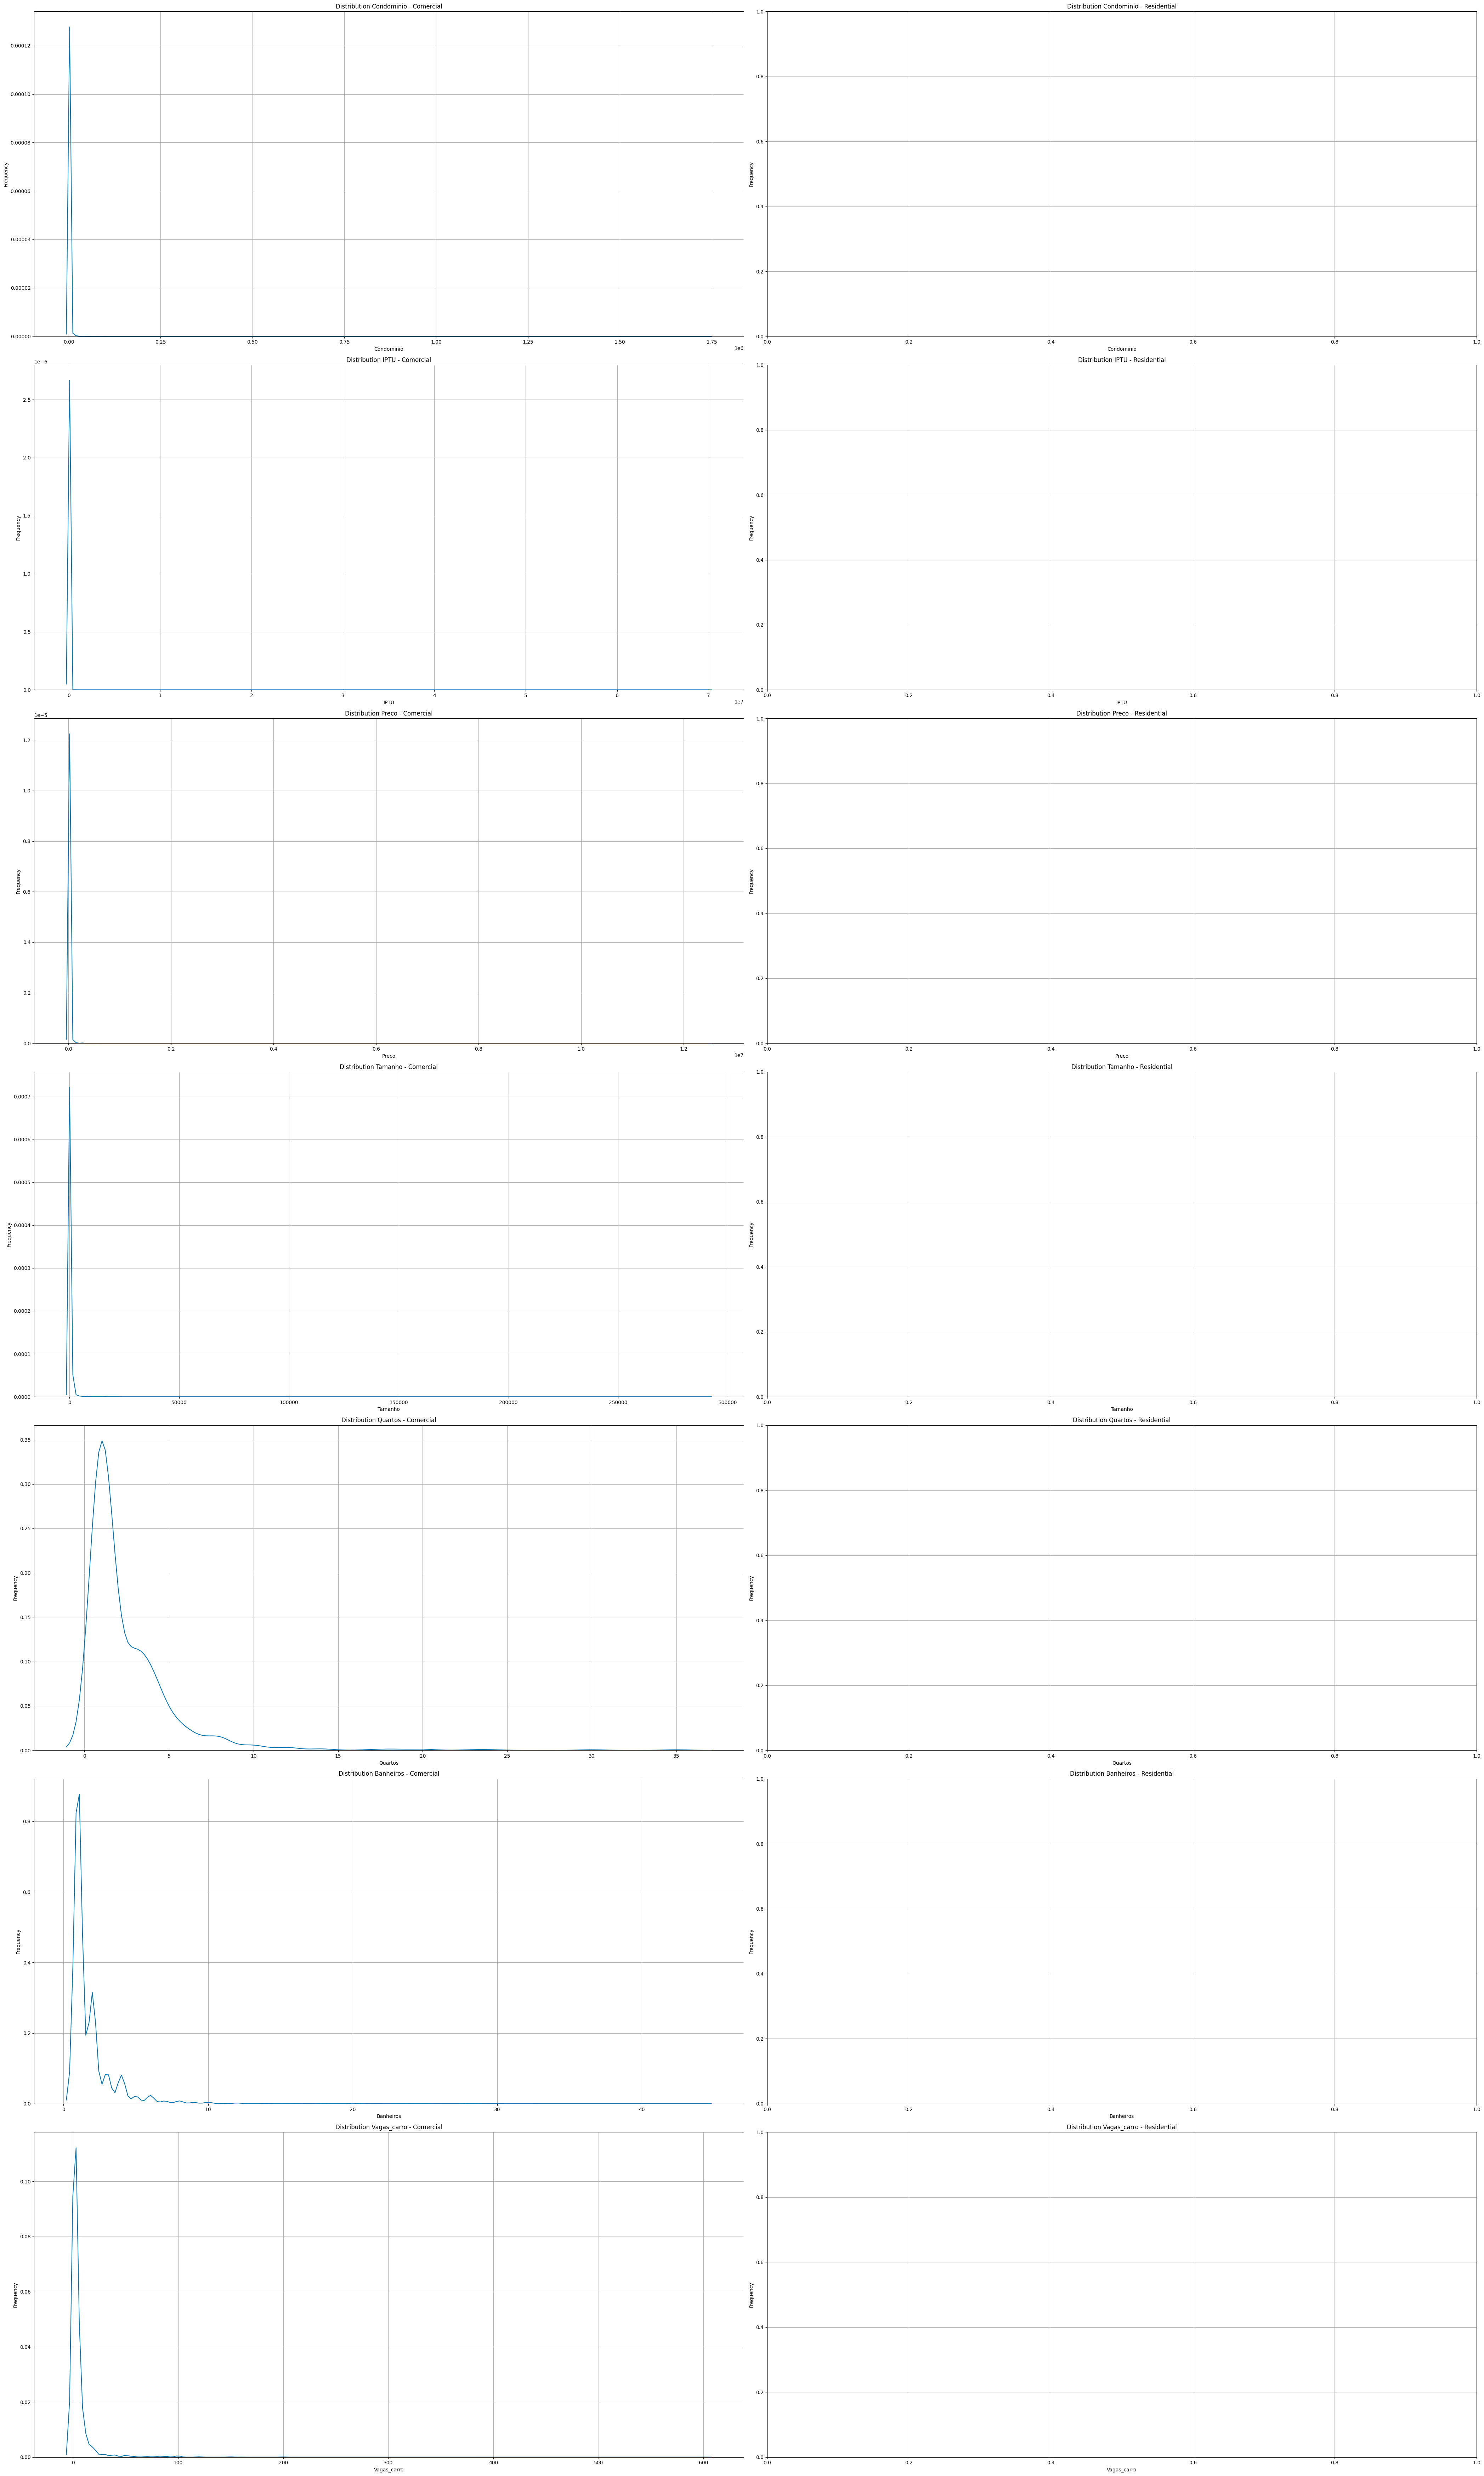

In [34]:
figsize=(6*len(numeric_columns), 10*len(numeric_columns))
sns.set_palette("colorblind")
fig, axes = plt.subplots(len(numeric_columns), 2, figsize= figsize)

for i, val in enumerate(numeric_columns):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    sns.kdeplot(data=df[df['Categoria'] == 'comercial'][val].astype(float), ax=ax1)
    ax1.set_xlabel(val)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Distribution {val} - Comercial')
    ax1.grid(True)
    sns.kdeplot(data=df[df['Categoria'] == 'Residential'][val].astype(float), ax=ax2)
    ax2.set_xlabel(val)
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Distribution {val} - Residential')
    ax2.grid(True)


plt.tight_layout()
plt.show()


We can see differences between the measures of central tendency in the kernel density estimation plot. To better understand this we will look at these measures directly.

In [35]:
pd.set_option('display.float_format', '{:.2e}'.format)
df.groupby('Categoria')[DATAFRAME_VAR['continuous']].describe().transpose()

Categoria         comercial  residencial
Condominio count   1.57e+04     1.26e+04
           mean    1.25e+03     6.02e+02
           std     1.47e+04     7.67e+02
           min     1.00e+00     1.00e+00
           25%     3.00e+02     2.58e+02
           50%     5.40e+02     4.00e+02
           75%     1.00e+03     6.50e+02
           max     1.74e+06     2.25e+04
IPTU       count   1.41e+04     1.14e+04
           mean    6.18e+03     3.16e+02
           std     5.93e+05     1.41e+03
           min     1.00e+00     1.00e+00
           25%     1.16e+02     4.70e+01
           50%     2.40e+02     1.00e+02
           75%     6.24e+02     2.43e+02
           max     7.00e+07     1.06e+05
Preco      count   1.78e+04     1.32e+04
           mean    7.93e+03     3.60e+03
           std     9.48e+04     5.85e+03
           min     1.00e+02     2.75e+02
           25%     1.35e+03     1.20e+03
           50%     2.90e+03     2.20e+03
           75%     8.00e+03     4.00e+03
           max     1.25e+07     2.50e+05
Tamanho    count   1.78e+04     1.32e+04
           mean    3.18e+02     1.70e+02
           std     3.44e+03     1.13e+03
           min     1.00e+00     1.00e+01
           25%     3.90e+01     4.60e+01
           50%     7.60e+01     7.00e+01
           75%     2.46e+02     1.30e+02
           max     2.91e+05     7.00e+04

In [36]:
df.groupby('Categoria')[DATAFRAME_VAR['discrete']].describe().transpose()

Categoria          comercial  residencial
Quartos     count   1.19e+03     1.27e+04
            mean    2.51e+00     2.14e+00
            std     2.83e+00     1.04e+00
            min     1.00e+00     1.00e+00
            25%     1.00e+00     1.00e+00
            50%     1.00e+00     2.00e+00
            75%     3.00e+00     3.00e+00
            max     3.50e+01     1.80e+01
Banheiros   count   1.44e+04     1.29e+04
            mean    1.82e+00     1.76e+00
            std     1.82e+00     1.19e+00
            min     1.00e+00     1.00e+00
            25%     1.00e+00     1.00e+00
            50%     1.00e+00     1.00e+00
            75%     2.00e+00     2.00e+00
            max     4.40e+01     1.10e+01
Vagas_carro count   6.13e+03     8.20e+03
            mean    4.90e+00     1.84e+00
            std     1.41e+01     1.82e+00
            min     1.00e+00     1.00e+00
            25%     1.00e+00     1.00e+00
            50%     2.00e+00     1.00e+00
            75%     4.00e+00     2.00e+00
            max     6.00e+02     6.20e+01

When comparing the two groups, "commercial" and "residential", we can observe some differences in the variables analyzed. Regarding "Price", the "commercial" group has a higher number of observations compared to the "residential" group. The average price for the "commercial" group is significantly higher, indicating that commercial properties tend to have higher prices on average. The standard deviation of prices is also higher for the "commercial" group, suggesting a greater variation of prices within this group.

When analyzing the "Condominium" values, the "commercial" group again has a larger number of observations. The average value of the condominium is higher for the "commercial" group compared to the "residential" group. Similarly, the standard deviation of the condominium values is higher for the "commercial" group, indicating greater variability in condominium fees within this group.

With regard to the "IPTU" variable, we observe that the "commercial" group has a larger number of observations. The average value of IPTU is considerably higher for the "commercial" group compared to the "residential" group. In addition, the standard deviation of the IPTU values is much higher for the "commercial" group, suggesting a greater variation in IPTU values within this group.

Finally, considering the variable "Size", the "commercial" group has a larger number of observations. The average size for the "commercial" group is larger compared to the "residential" group. The standard deviation of the sizes is also larger for the "commercial" group, indicating a greater variation in the sizes of the properties within this group.

Therefore, future analyses will be done separately between the two groups.

In [37]:
pd.set_option('display.float_format', '{:.3f}'.format)

We will analyze the skewness and kurtosis of each group

In [38]:
# Group the dataframe by 'Categoria' and calculate skewness and kurtosis for each group
grouped = df.groupby('Categoria', group_keys=True)
skewness = grouped[['Preco', 'Condominio', 'IPTU', 'Tamanho']].skew()
kurtosis = grouped[['Preco', 'Condominio', 'IPTU', 'Tamanho']].apply(pd.DataFrame.kurt)
values_original = pd.concat([skewness, kurtosis], axis=1, keys=['Asymmetry', 'Kurtosis'])
values_original

Asymmetry                             Kurtosis             \
                Preco Condominio    IPTU Tamanho     Preco Condominio   
Categoria                                                               
comercial     128.591    108.069 117.415  64.540 16936.907  12610.011   
residencial    18.976      8.641  42.178  44.457   699.079    163.150   

                                
                 IPTU  Tamanho  
Categoria                       
comercial   13868.341 4722.427  
residencial  2848.323 2444.960

They are extremely high, so we will use the box-cox transformation to reduce these values.

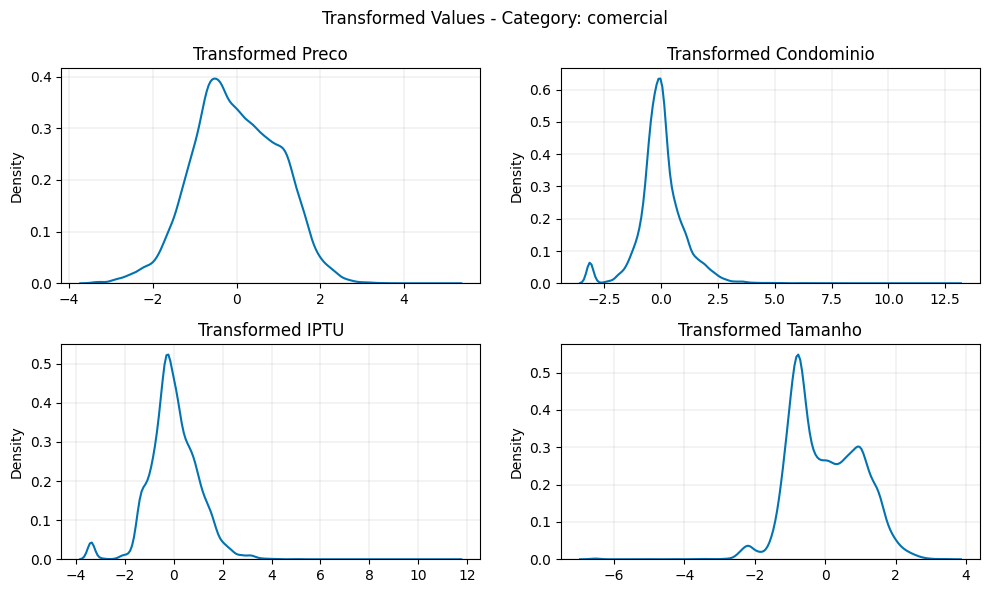

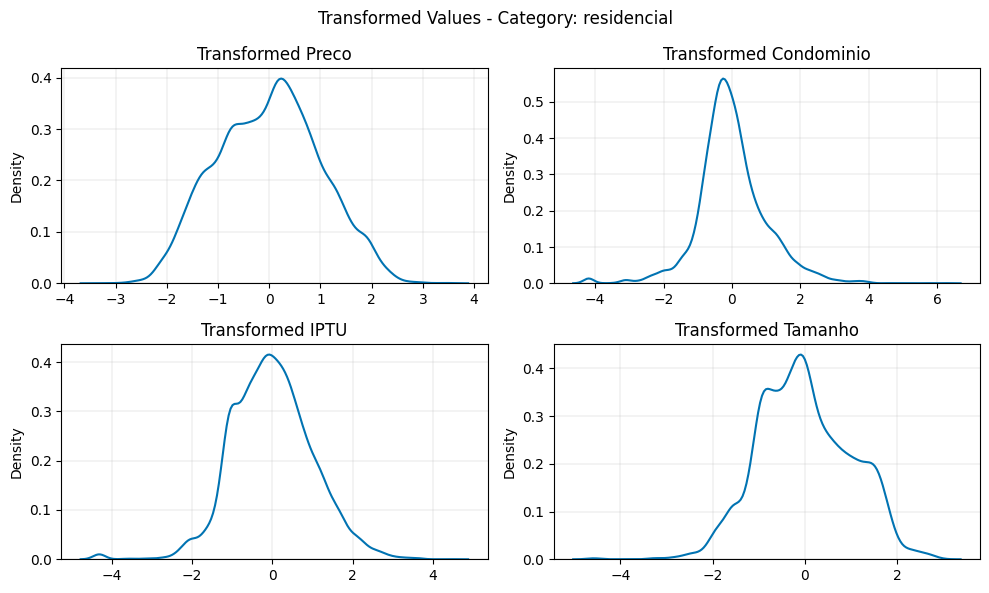

Skewness                           Kurtosis                   \
               Preco Condominio   IPTU Tamanho    Preco Condominio  IPTU   
comercial      0.011      0.283  0.063  -0.004   -0.289      5.215 3.259   
residencial    0.036      0.160 -0.028   0.045   -0.526      2.775 1.137   

                     
            Tamanho  
comercial     0.629  
residencial  -0.086

In [39]:
from sklearn.preprocessing import PowerTransformer

skewness_dict_boxcox = {}
kurtosis_dict_boxcox = {}
power = PowerTransformer(method='box-cox', standardize=True)

for cat, group in grouped:
    data_trans = power.fit_transform(group[['Preco', 'Condominio', 'IPTU', 'Tamanho']])
    skewness = pd.DataFrame(data_trans, columns=['Preco', 'Condominio', 'IPTU', 'Tamanho']).skew()
    kurtosis = pd.DataFrame(data_trans, columns=['Preco', 'Condominio', 'IPTU', 'Tamanho']).kurt()
    skewness_dict_boxcox[cat] = skewness
    kurtosis_dict_boxcox[cat] = kurtosis

    # Create dataframes from dictionaries
    skewness_boxcox = pd.DataFrame(skewness_dict_boxcox).transpose()
    kurtosis_boxcox = pd.DataFrame(kurtosis_dict_boxcox).transpose()

    # Combine skewness and kurtosis dataframes
    values_boxcox = pd.concat([skewness_boxcox, kurtosis_boxcox], axis=1, keys=['Skewness', 'Kurtosis'])

    # Plot the transformed values
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 2, 1)
    sns.kdeplot(data = data_trans[:, 0])  # Preco
    plt.title('Transformed Preco')
    plt.grid(visible=True, linewidth = 0.2)

    plt.subplot(2, 2, 2)
    sns.kdeplot(data = data_trans[:, 1])  # Condominio
    plt.title('Transformed Condominio')
    plt.grid(visible=True, linewidth = 0.2)

    plt.subplot(2, 2, 3)
    sns.kdeplot(data = data_trans[:, 2])  # IPTU
    plt.title('Transformed IPTU')
    plt.grid(visible=True, linewidth = 0.2)

    plt.subplot(2, 2, 4)
    sns.kdeplot(data = data_trans[:, 3])  # Tamanho
    plt.title('Transformed Tamanho')
    plt.grid(visible=True, linewidth = 0.2)

    plt.suptitle(f'Transformed Values - Category: {cat}')
    plt.tight_layout()
    plt.show()


values_boxcox

It is possible to see the reduction of the asymmetry and kurtosis values, however there are still outliers present, and we will analyze them now.

## Outlier Analysis

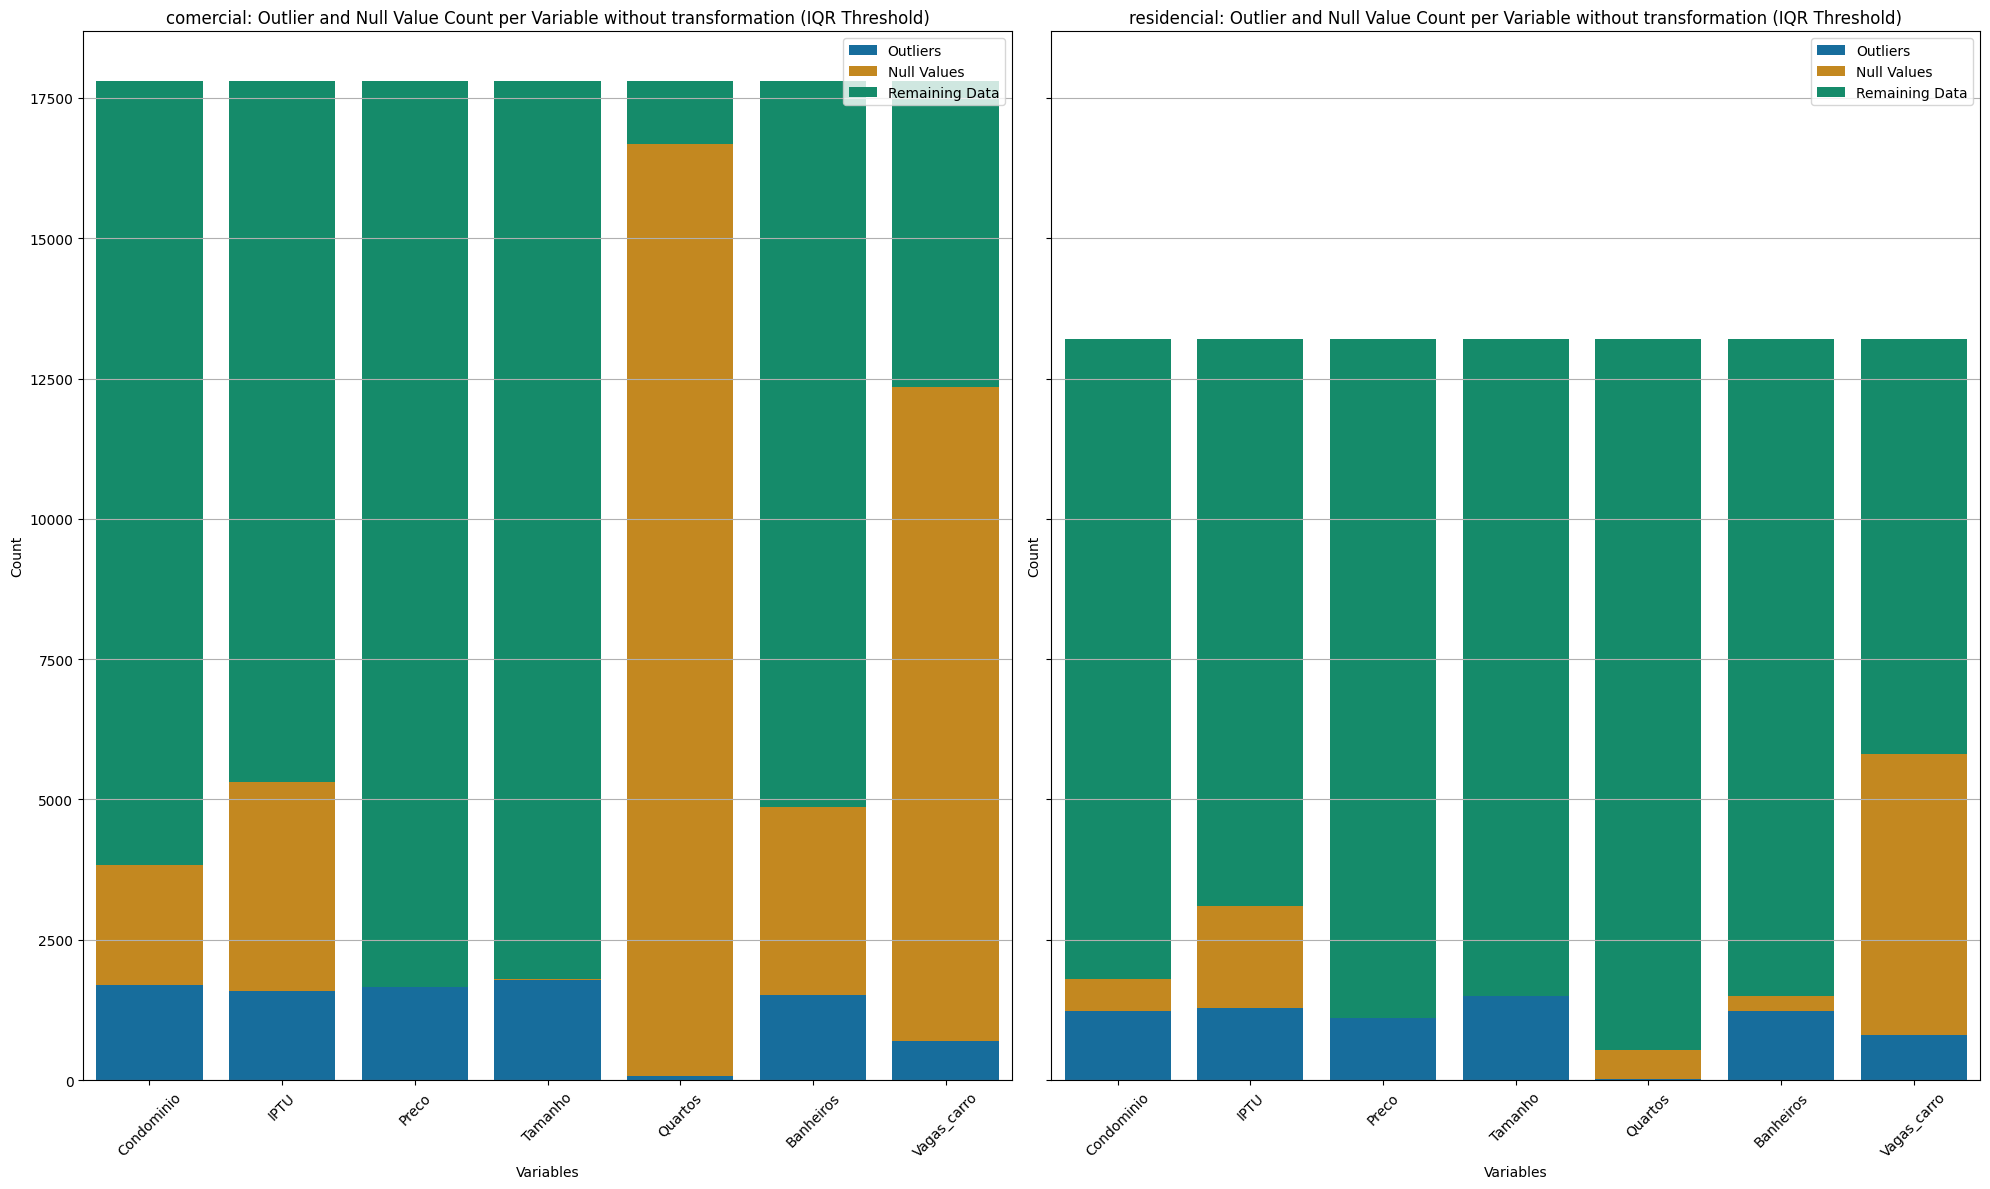

In [40]:
# Create the subplots using seaborn colorblind palette
sns.set_palette("colorblind")
fig, axs = plt.subplots(nrows=1, ncols=len(df['Categoria'].unique()), figsize=(20, 12), sharey=True)
outlier_cols = [col for col in DATAFRAME_VAR['continuous'] if col != 'IDH'] + DATAFRAME_VAR['discrete']

for i, (cat, group) in enumerate(df.groupby('Categoria')):
    # Calculate the IQR for each variable
    Q1 = group[outlier_cols].quantile(0.25)
    Q3 = group[outlier_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Define the threshold to identify outliers
    outlier_threshold = 1.5

    # Calculate the number of outliers and null values for each variable
    outlier_counts = []
    for column in outlier_cols:
        outliers = ((group[column] < Q1[column] - outlier_threshold * IQR[column]) |
                    (group[column] > Q3[column] + outlier_threshold * IQR[column]))
        outlier_counts.append(outliers.sum())

    null_counts = group[outlier_cols].isnull().sum()
    rest = len(group) - (null_counts + outlier_counts)

    # Set up the data for the bar chart
    variables = outlier_cols
    x = np.arange(len(variables))
    bar_width = 0.35

    # Create the bar chart
    ax = axs[i]

    # Plot the outliers
    sns.barplot(x=x, y=outlier_counts, color=sns.color_palette()[0], ax=ax, label='Outliers')

    # Plot the null values
    sns.barplot(x=x, y=null_counts, color=sns.color_palette()[1], ax=ax, label='Null Values', bottom=outlier_counts)

    # Plot the rest of the data
    sns.barplot(x=x, y=rest, color=sns.color_palette()[2], ax=ax, label='Remaining Data', bottom=outlier_counts + null_counts)

    # Configure the axes, labels and chart title
    ax.set_xlabel('Variables')
    ax.set_ylabel('Count')
    ax.set_title(f'{cat}: Outlier and Null Value Count per Variable without transformation (IQR Threshold)')
    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=45)
    ax.legend()
    ax.grid(True, axis='y')

# Adjust the subplot positions and spacing
plt.subplots_adjust(wspace=0.3)
# Display the chart
plt.tight_layout()
plt.show()


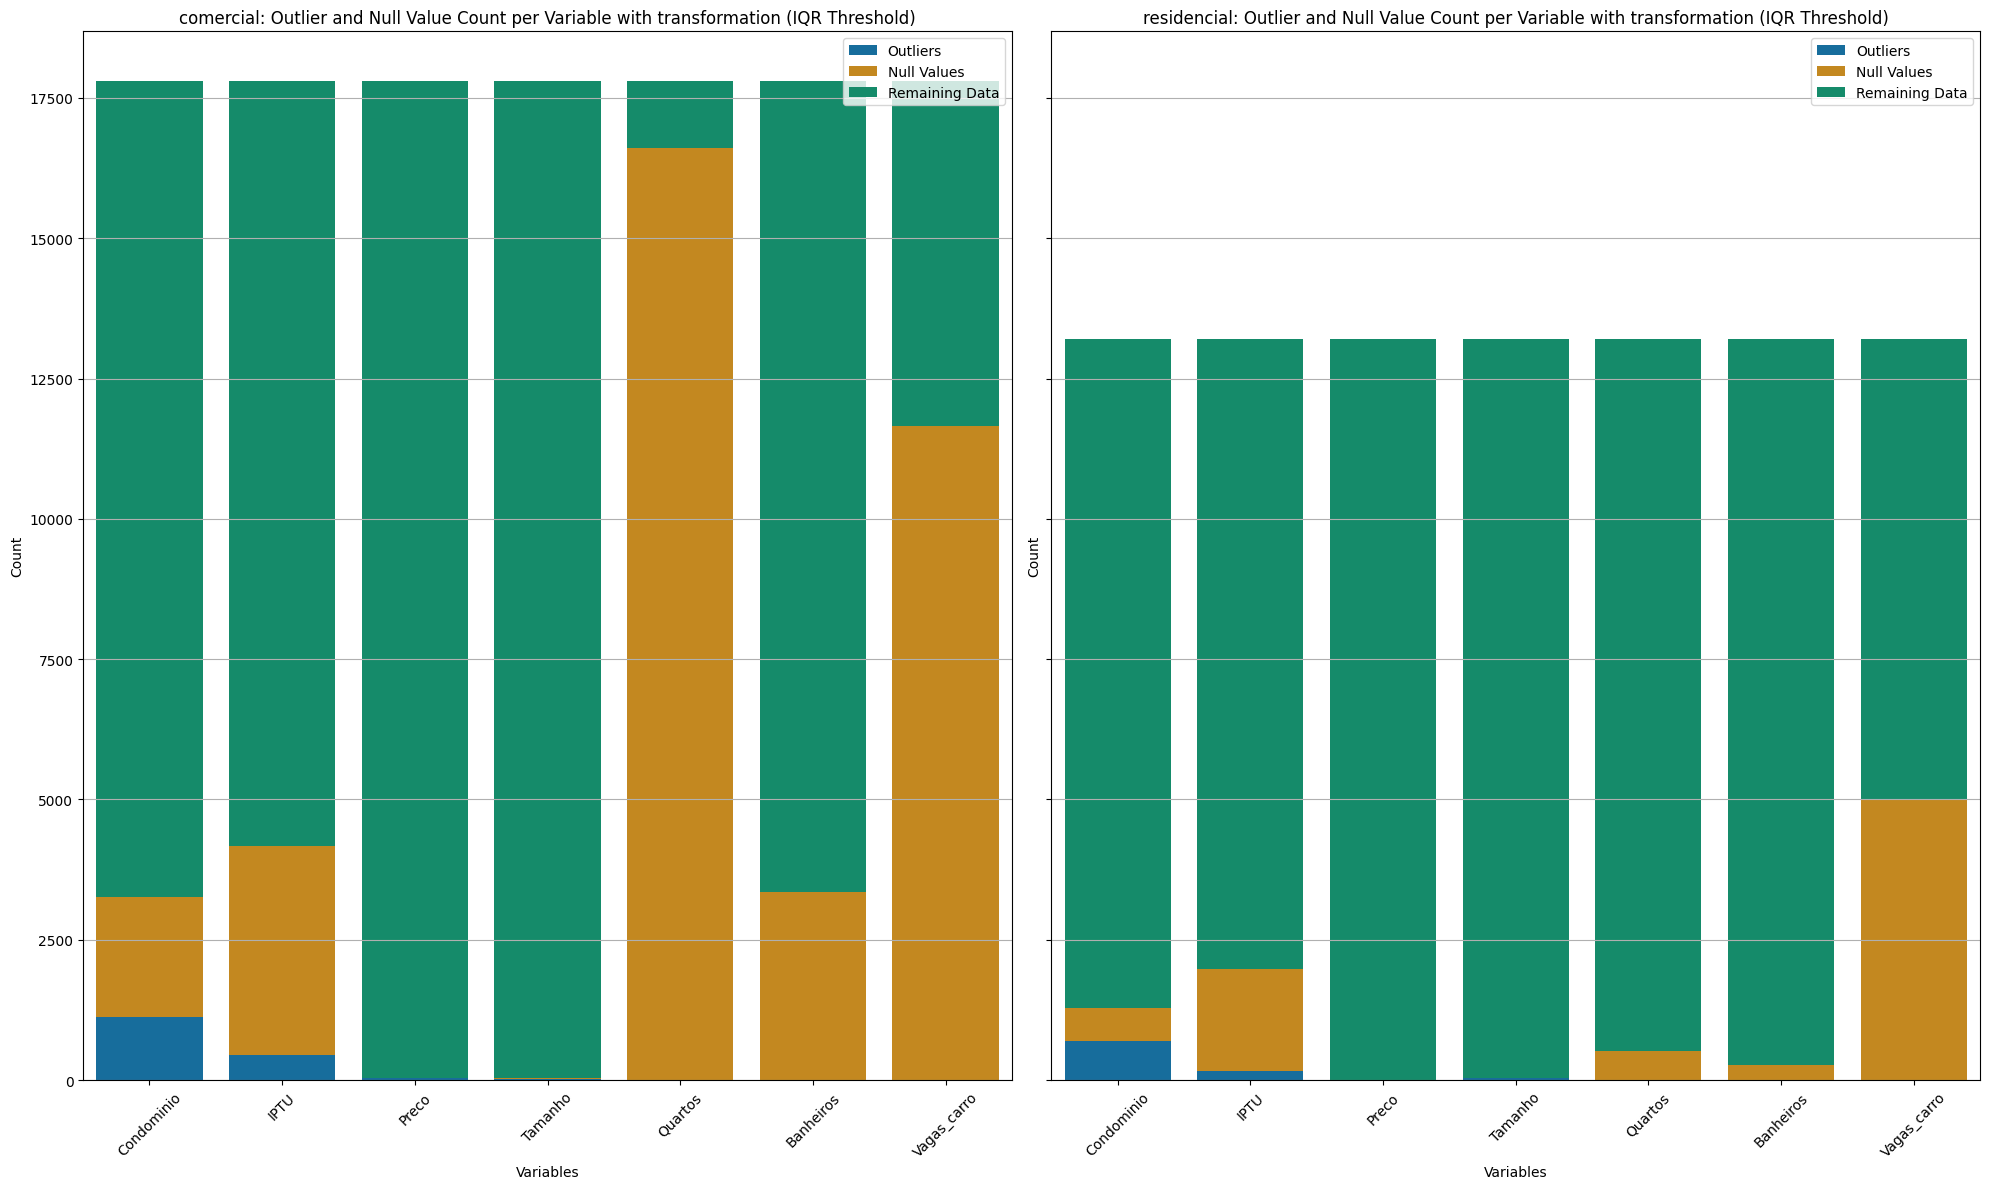

In [41]:
# Create the subplots using seaborn colorblind palette
sns.set_palette("colorblind")
fig, axs = plt.subplots(nrows=1, ncols=len(df['Categoria'].unique()), figsize=(20, 12), sharey=True)

for i, (cat, group) in enumerate(df.groupby('Categoria')):

    data_trans = pd.DataFrame(power.fit_transform(group[outlier_cols]), columns=outlier_cols)

    # Calculate the IQR for each variable
    Q1 = data_trans[outlier_cols].quantile(0.25)
    Q3 = data_trans[outlier_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Define the threshold to identify outliers
    outlier_threshold = 1.5

    # Calculate the number of outliers and null values for each variable
    outlier_counts = []
    for column in outlier_cols:
        outliers = ((data_trans[column] < Q1[column] - outlier_threshold * IQR[column]) |
                    (data_trans[column] > Q3[column] + outlier_threshold * IQR[column]))
        outlier_counts.append(outliers.sum())

    null_counts = data_trans[outlier_cols].isnull().sum()
    rest = len(data_trans) - (null_counts + outlier_counts)

    # Set up the data for the bar chart
    variables = outlier_cols
    x = np.arange(len(variables))
    bar_width = 0.35

    # Create the bar chart
    ax = axs[i]

    # Plot the outliers
    sns.barplot(x=x, y=outlier_counts, color=sns.color_palette()[0], ax=ax, label='Outliers')

    # Plot the null values
    sns.barplot(x=x, y=null_counts, color=sns.color_palette()[1], ax=ax, label='Null Values', bottom=outlier_counts)

    # Plot the rest of the data
    sns.barplot(x=x, y=rest, color=sns.color_palette()[2], ax=ax, label='Remaining Data', bottom=outlier_counts + null_counts)

    # Configure the axes, labels and chart title
    ax.set_xlabel('Variables')
    ax.set_ylabel('Count')
    ax.set_title(f'{cat}: Outlier and Null Value Count per Variable with transformation (IQR Threshold)')
    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=45)
    ax.legend()
    ax.grid(True, axis='y')

# Adjust the subplot positions and spacing
plt.subplots_adjust(wspace=0.3)

# Display the chart
plt.tight_layout()
plt.show()

Based on the IQR, when analyzing the relationship between null values and outliers in the different variables, we observe some trends. In general, there seems to be an association between the presence of outliers and the occurrence of null values in some variables.

For the variables Condominio and IPTU, both categories (commercial and residential) present a considerable amount of outliers and a significant percentage of null values. This may indicate a lack of information or inconsistencies in the data, which results in missing values and possible distortions in the extremes.

On the other hand, for variables such as Price and Size, although there are outliers present, the absence of null values indicates that the data is more complete and can provide a more reliable representation of the Distribution of these variables.

For the variables Bedrooms, Bathrooms and Car_Vacancies, we observed both outliers and null values, but with different proportions among the categories. This may suggest that certain groups or property types have a higher probability of presenting both outliers and missing information.

When you apply the Box-Cox transformation to a variable, you can see a difference in the amount of outliers. The Box-Cox transformation has the ability to adjust the distribution of the data to a form closer to normality, which can result in a reduction in extreme values and, consequently, a decrease in the number of outliers.

## Categorical variable analysis

In [42]:
df[DATAFRAME_VAR['categorical']].nunique()

ID           30991
Categoria        2
Tipo            20
Bairro         110
dtype: int64

Neighborhood Analysis

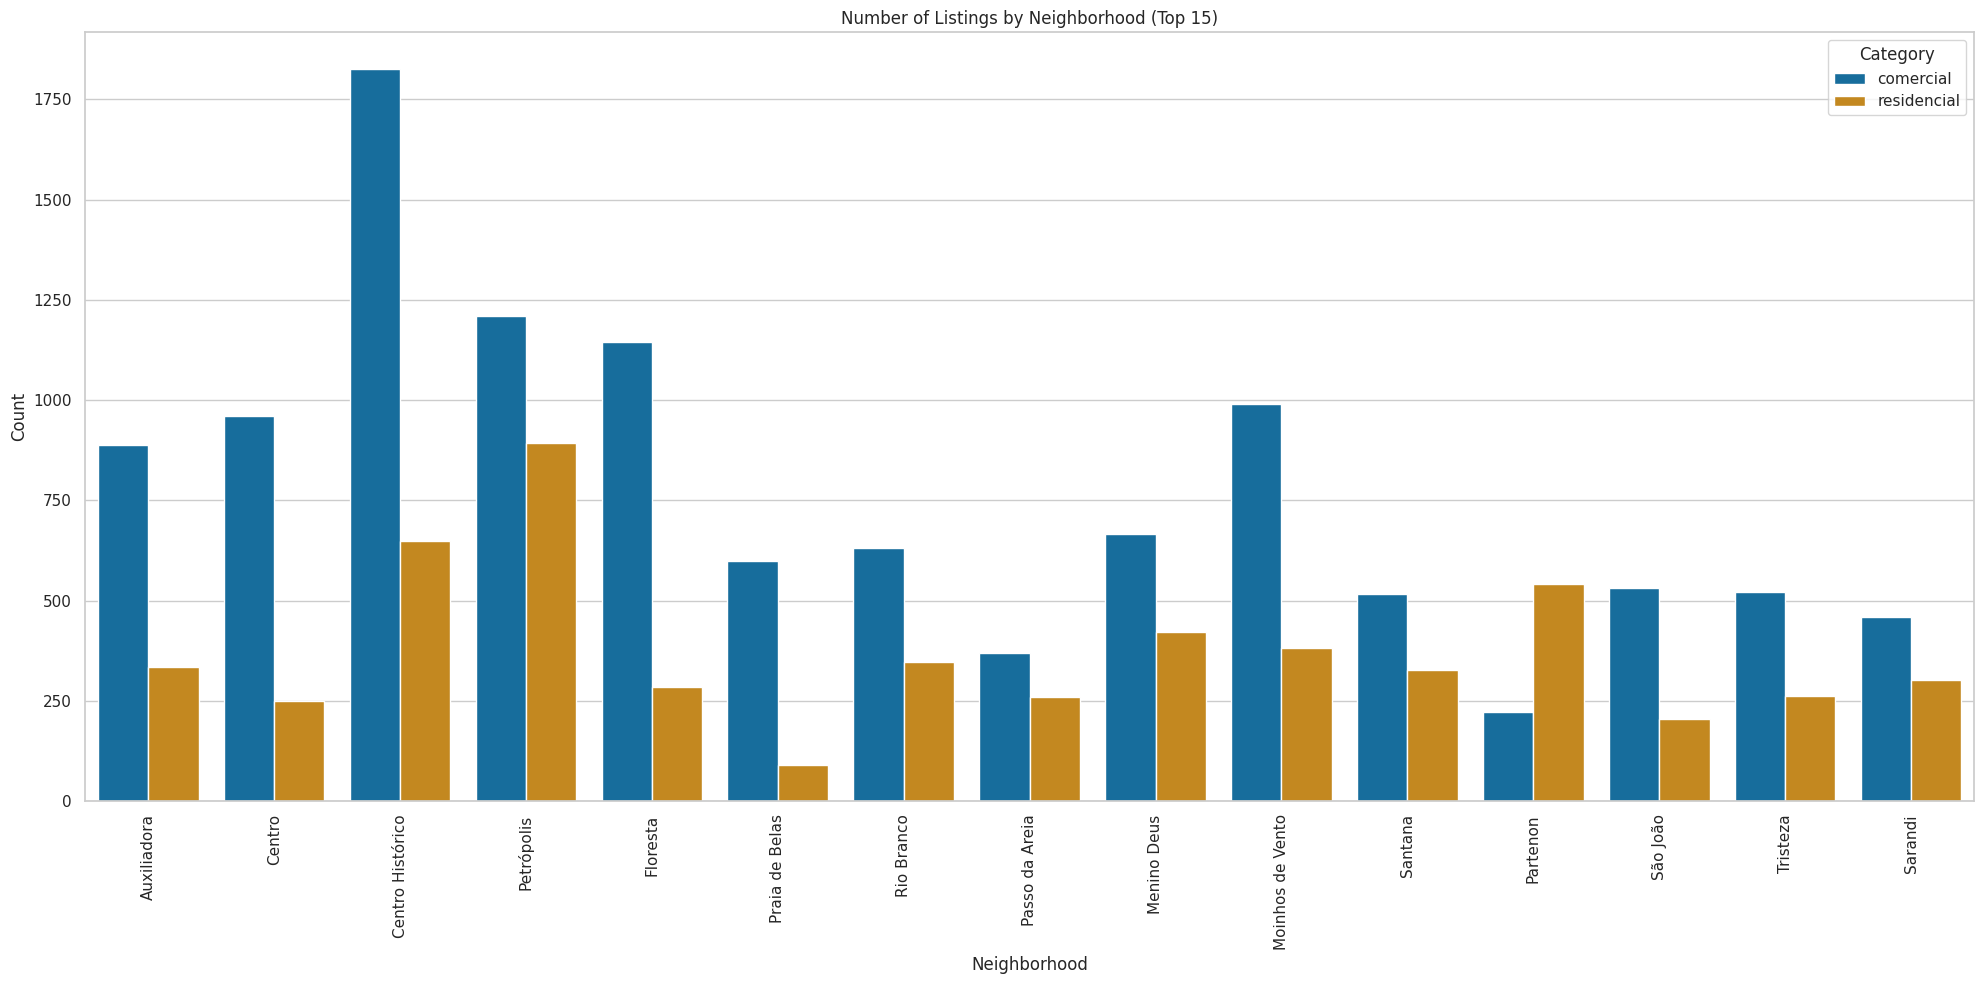

In [43]:
bairro_counts = df['Bairro'].value_counts()

# Get the top 15 most relevant companies
top_15_bairros = bairro_counts.head(15).index

# Create the stacked countplot
sns.set(style="whitegrid")
sns.set_palette("colorblind")
plt.figure(figsize=(20, 10))
sns.countplot(data=df[df['Bairro'].isin(top_15_bairros)], x='Bairro', hue='Categoria')

# Update the x-axis labels with Bairro names and IDH values
plt.xticks(range(len(top_15_bairros)), rotation=90)

# Set the labels and title
plt.xlabel('Neighborhood')
plt.ylabel('Count')
plt.title('Number of Listings by Neighborhood (Top 15)')

# Display the plot
plt.legend(title='Category')
plt.tight_layout()
plt.show()

Type Analysis

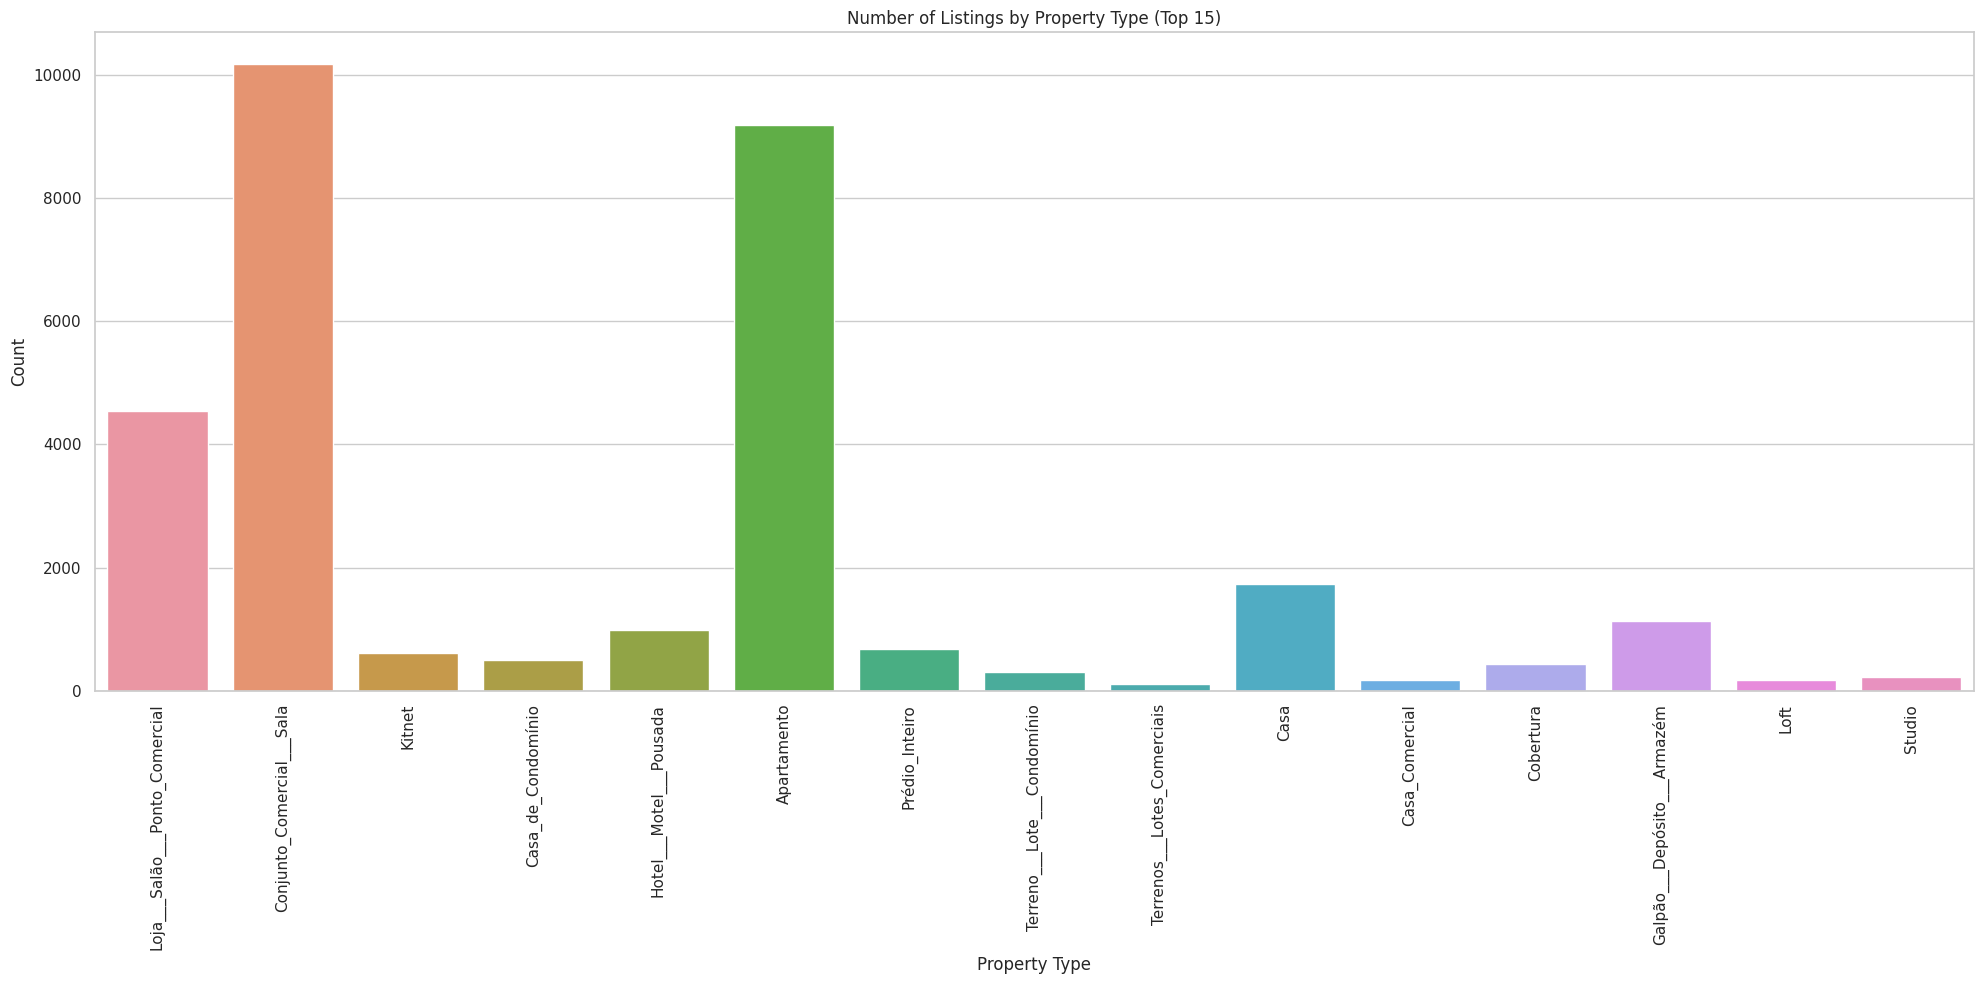

In [44]:
Tipo_counts = df['Tipo'].value_counts()

# Get the top 15 most relevant types
top_15_Tipo = Tipo_counts.head(15).index

# Create the stacked countplot
sns.set(style="whitegrid")
sns.set_palette("colorblind")
plt.figure(figsize=(20, 10))
sns.countplot(data=df[df['Tipo'].isin(top_15_Tipo)], x='Tipo')

# Update the x-axis labels with Tipo names
plt.xticks(rotation=90)

# Set the labels and title
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.title('Number of Listings by Property Type (Top 15)')

# Display the plot
plt.tight_layout()
plt.show()


Category Analysis

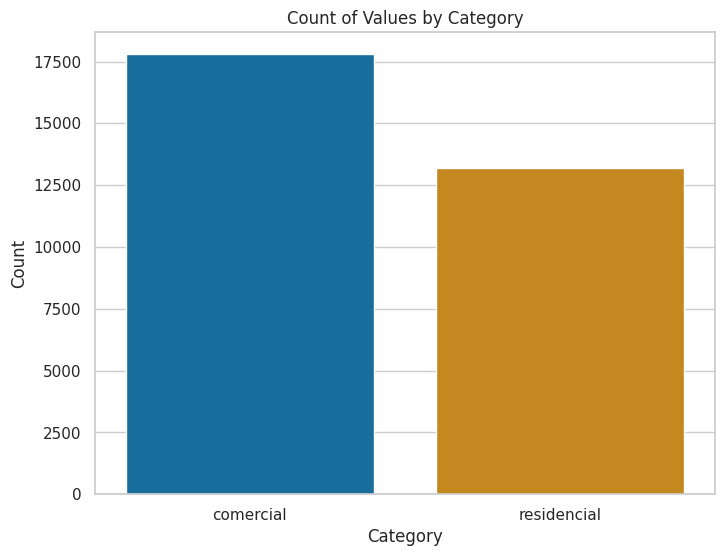

In [45]:
sns.set(style="whitegrid")
sns.set_palette("colorblind")
plt.figure(figsize=(8, 6))
sns.countplot(x='Categoria', data=df)
plt.title('Count of Values by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


Comparing these categories with the value of the property tax and condominium fees

In [46]:
q1 = df['IPTU'].quantile(0.25)
q3 = df['IPTU'].quantile(0.75)
iqr = q3 - q1
threshold = 3 * iqr

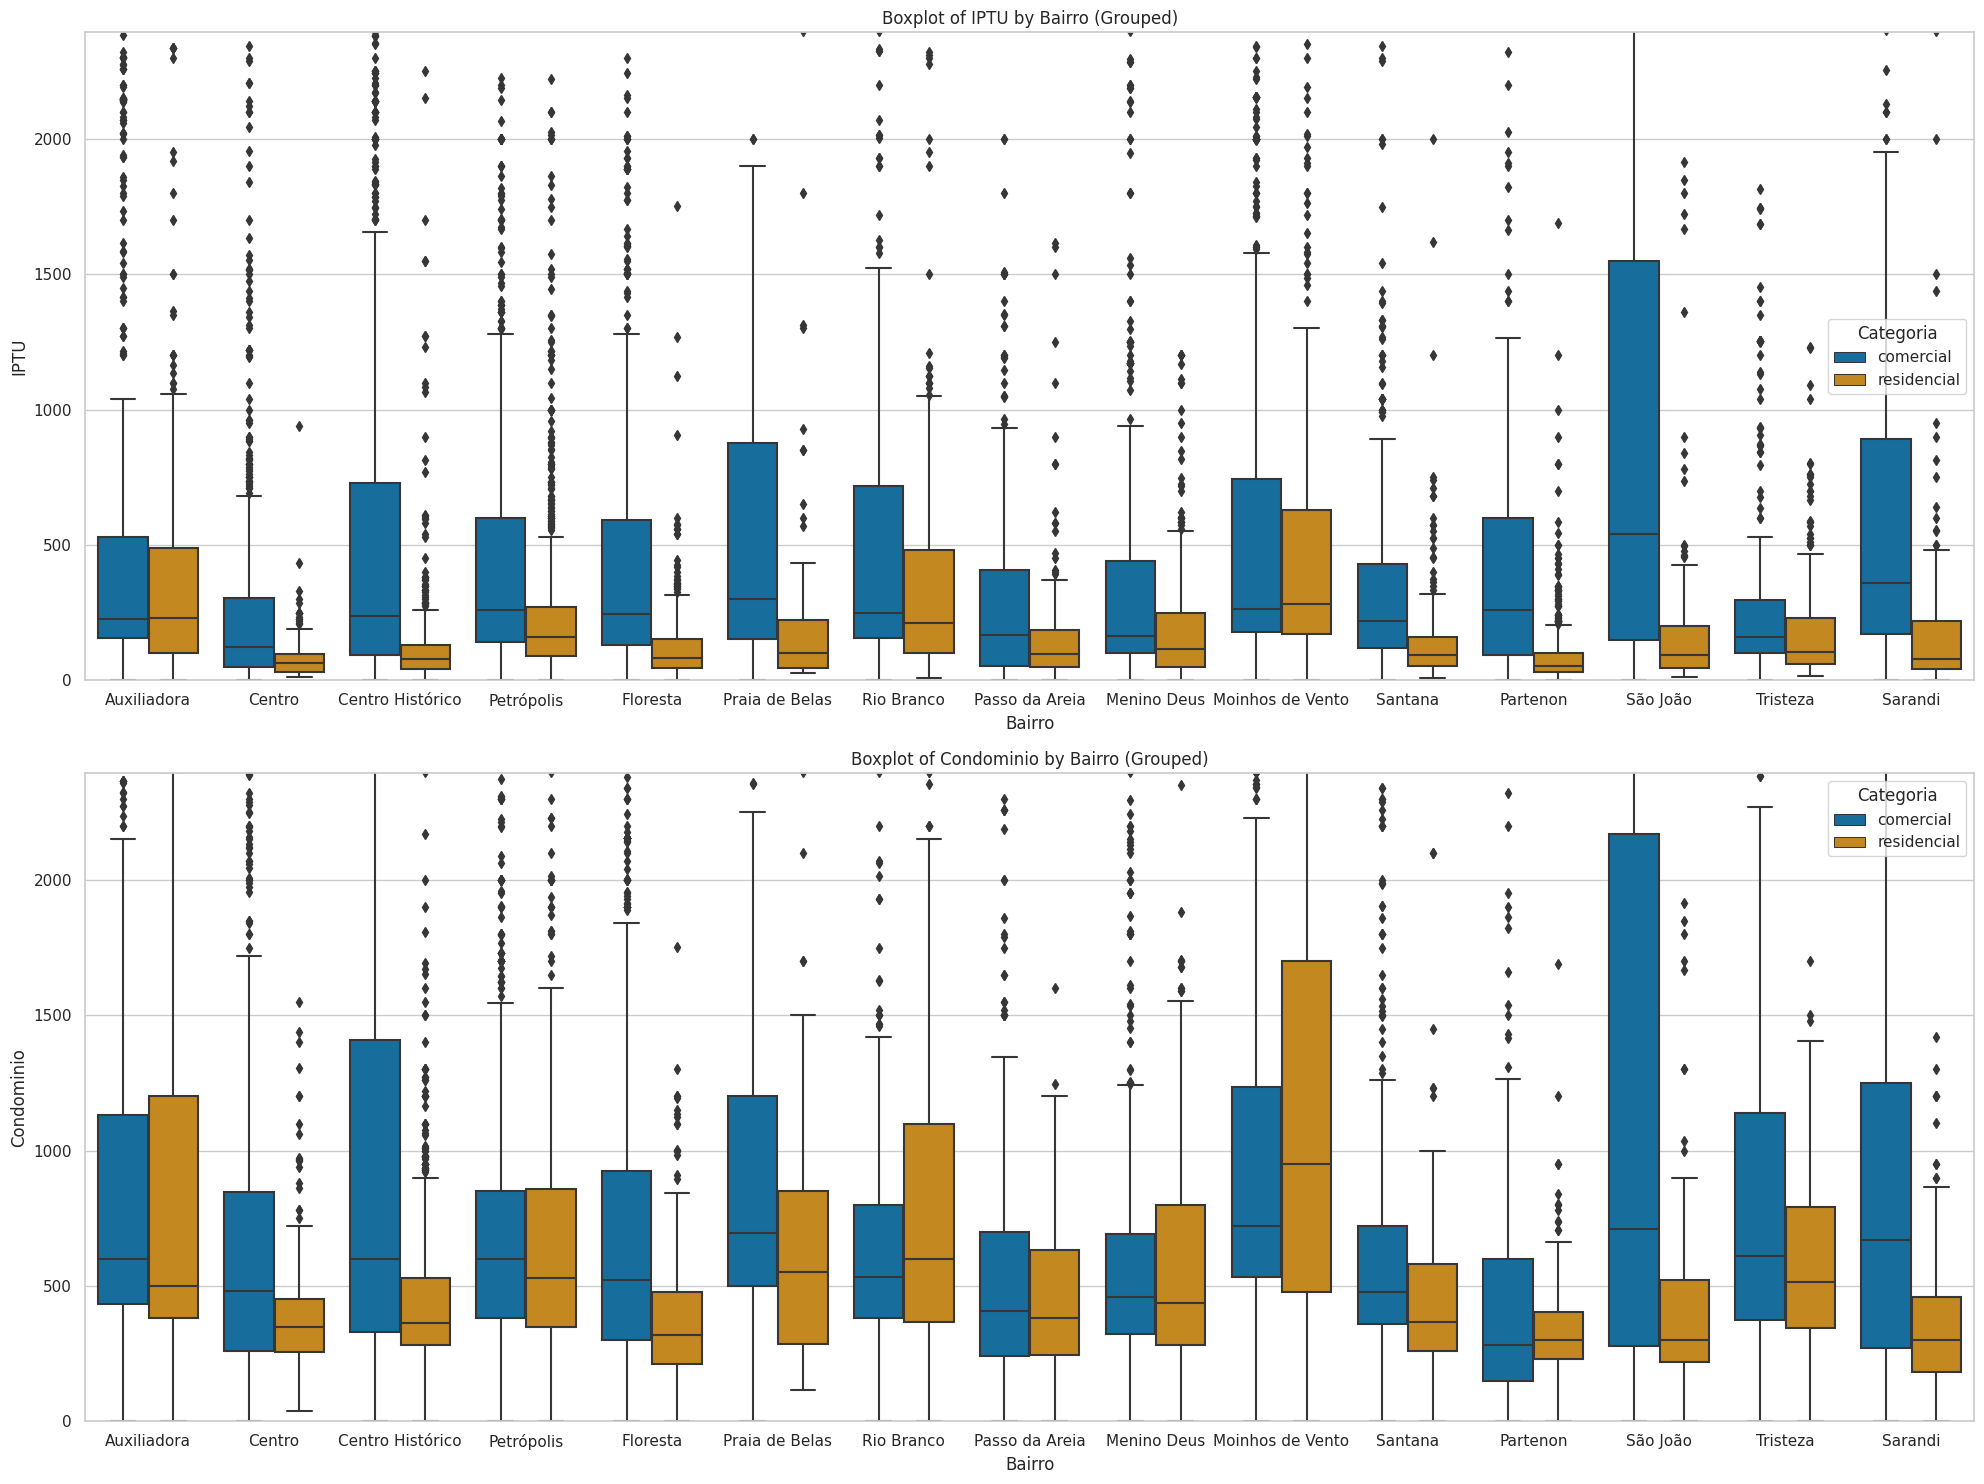

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 15), sharey=True)
sns.set_palette("colorblind")

# Plot for 'IPTU' column
q1 = df['IPTU'].quantile(0.25)
q3 = df['IPTU'].quantile(0.75)
iqr = q3 - q1
threshold = 3 * iqr
sns.boxplot(x='Bairro', y='IPTU', hue='Categoria', data=df[df['Bairro'].isin(top_15_bairros)], ax=axs[0])
axs[0].set_title('Boxplot of IPTU by Bairro (Grouped)')
axs[0].set_xlabel('Bairro')
axs[0].set_ylabel('IPTU')
axs[0].legend(title='Categoria')
axs[0].set_ylim(0, q3 + threshold)

# Plot for 'Condominio' column
q1 = df['Condominio'].quantile(0.25)
q3 = df['Condominio'].quantile(0.75)
iqr = q3 - q1
threshold = 3 * iqr
sns.boxplot(x='Bairro', y='Condominio', hue='Categoria', data=df[df['Bairro'].isin(top_15_bairros)], ax=axs[1])
axs[1].set_title('Boxplot of Condominio by Bairro (Grouped)')
axs[1].set_xlabel('Bairro')
axs[1].set_ylabel('Condominio')
axs[1].legend(title='Categoria')
axs[1].set_ylim(0, q3 + threshold)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


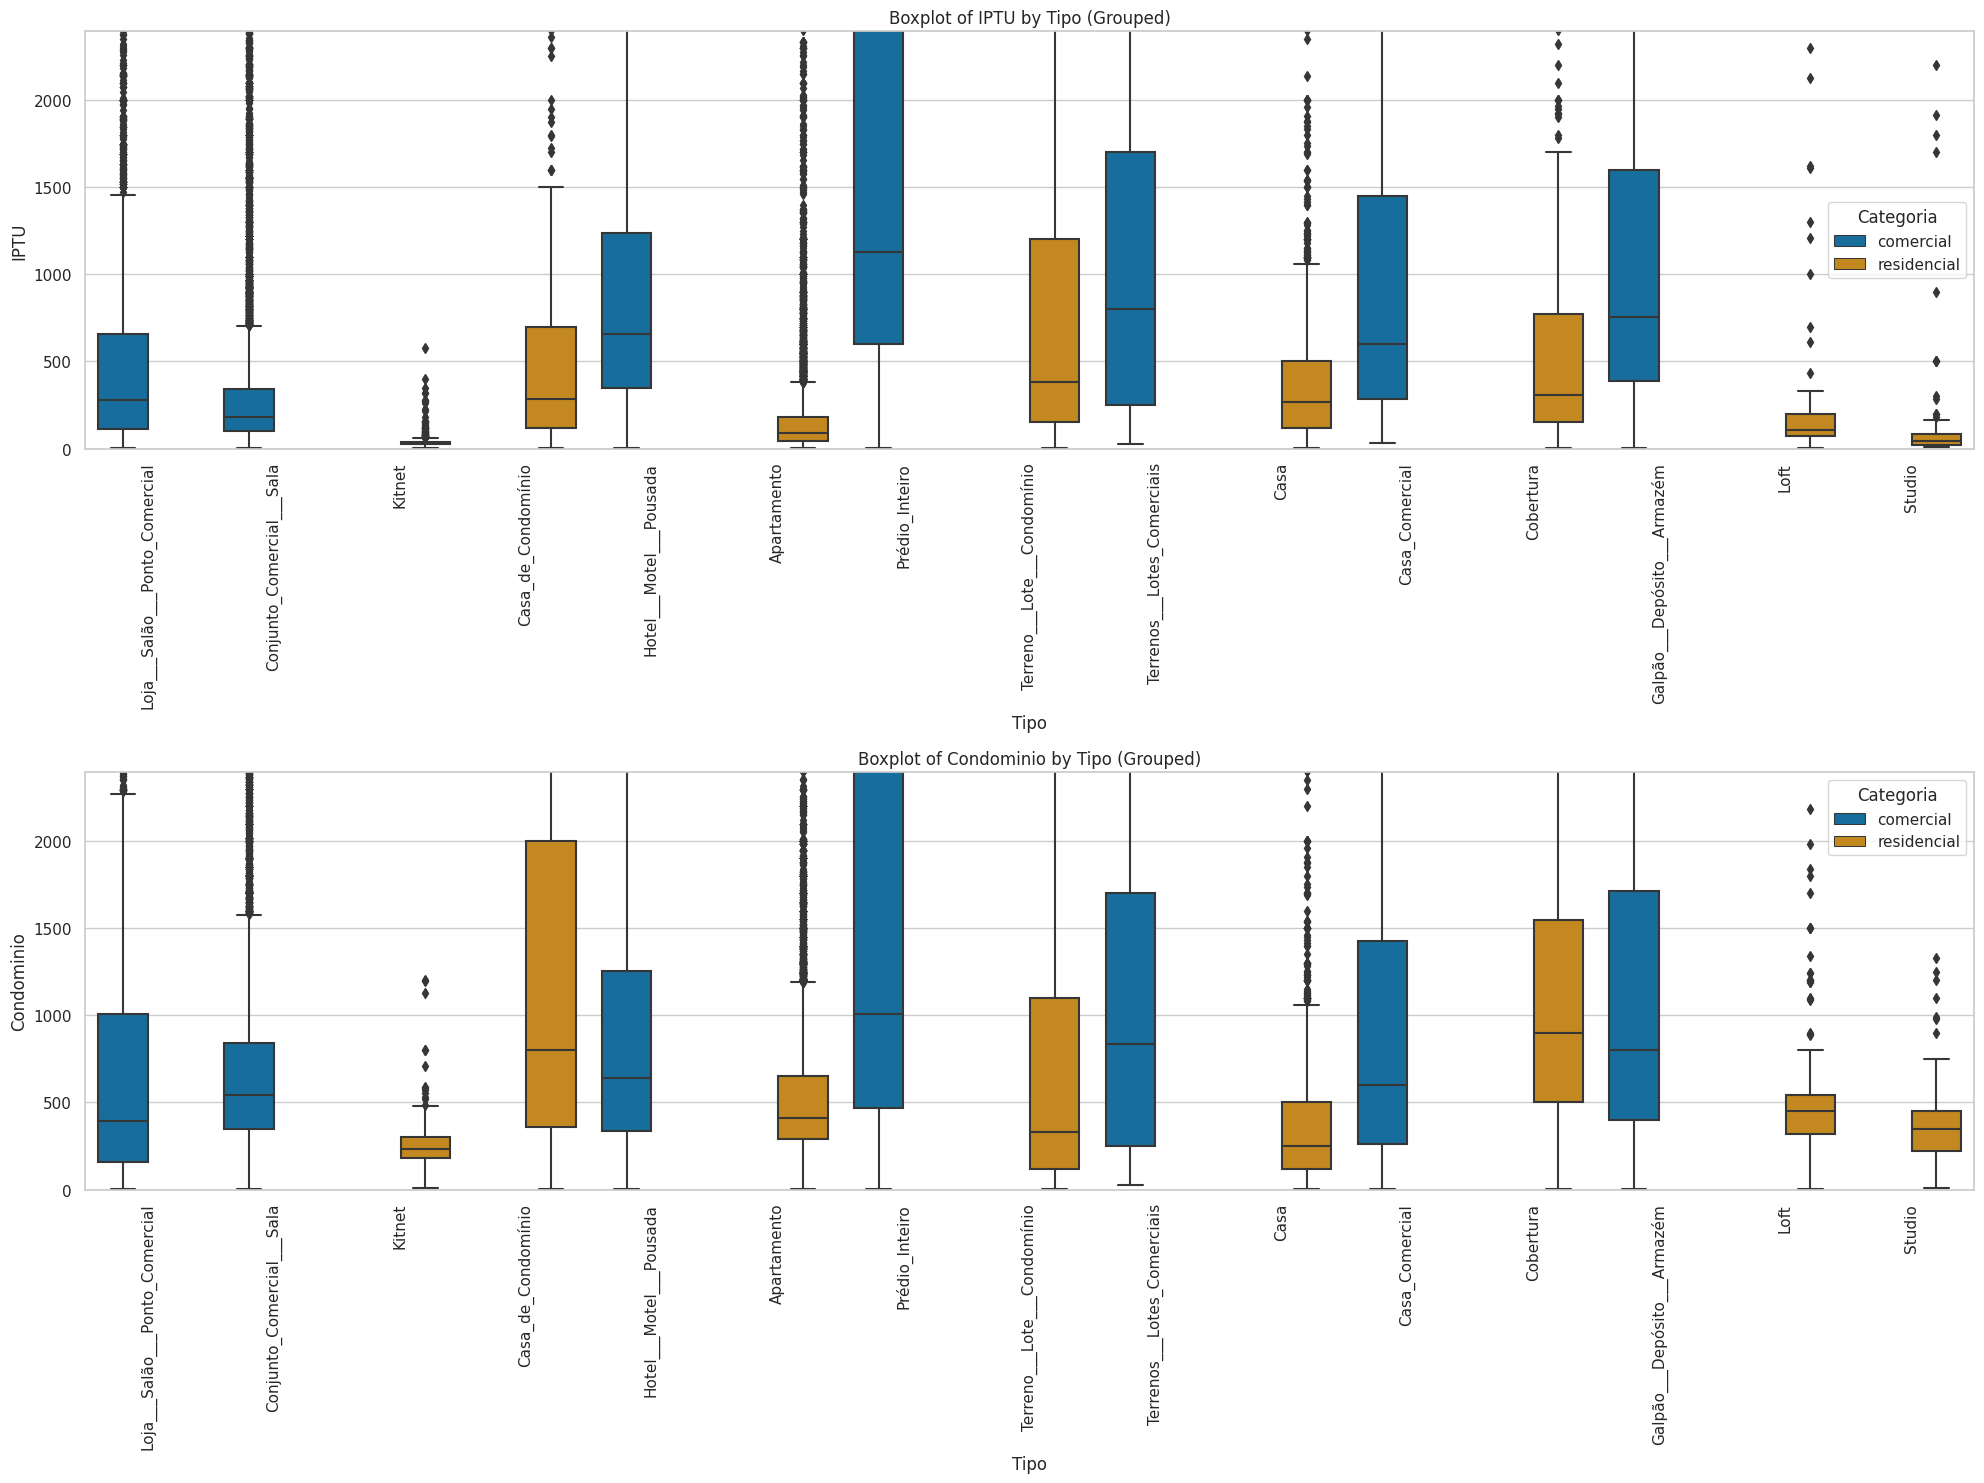

In [48]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 15), sharey=True)
sns.set_palette("colorblind")

# Plot for 'IPTU' column
q1 = df['IPTU'].quantile(0.25)
q3 = df['IPTU'].quantile(0.75)
iqr = q3 - q1
threshold = 3 * iqr
sns.boxplot(x='Tipo', y='IPTU', hue='Categoria', data=df[df['Tipo'].isin(top_15_Tipo)], ax=axs[0])
axs[0].set_title('Boxplot of IPTU by Tipo (Grouped)')
axs[0].set_xlabel('Tipo')
axs[0].set_ylabel('IPTU')
axs[0].legend(title='Categoria')
axs[0].set_ylim(0, q3 + threshold)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)  # Rotate x-axis labels by 90 degrees


# Plot for 'Condominio' column
q1 = df['Condominio'].quantile(0.25)
q3 = df['Condominio'].quantile(0.75)
iqr = q3 - q1
threshold = 3 * iqr
sns.boxplot(x='Tipo', y='Condominio', hue='Categoria', data=df[df['Tipo'].isin(top_15_Tipo)], ax=axs[1])
axs[1].set_title('Boxplot of Condominio by Tipo (Grouped)')
axs[1].set_xlabel('Tipo')
axs[1].set_ylabel('Condominio')
axs[1].legend(title='Categoria')
axs[1].set_ylim(0, q3 + threshold)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)  # Rotate x-axis labels by 90 degrees

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


We will check if there is a hierarchical relationship between Category and Type

In [49]:
# Group by parent_variable and check for duplicate child_variable values
duplicate_child = df.groupby('Tipo')['Categoria'].nunique()
duplicate_child = duplicate_child[duplicate_child > 1]

if not duplicate_child.empty:
    print("Values of the child variable that appear in multiple values of the parent variable:")
    print(duplicate_child)
else:
    print("No values of the child variable appear in multiple values of the parent variable.")

No values of the child variable appear in multiple values of the parent variable.


Let's visualize this

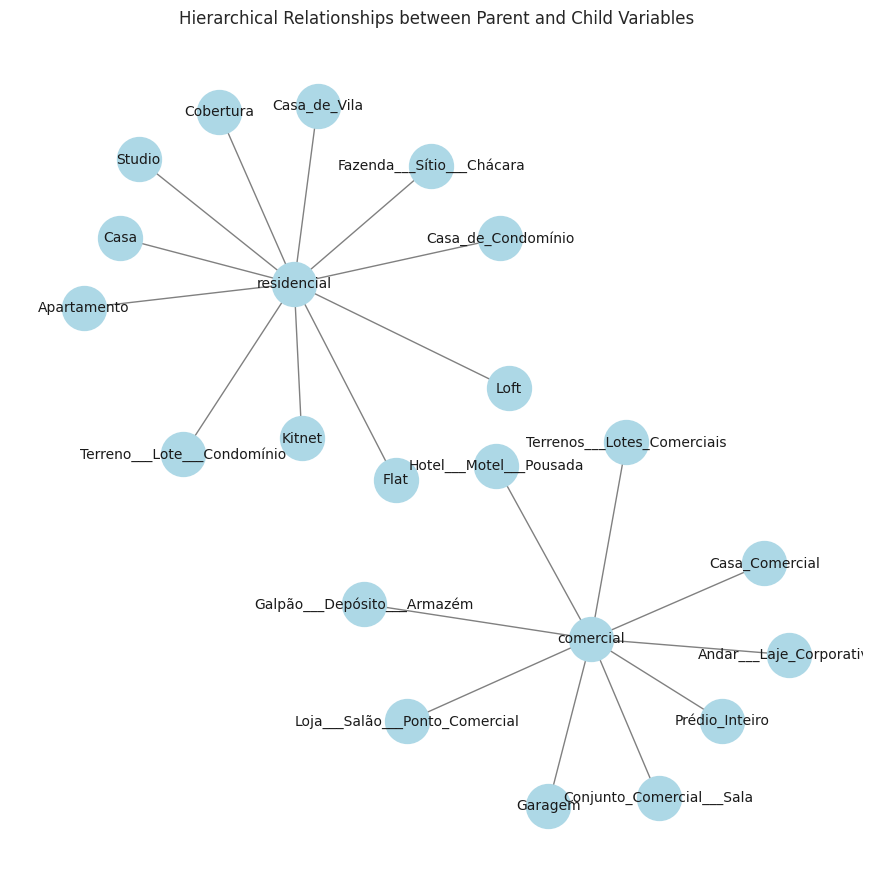

In [50]:
G = nx.Graph()

# Add edges to the graph with the relationships between parent and child
for _, row in df.iterrows():
    G.add_edge(row['Categoria'], row['Tipo'])

pos = nx.spring_layout(G, k=0.6, seed=1)
plt.figure(figsize=(11, 11))
nx.draw_networkx(G, pos, node_color='lightblue', node_size=1000, font_size=10, with_labels=True, edge_color='gray')
plt.title('Hierarchical Relationships between Parent and Child Variables')
plt.axis('off')
plt.show()

### Binaries

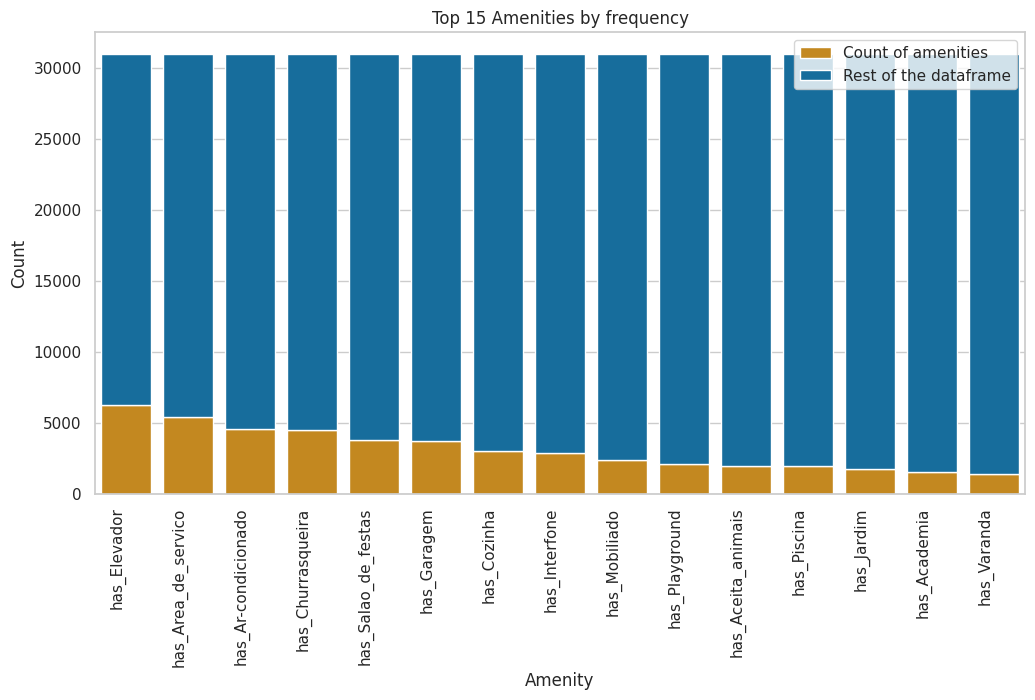

In [51]:
# Calculate the sum of each amenity and sort in descending order
top_amenities = amenities_df.sum().sort_values(ascending=False).head(15)

# Calculate the percentage of each amenity
total_rows = len(amenities_df)
amenity_percentages = top_amenities / total_rows * 100

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create the first axis (bar plot)
sns.set_palette("colorblind")
sns.barplot(x=top_amenities.index, y=top_amenities.values, ax=ax1, label= "Count of amenities", color=sns.color_palette()[1])
ax1.set_ylabel("Count")

# Create the second axis (percentage line plot)
sns.barplot(x=top_amenities.index, y=len(amenities_df) - top_amenities.values, ax=ax1, bottom= top_amenities.values, label= "Rest of the dataframe", color=sns.color_palette()[0])

# Set plot title and labels
plt.title("Top 15 Amenities by frequency")
ax1.set_xlabel("Amenity")

# Rotate x-axis labels for better readability
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right")

plt.legend()
# Display the plot
plt.show()


/tmp/ipykernel_867752/2962508354.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  amenities_df['Category'] = df['Categoria']


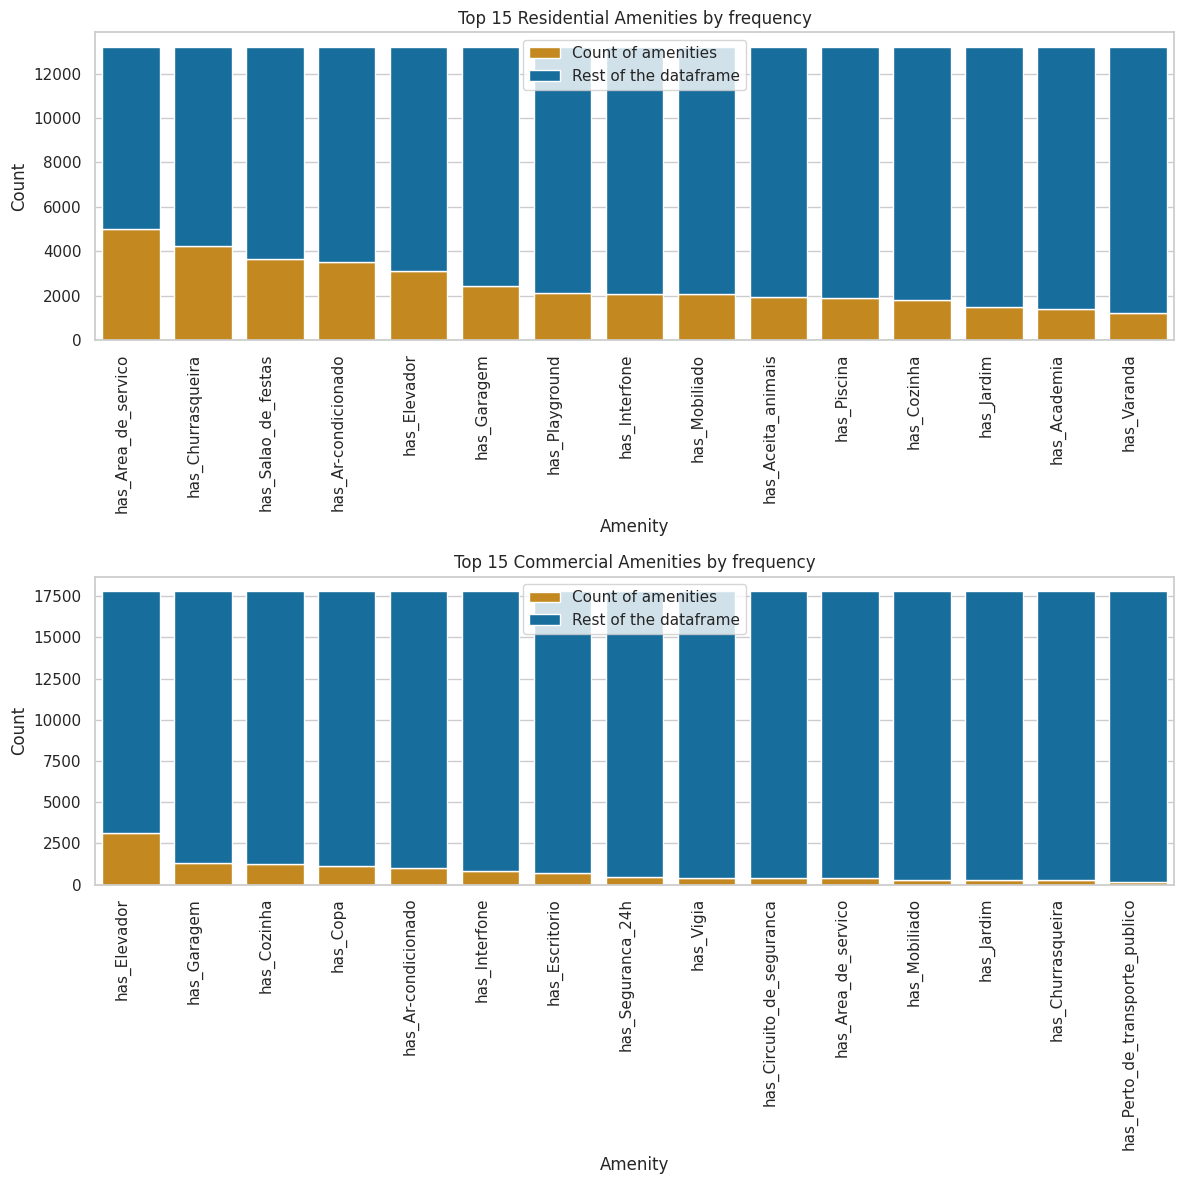

In [52]:
amenities_df['Category'] = df['Categoria']
# Separate the amenities dataframe into two groups based on category
residential_amenities = amenities_df[amenities_df['Category'] == 'residencial']
commercial_amenities = amenities_df[amenities_df['Category'] == 'comercial']

# Calculate the sum of each amenity and sort in descending order for each group
top_residential_amenities = residential_amenities.drop(['Category'], axis=1).sum().sort_values(ascending=False).head(15)
top_commercial_amenities = commercial_amenities.drop(['Category'], axis=1).sum().sort_values(ascending=False).head(15)

# Calculate the percentage of each amenity for each group
total_residential_rows = len(residential_amenities)
total_commercial_rows = len(commercial_amenities)

# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Create the first axis (bar plot) for residential amenities
sns.set_palette("colorblind")
sns.barplot(x=top_residential_amenities.index, y=top_residential_amenities.values, ax=ax1, label="Count of amenities",
            color=sns.color_palette()[1])
sns.barplot(x=top_residential_amenities.index, y=total_residential_rows - top_residential_amenities.values, ax=ax1,
            bottom=top_residential_amenities.values, label="Rest of the dataframe", color=sns.color_palette()[0])
ax1.set_ylabel("Count")
ax1.set_title("Top 15 Residential Amenities by frequency")
ax1.set_xlabel("Amenity")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right")
ax1.legend()

# Create the second axis (bar plot) for commercial amenities
sns.set_palette("colorblind")
sns.barplot(x=top_commercial_amenities.index, y=top_commercial_amenities.values, ax=ax2, label="Count of amenities",
            color=sns.color_palette()[1])
sns.barplot(x=top_commercial_amenities.index, y=total_commercial_rows - top_commercial_amenities.values, ax=ax2,
            bottom=top_commercial_amenities.values, label="Rest of the dataframe", color=sns.color_palette()[0])
ax2.set_ylabel("Count")
ax2.set_title("Top 15 Commercial Amenities by frequency")
ax2.set_xlabel("Amenity")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="right")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
amenities_df.drop(['Category'], axis=1, inplace=True)

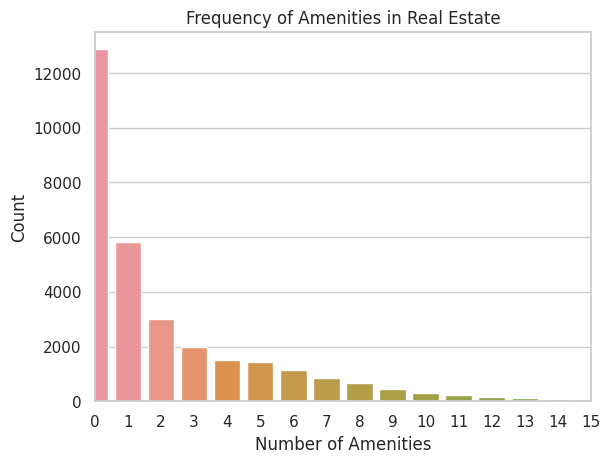

In [53]:
amenities_count = amenities_df.sum(axis=1)

# Count the number of rows for each range of amenities
counts = amenities_count.value_counts().sort_index()

# Create the bar plot using Seaborn
sns.barplot(x=counts.index.astype(int), y=counts.values)

# Set the labels and title
plt.xlabel('Number of Amenities')
plt.ylabel('Count')
plt.title('Frequency of Amenities in Real Estate')

# Set the x-axis limits to 0 to 20
plt.xlim(0, 15)

# Display the plot
plt.show()


In analyzing real estate data, it is evident that the frequency of amenities differs significantly between the two categories. Notably, the presence or absence of amenities in a subset of real estate properties can introduce potential bias in the analysis. This bias arises from the fact that the availability of amenities is not uniformly distributed across all properties, leading to a skewed representation and potentially influencing the observed relationships between amenities and other variables of interest. Therefore, it is crucial to consider and account for this bias when drawing conclusions or making predictions based on the relationship between amenities and other factors in the real estate market.

## Analysis of variables by price

### Numeric

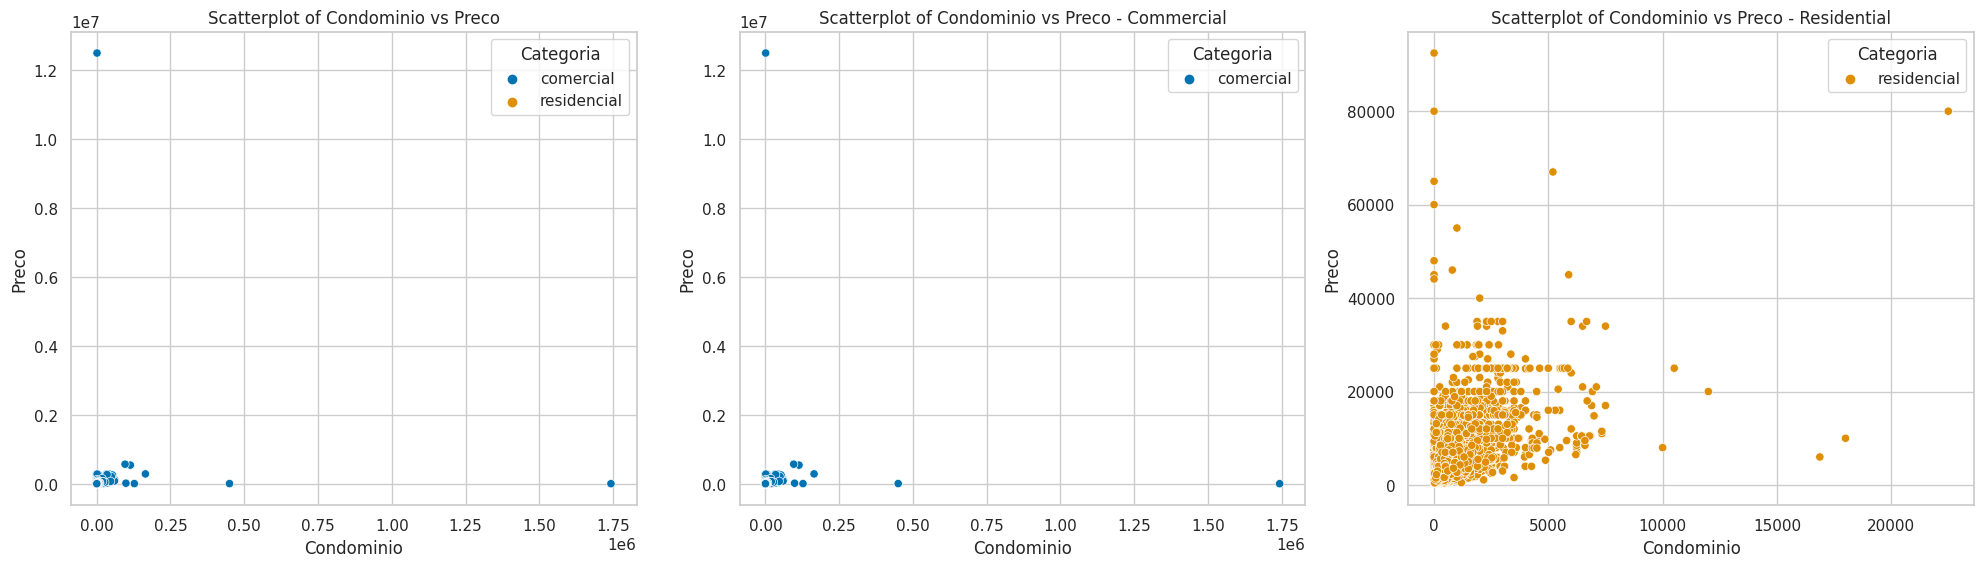

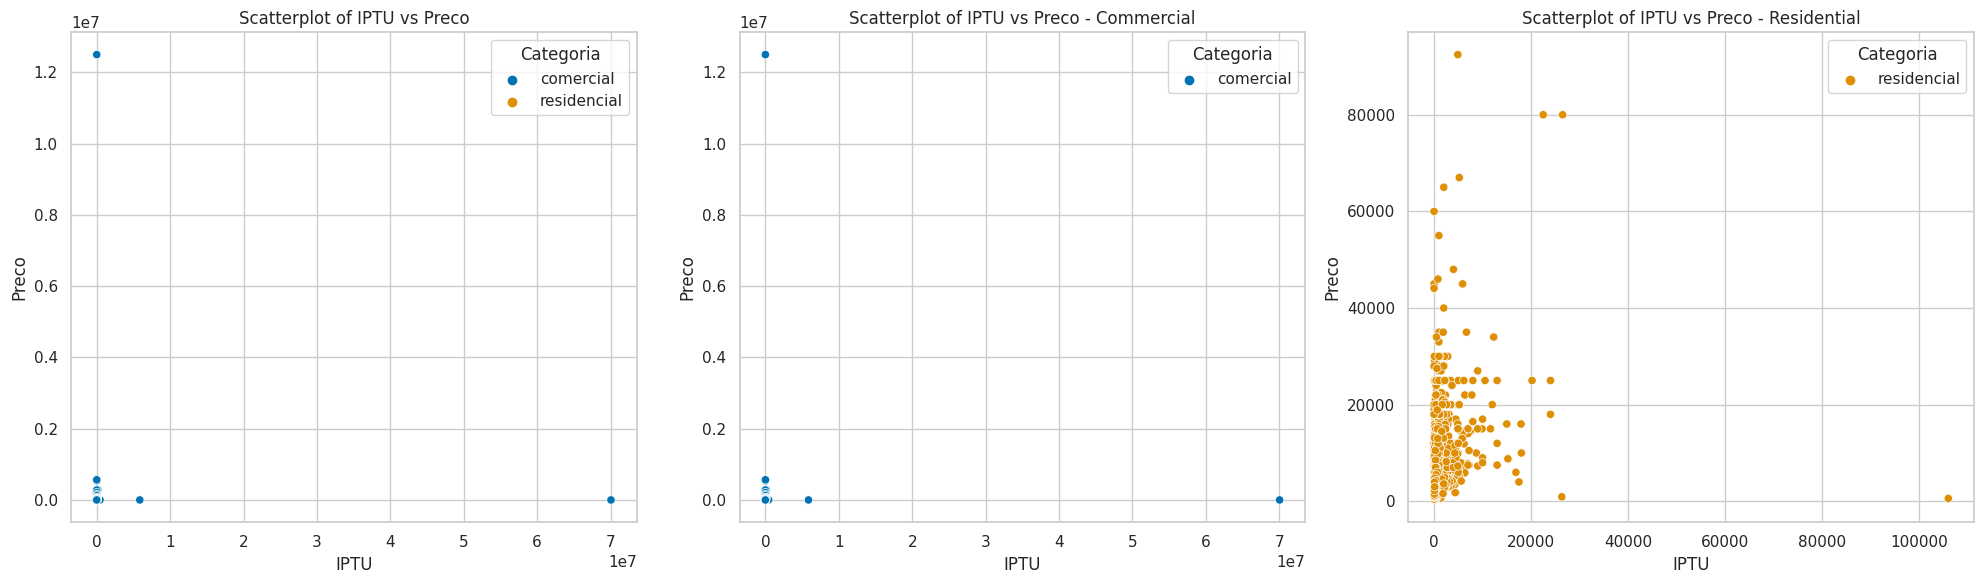

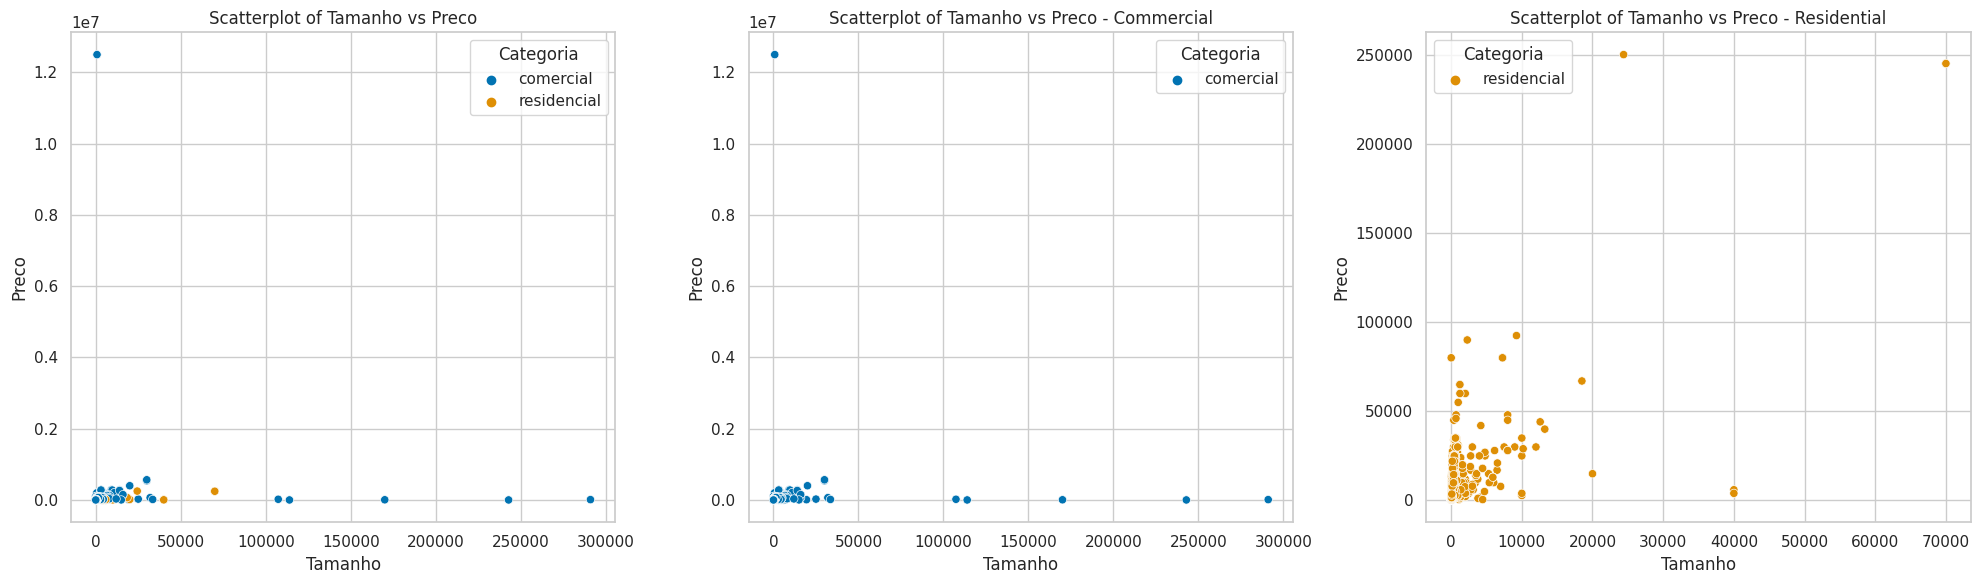

In [54]:
sns.set(style="whitegrid")
sns.set_palette("colorblind")
for column in DATAFRAME_VAR['continuous']:
    if column != 'Preco':
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
        ax1 = axes[0]
        ax2 = axes[1]
        ax3 = axes[2]
        sns.scatterplot(data=df, x=column, y='Preco', ax=ax1, hue='Categoria')
        ax1.set_title(f'Scatterplot of {column} vs Preco')
        sns.scatterplot(data=df[df['Categoria'] == 'comercial'], x=column, y='Preco', ax=ax2, hue='Categoria')
        ax2.set_title(f'Scatterplot of {column} vs Preco - Commercial')
        sns.scatterplot(data=df[df['Categoria'] == 'residencial'], x=column, y='Preco', ax=ax3, hue='Categoria', palette=[sns.color_palette()[1]])
        ax3.set_title(f'Scatterplot of {column} vs Preco - Residential')

        plt.tight_layout()
        plt.show()

As we had already seen, there is a relevant linear correlation in the "Price" column with the "Size" and "Condominium" columns in the residential part and only with the "Size" column in the commercial one

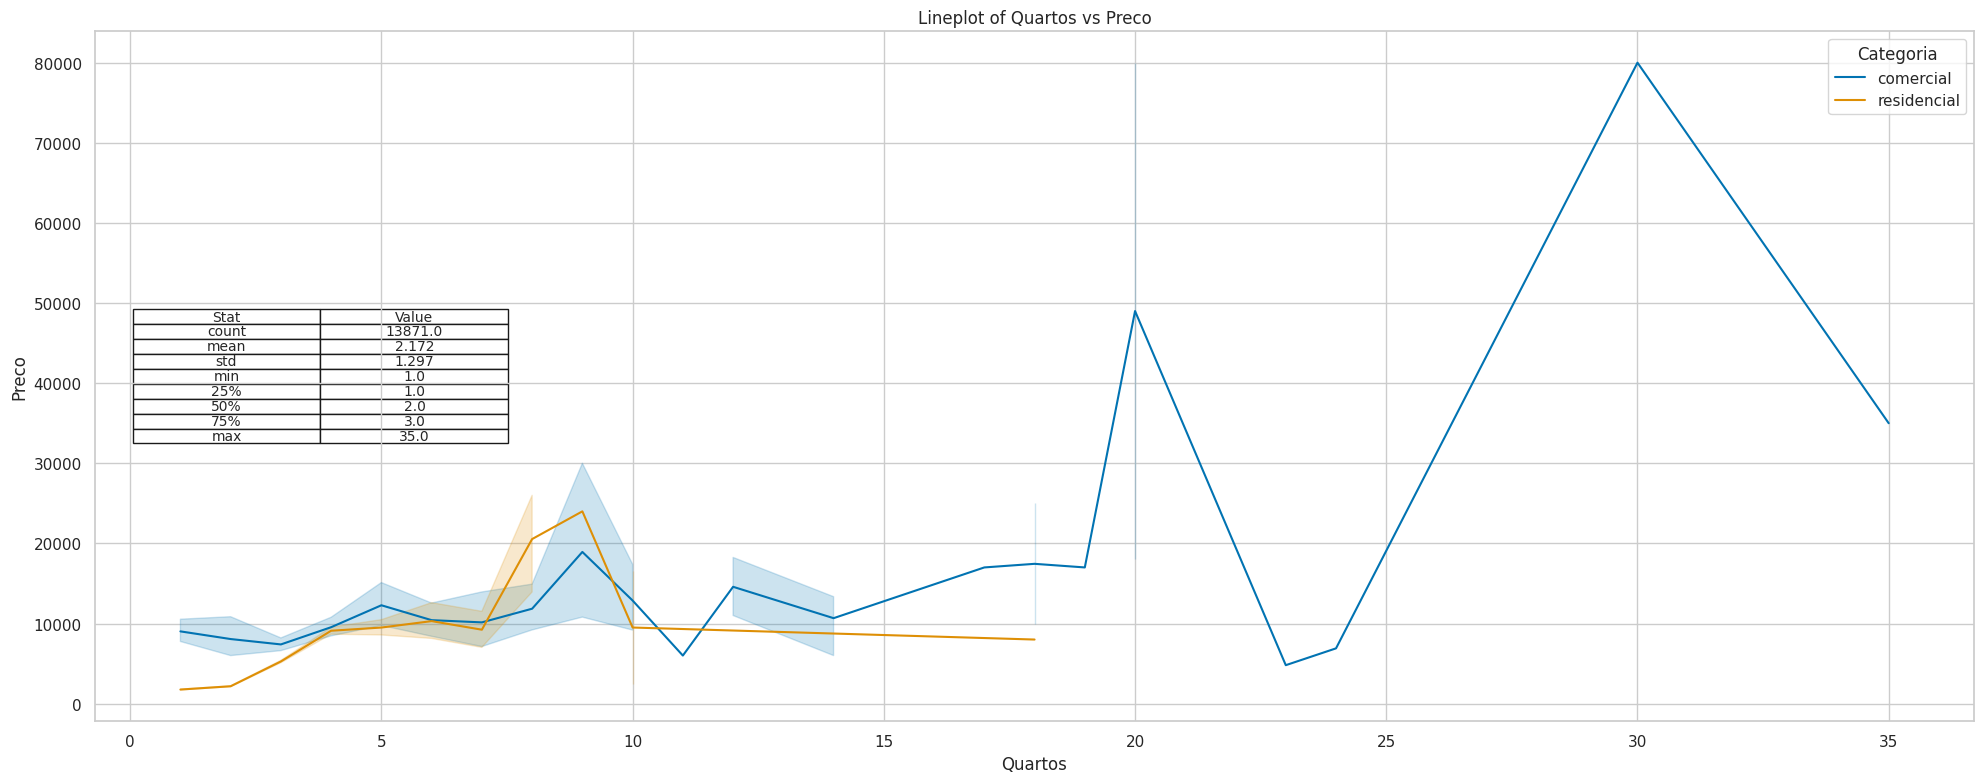

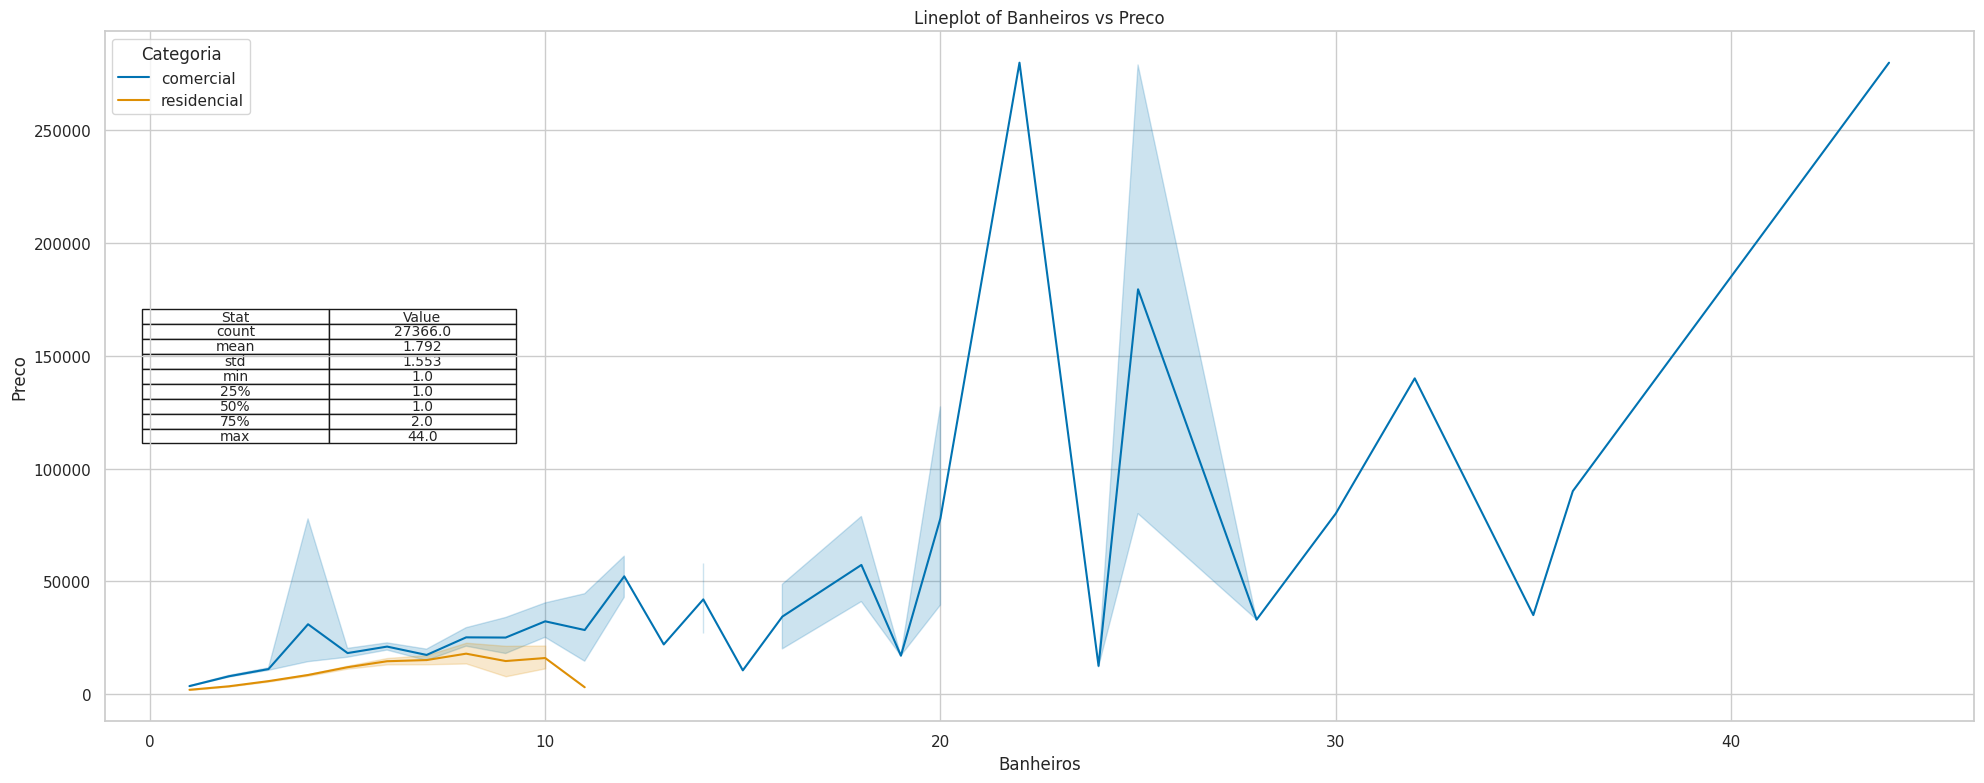

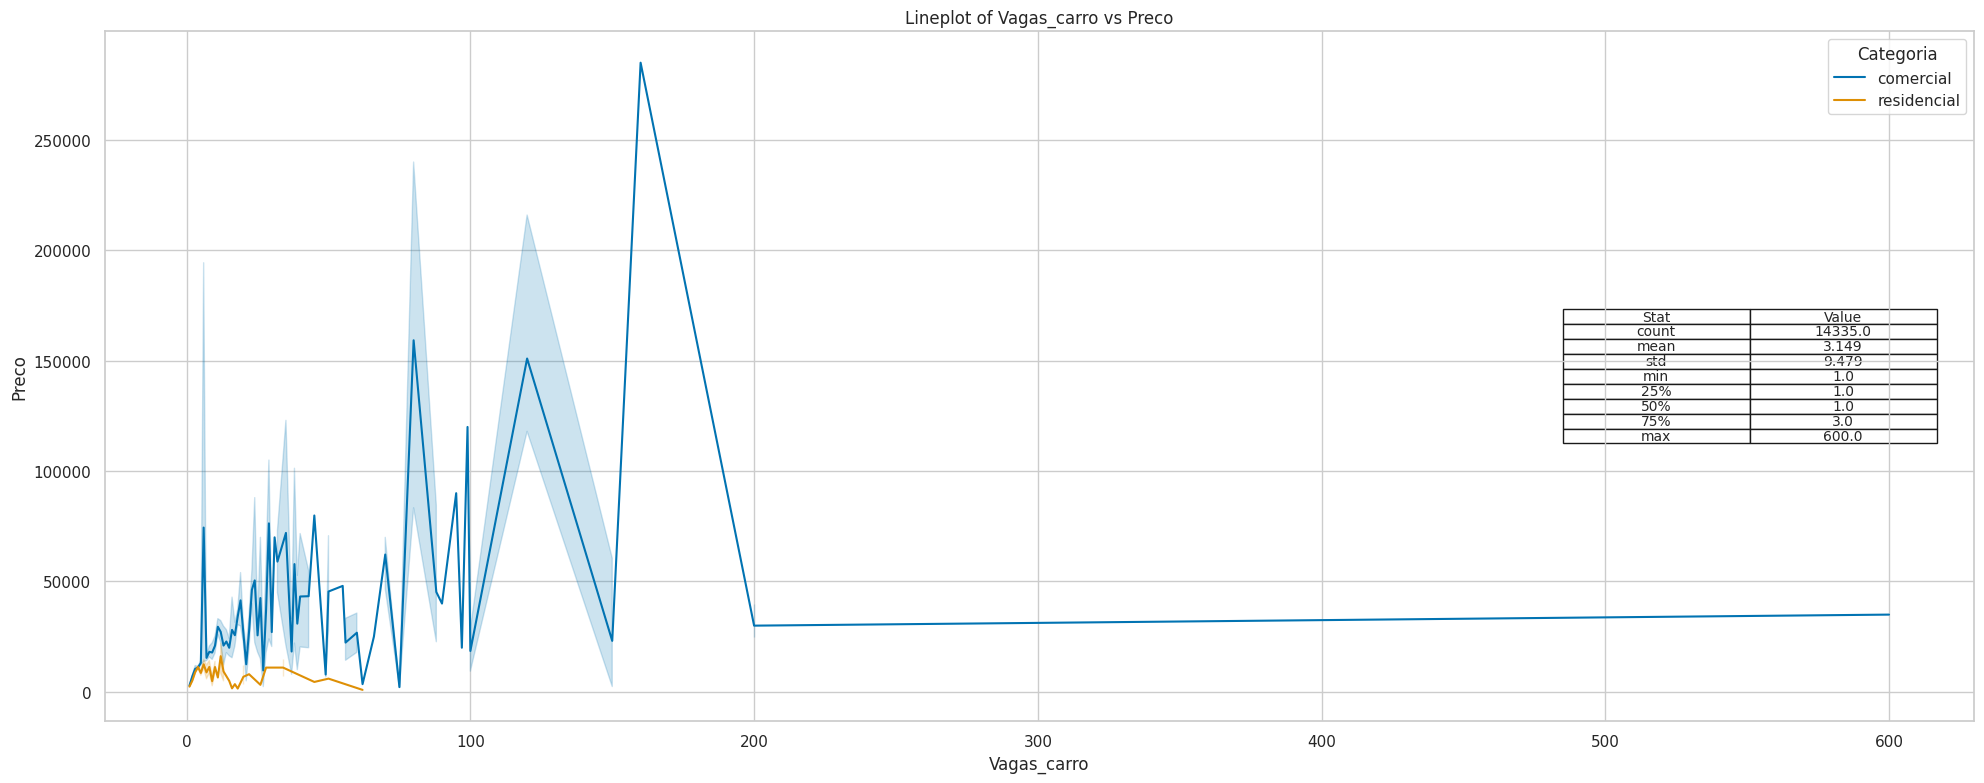

In [55]:
sns.set(style="whitegrid")
sns.set_palette("colorblind")

pos = ['center left', 'center left', 'center right']
i = 0
for column in DATAFRAME_VAR['discrete']:
    if column != 'Preco':
        fig, ax = plt.subplots(figsize=(20, 8))

        # Create the table
        table_data = df[column].describe().round(3).to_frame().reset_index()
        table_data.columns = ['Stat', 'Value']
        table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc=pos[i], cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(0.2, 0.8)
        plt.subplots_adjust(top=0.2)

        sns.lineplot(data=df, x=column, y='Preco', hue='Categoria')
        ax.set_title(f'Lineplot of {column} vs Preco')
        i += 1 
        plt.tight_layout()
        plt.show()


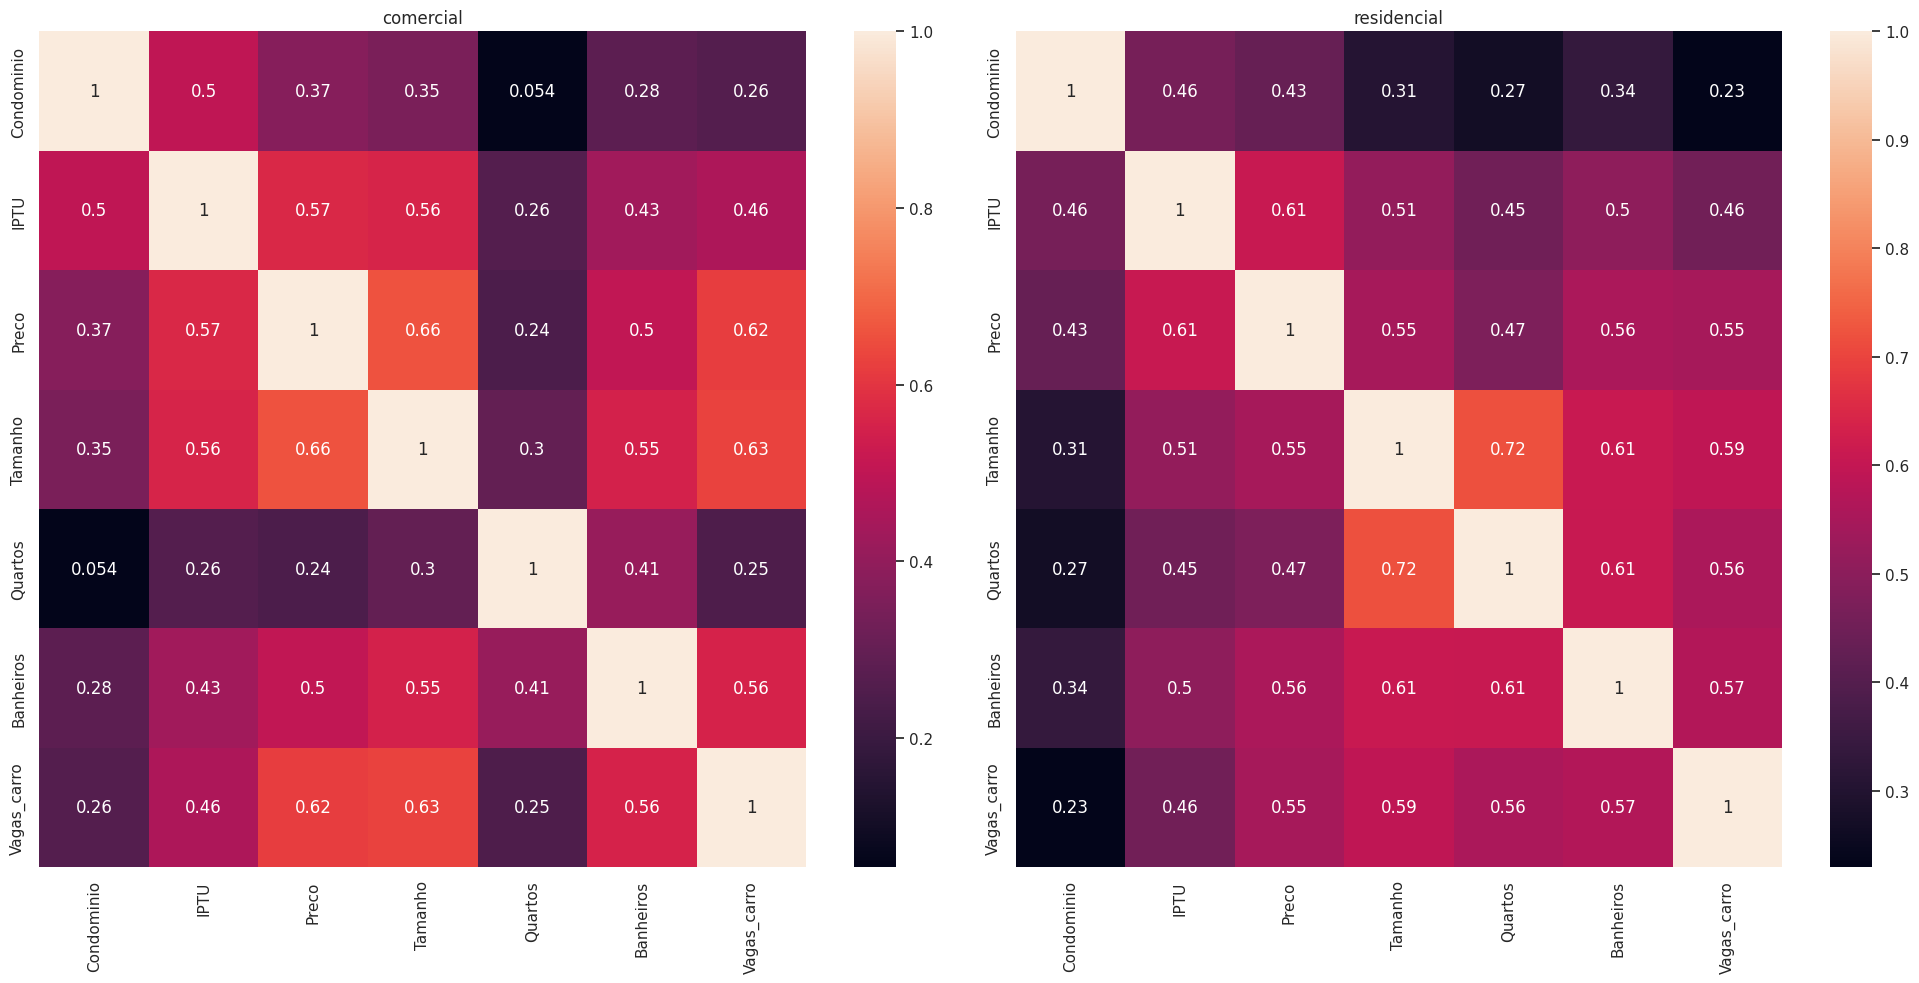

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=len(df['Categoria'].unique()), figsize=(20, 10))

for i, (cat, group) in enumerate(df.groupby('Categoria')):
    sns.heatmap(group[DATAFRAME_VAR['continuous'] + DATAFRAME_VAR['discrete']].corr('kendall'), ax=axes[i], annot=True) 
    axes[i].set_title(cat)

plt.tight_layout()
plt.show()


### Categorical

/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


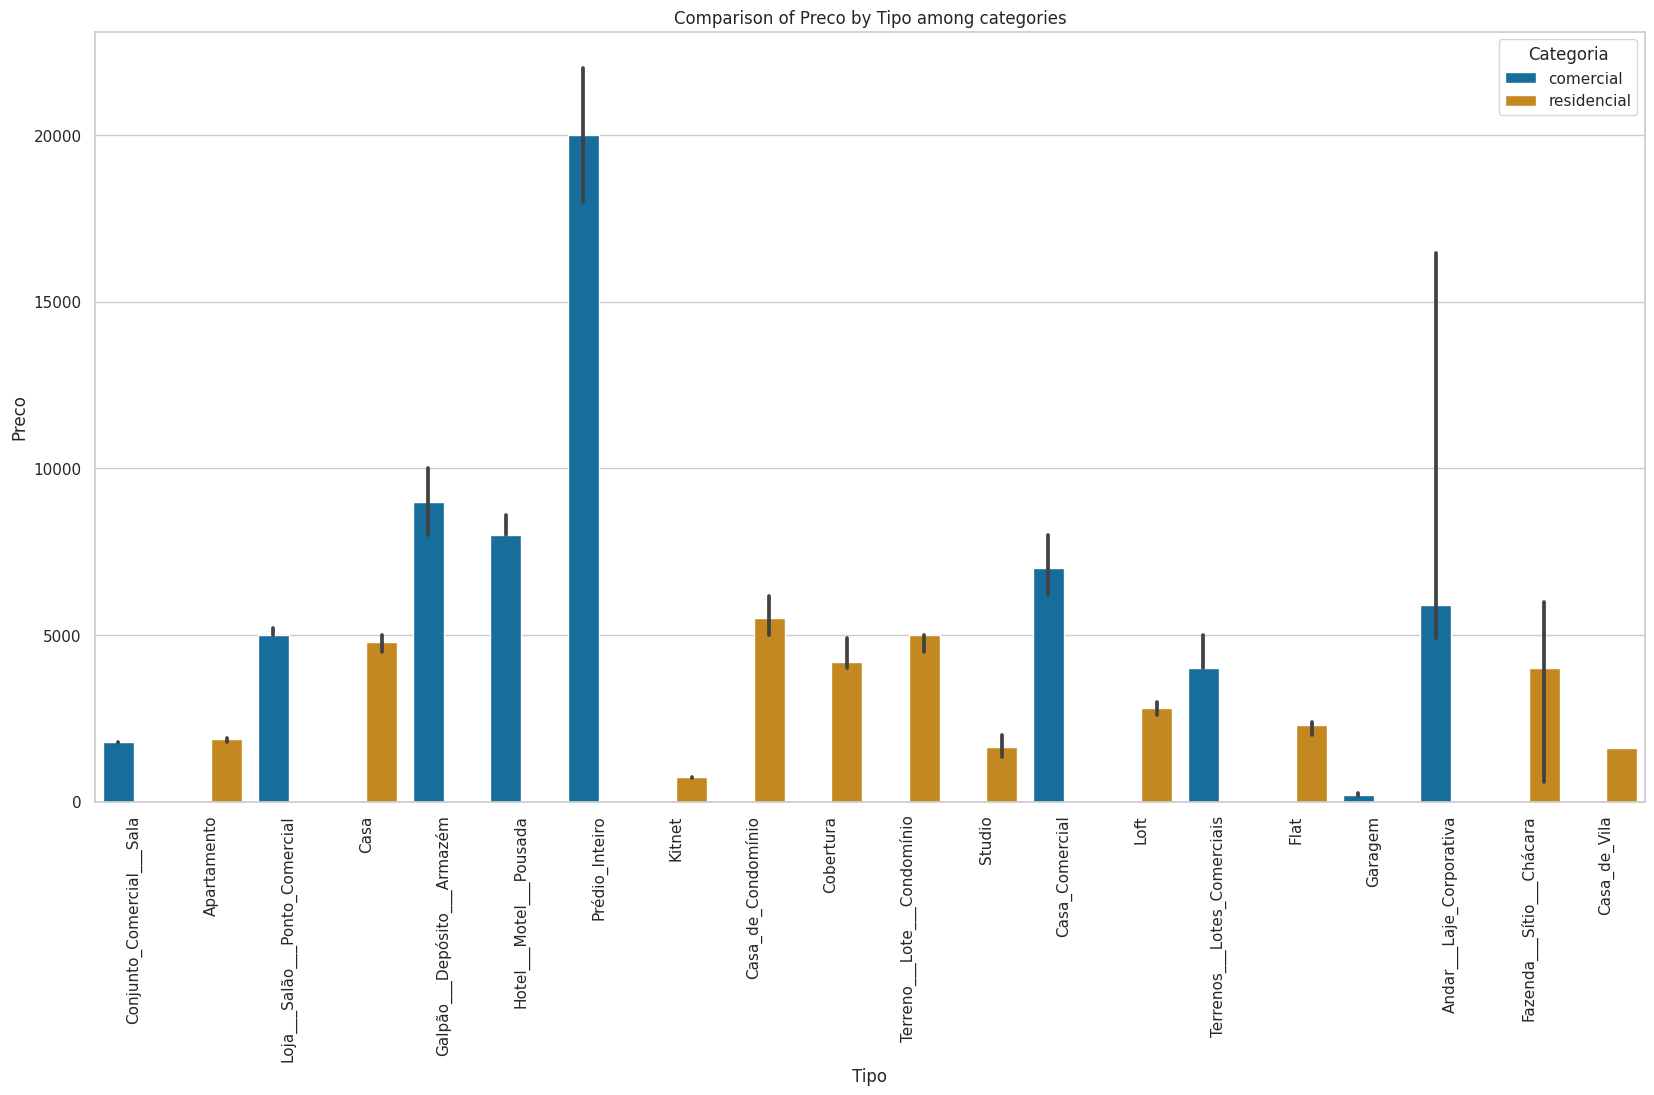

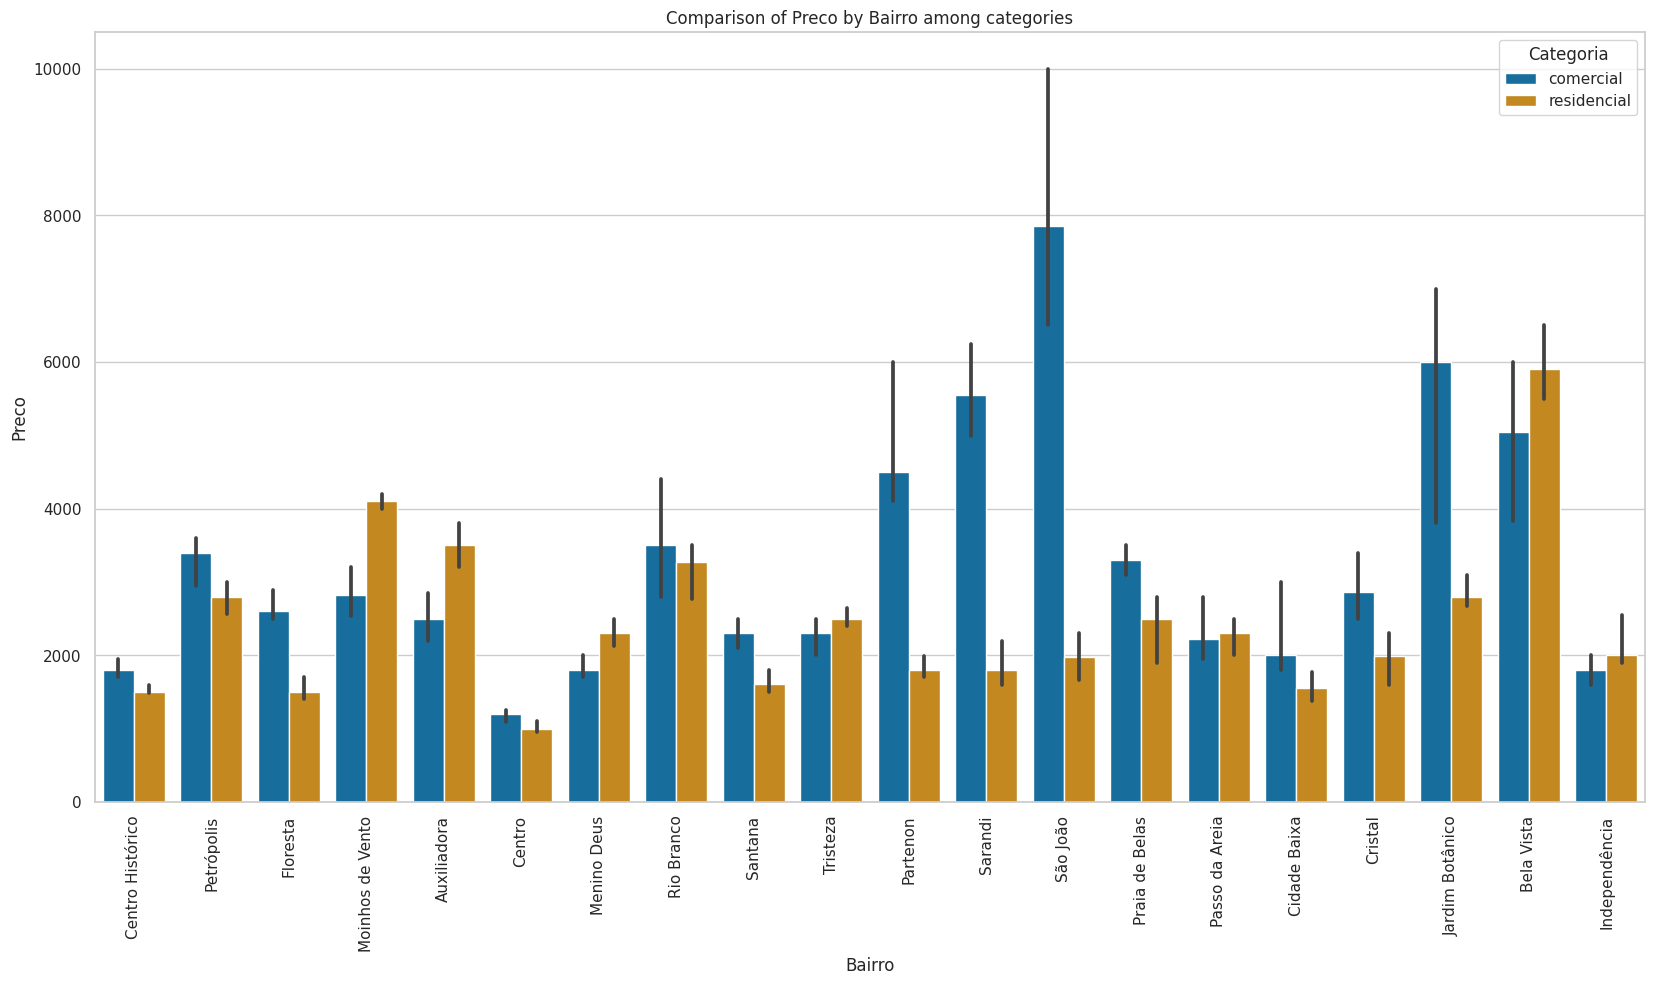

In [57]:
sns.set(style="whitegrid")
sns.set_palette("colorblind")

for column in DATAFRAME_VAR['categorical']:
    if column != 'ID' and column != 'Categoria' and column != 'Cidade':
        plt.figure(figsize=(20, 10))
        sns.barplot(data=df, x=column, y='Preco', hue='Categoria', order=df[column].value_counts().head(20).index, estimator=np.median)
        plt.xticks(rotation=90)
        plt.xlabel(column)
        plt.ylabel('Preco')
        plt.title(f'Comparison of Preco by {column} among categories')
        plt.show()


### Binary

/tmp/ipykernel_867752/555104432.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  amenities_df['Price'] = df['Preco']


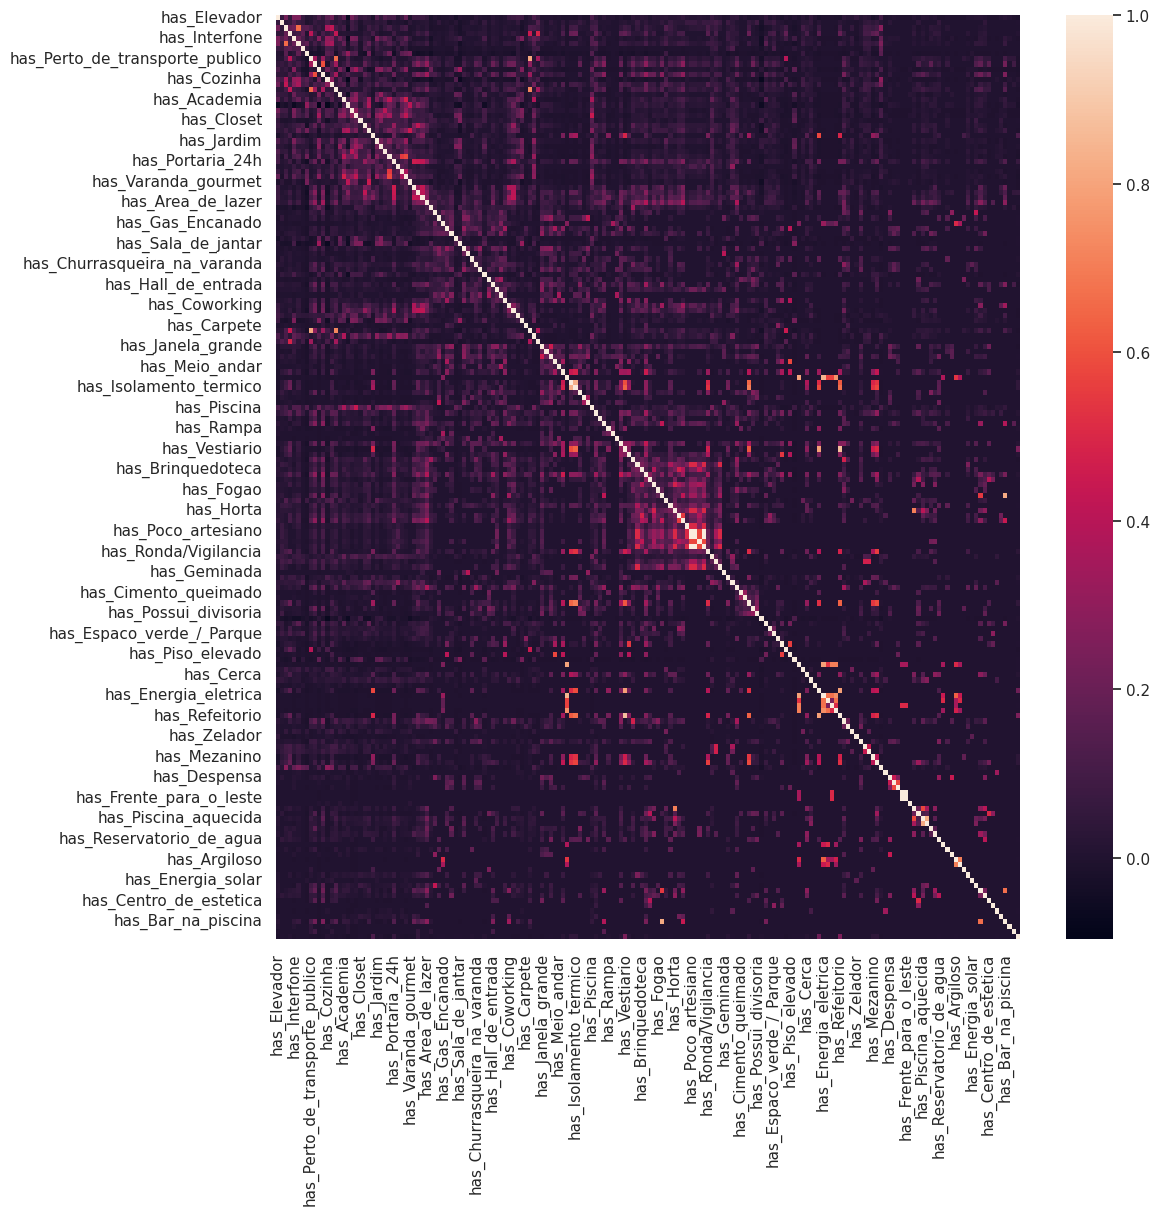

In [58]:
amenities_df['Price'] = df['Preco']
plt.figure(figsize=(12,12))
sns.heatmap(amenities_df.corr('pearson'))
plt.show()


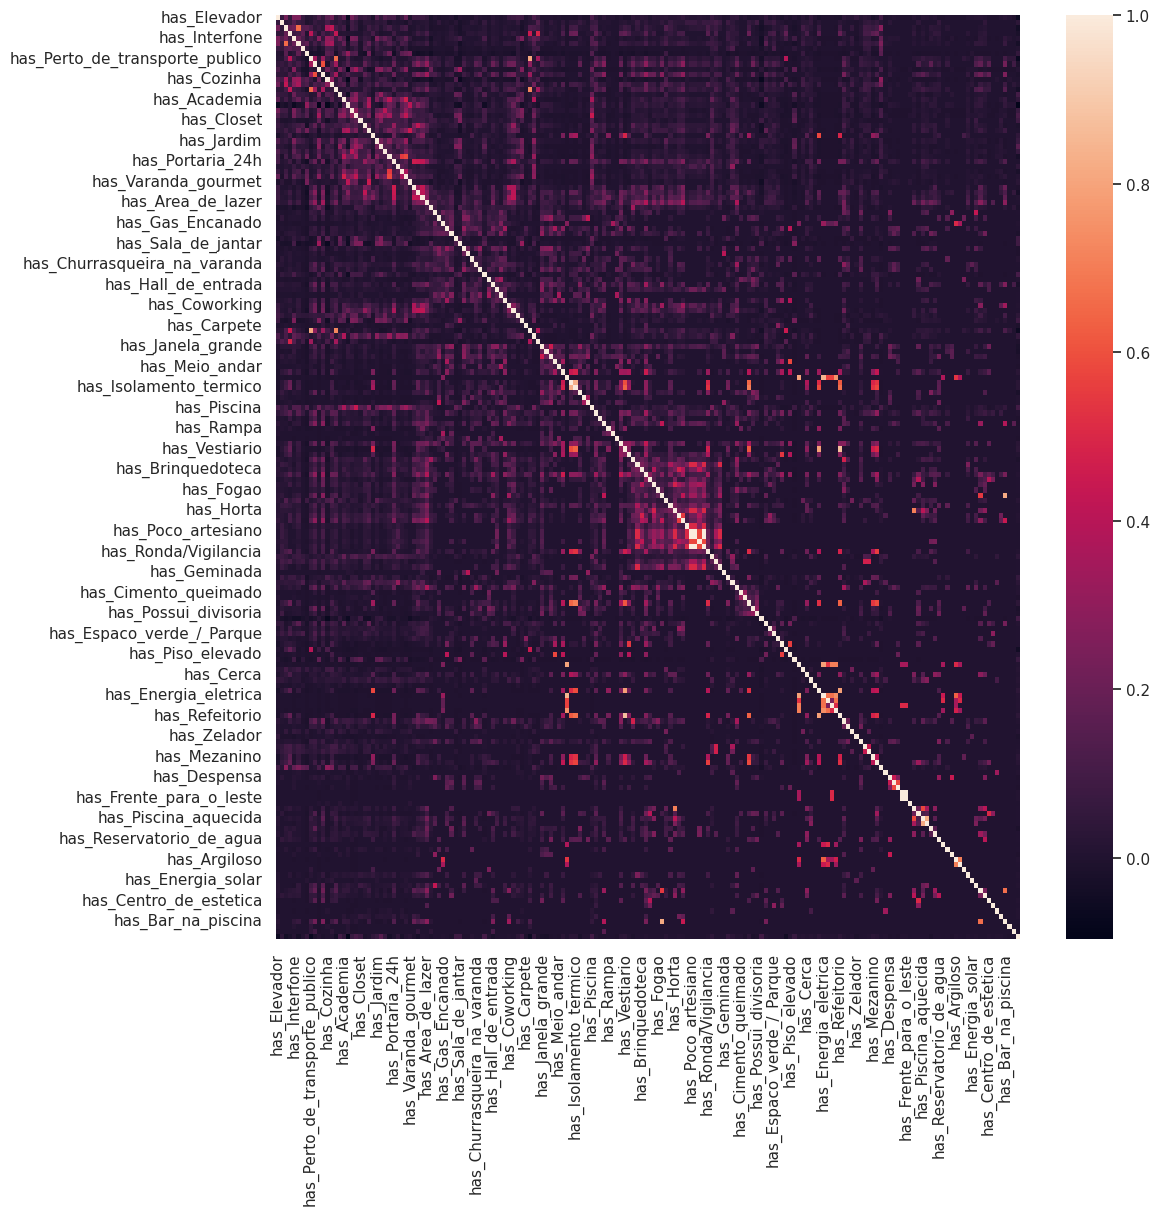

In [59]:
plt.figure(figsize=(12,12))
sns.heatmap(amenities_df.corr('kendall'))
plt.show()

In [60]:
amenities_df.drop(['Price'], axis=1, inplace=True)

# Feature Engineering

## Null values

Based on the analyses performed, strategies were defined to deal with the null values in the data set variables. For the variable "Car_Vacancies", it was decided to remove the records with null values. Regarding the variables "Size" and "Condominio", two types of imputation will be tested, a KNN and MICE. The null values for the variables "Rooms", "Bathrooms" and "HDI" were replaced with zero, and an additional column was created to indicate the existence of null values. For the "IPTU" variable, the median of the IPTU values for each type was used, replacing the null values by this corresponding median. These strategies were adopted considering the nature of the data and the context of the problem, aiming to minimize the impact of null values on the analyses performed.

## Encoding

For variables with 2 or less values we will use LabelEncoding, for variables with more values we will use one hot encoding.

## Amenities selection

In our analysis, we will employ the point-biserial correlation and Kendall's tau correlation measures to select the amenities that have a significant impact on the target variable. By considering these two correlation techniques, we aim to capture both linear and non-linear associations between the binary amenities and the target variable. However, it is important to acknowledge the limitations of using correlations solely with the target variable. Correlation measures do not account for potential confounding factors or interactions among features. Additionally, correlations only provide insights into the strength and direction of relationships, without establishing causality. Despite these limitations, due to limited hardware resources, correlation analysis serves as a computationally efficient approach to gain initial insights into feature importance and narrow down the set of amenities for further analysis and model development.

## Splitting the training and testing set

In [61]:
df_model = df.copy()
df_model = pd.concat([df_model,amenities_df], axis=1)

In [62]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30991 entries, 0 to 30990
Columns: 190 entries, ID to has_Garage_band
dtypes: float64(186), object(4)
memory usage: 44.9+ MB


In [63]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df_model.drop('Preco', axis=1),
                                                    df_model['Preco'],
                                                    test_size=0.2,
                                                    random_state=8)

In [64]:
X_train.shape

(24792, 189)

In [65]:
has_columns = [col for col in X_train.columns if col.startswith("has_")]
pearson_corr_top_15 = X_train[has_columns].corrwith(y_train).abs().sort_values(ascending= False).head(15)
kendall_corr_top_15 = X_train[has_columns].apply(lambda x: x.corr(y_train, method='kendall')).abs().sort_values(ascending= False).head(15)
top_15_columns = list(set(pearson_corr_top_15.index.tolist()) | set(kendall_corr_top_15.index.tolist()))


In [66]:
for col in has_columns: 
    if col not in top_15_columns: 
        X_train.drop(columns=col,inplace=True)
        X_test.drop(columns=col,inplace=True)


In [67]:
X_train.shape

(24792, 40)

In [68]:
X_test.shape

(6199, 40)

## Pipeline

### First level Pipeline

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin

class WithinGroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_var, add_indicator=True):
        self.group_var = group_var
        self.add_indicator = add_indicator
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_ = X.copy()
        missing_indicator_cols = []
        for col in X_.columns:
            if col != self.group_var and X_[col].dtypes == 'float64':
                missing_indicator_col = f"{col}_missing"
                missing_indicator_cols.append(missing_indicator_col)
                if self.add_indicator:
                    X_[missing_indicator_col] = X_[col].isna().astype(int)
                X_.loc[(X_[col].isna()) & X_[self.group_var].notna(), col] = X_.groupby(self.group_var)[col].transform('median')
                X_[col] = X_[col].fillna(X_.groupby(self.group_var)[col].transform('median'))
        X_ = X_.drop(columns=[self.group_var])
        if self.add_indicator:
            X_ = pd.concat([X_, X_[missing_indicator_cols]], axis=1)
        return X_



In [70]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder


remove_category_col = ColumnTransformer(transformers=[('drop_columns', 'drop', 'Categoria')],
                                 remainder='passthrough')

# ColumnTransformer with Box-Cox transformation
box_cox_transform = PowerTransformer('box-cox')

# Transform and scale target 
box_cox_transform_target = Pipeline([
    ('boxcox_transform', PowerTransformer('box-cox')),
    ('scaler', RobustScaler())
])

# ColumnTransformer for one-hot encoding
one_hot_encoding = OneHotEncoder(drop='if_binary', handle_unknown='ignore')

# ColumnTransformer with SimpleImputer
simple_imputer_IDH = SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)

simple_imputer_continuous = WithinGroupMedianImputer(group_var='Categoria', add_indicator=False)

simple_imputer_discrete = WithinGroupMedianImputer(group_var='Categoria', add_indicator=True)

scaler_robust = RobustScaler()

### Second level Pipeline

In [71]:
simple_continuous_pipeline_boxcox = Pipeline([
    ('imputation with median of each category', simple_imputer_continuous),
    ('box cox transform', box_cox_transform),
    ('robust scaler', scaler_robust)
])

In [72]:
simple_continuous_pipeline_no_boxcox = Pipeline([
    ('imputation with median of each category', simple_imputer_continuous),
    ('robust scaler', scaler_robust)
])

In [73]:
simple_discrete_pipeline = Pipeline([
    ('imputation with median of each category', simple_imputer_discrete),
    ('robust scaler', scaler_robust)
])

In [74]:
categorical_pipeline = Pipeline([
    ('one-hot encoding', one_hot_encoding)])

In [75]:
target_pipeline_with_boxcox = Pipeline([
    ('box cox transform', box_cox_transform),
    ('robust scaler', scaler_robust)
    ])

In [76]:
target_pipeline_no_boxcox = Pipeline([
    ('robust scaler', scaler_robust)
    ])

### Pipeline tericeiro nivel

In [77]:
simple_with_boxcox = ColumnTransformer([
    ('transforming continuous', simple_continuous_pipeline_boxcox, ['Condominio', 'IPTU', 'Tamanho','Categoria']),
    ('transforming discrete', simple_discrete_pipeline, ['Banheiros','Quartos', 'Vagas_carro','Categoria']),
    ('transforming categorical columns', categorical_pipeline, ['Categoria','Tipo', 'Bairro'] + top_15_columns),


],verbose_feature_names_out=True)

In [78]:
simple_with_no_boxcox = ColumnTransformer([
    ('transforming continuous', simple_continuous_pipeline_no_boxcox, ['Condominio', 'IPTU', 'Tamanho','Categoria']),
    ('transforming discrete', simple_discrete_pipeline, ['Banheiros','Quartos', 'Vagas_carro','Categoria']),
    ('transforming categorical columns', categorical_pipeline, ['Categoria','Tipo', 'Bairro'] + top_15_columns),


],verbose_feature_names_out=True)

In [79]:
X_train.columns

Index(['ID', 'Categoria', 'Tipo', 'Bairro', 'Condominio', 'IPTU', 'Quartos',
       'Banheiros', 'Vagas_carro', 'Tamanho', 'has_Varanda',
       'has_Aceita_animais', 'has_Ar-condicionado', 'has_Churrasqueira',
       'has_Closet', 'has_Estacionamento', 'has_Jardim', 'has_Lareira',
       'has_Portaria_24h', 'has_Portao_eletronico', 'has_Quintal',
       'has_Sala_de_jantar', 'has_Escritorio', 'has_Armario_embutido',
       'has_Estacionamento_para_visitantes', 'has_Isolamento_acustico',
       'has_Isolamento_termico', 'has_Piscina', 'has_Ambientes_integrados',
       'has_Vestiario', 'has_Sala_de_reuniao', 'has_Ronda/Vigilancia',
       'has_Deposito', 'has_Pe_direito_alto', 'has_Copa',
       'has_Mais_de_um_andar', 'has_Entrada_para_caminhoes', 'has_Refeitorio',
       'has_Mezanino', 'has_Restaurante'],
      dtype='object')

# Creating the model

The choice of regression models, such as Lasso, SVR, Gradient Boosting and RandomForest, along with linear regression as a control, is based on their distinct characteristics and abilities to handle null values and outliers. Linear regression is simple and widely used, while Lasso handles multicollinearity, reduces the impact of outliers, and promotes variable selection. SVR is robust to outliers and can handle complex patterns, Gradient Boosting is flexible and able to learn from residual errors, and RandomForest has the ability to handle nonlinearities and complex interactions.

In [80]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=8)))
models.append(('Lasso Regression', Lasso(alpha=1.0)))
models.append(('Support Vector Regressor', SVR()))
models.append(('Random Forest Regressor', RandomForestRegressor(random_state=8)))

In [81]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, cross_val_score

scores_results_simple_with_boxcox = {}
for model in models:
    kfold = KFold(n_splits=6, shuffle=True, random_state=8)
    final_pipeline = Pipeline([
        ('Feature transformations', simple_with_boxcox),
        ('Target transformation', TransformedTargetRegressor(regressor=model[1], transformer=target_pipeline_with_boxcox))
    ], verbose=True)
    medae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_median_absolute_error', n_jobs=-1, verbose=2, error_score='raise')
    mae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, error_score='raise')
    scores_results_simple_with_boxcox.setdefault(model[0], {})
    scores_results_simple_with_boxcox[model[0]]['MEDAE'] = medae_scores
    scores_results_simple_with_boxcox[model[0]]['MAE'] = mae_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.4s remaining:    1.4s
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10

[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.2s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s[CV] END .................................................... total time=   0.4s

[CV] END .................................................... total time=   0.4s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.2s
[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.8s remaining:    0.8s


[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.4s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.4s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.0s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.5s remaining:    2.5s


[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s
[CV] END .................................................... total time=   2.4s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.2s
[CV] END .................................................... total time=   2.4s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s
[CV] END .................................................... total time=   2.3s
[CV] 

/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.5s remaining:    2.5s
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10

[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.2s
[CV] END .................................................... total time=   2.5s
[CV] END .................................................... total time=   2.5s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[CV] END .................................................... total time=   0.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[CV] END .................................................... total time=   0.3s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[CV] END .................................................... total time=   0.3s
[Pipeli

/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10

[CV] END .................................................... total time=   0.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[CV] END .................................................... total time=   0.3s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[CV] END .................................................... total time=   0.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[CV] END .................................................... total time=   0.3s
[Pipeli

/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10

[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  18.9s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total=  19.5s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  19.9s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  19.9s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  19.8s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total=  20.9s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=  21.6s
[CV] END .................................................... total time=  22.2s
[CV] END .................................................... total time=  22.6s
[CV] END .................................................... total time=  22.5s
[CV] END .................................................... total time=  22.6s


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   22.6s remaining:   22.6s


[CV] END .................................................... total time=  23.5s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  20.1s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  20.3s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total=  20.7s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total=  21.5s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  22.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  22.1s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=  23.2s
[CV] END .................................................... total time=  23.2s
[CV] END .................................................... total time=  23.3s


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   23.3s remaining:   23.3s


[CV] END .................................................... total time=  24.3s
[CV] END .................................................... total time=  24.8s
[CV] END .................................................... total time=  24.9s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.4min
[CV] END .................................................... total time= 1.4min
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.4min
[CV] END .................................................... total time= 1.5min
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.5min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.5min remaining:  1.5min


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.5min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.5min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] END .................................................... total time= 1.5min
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.5min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.5min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.5min


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.5min remaining:  1.5min


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.5min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time= 1.5min
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.5min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.6min finished


In [82]:
scores_results_simple_with_no_boxcox = {}

In [83]:
kfold = KFold(n_splits=6, shuffle=True, random_state=8)
final_pipeline = Pipeline([
    ('Feature transformations', simple_with_boxcox),
    ('Target transformation', TransformedTargetRegressor(regressor=LinearRegression(), transformer=target_pipeline_no_boxcox))
], verbose=True)
medae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_median_absolute_error', n_jobs=-1, verbose=2, error_score='raise')
mae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, error_score='raise')

scores_results_simple_with_no_boxcox.setdefault('Linear Regression', {})
scores_results_simple_with_no_boxcox['Linear Regression']['MEDAE'] = medae_scores
scores_results_simple_with_no_boxcox['Linear Regression']['MAE'] = mae_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.4s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10

[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10

[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.4s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.2s
[CV] END .................................................... total time=   0.4s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.1s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s


In [84]:
kfold = KFold(n_splits=6, shuffle=True, random_state=8)
final_pipeline = Pipeline([
    ('Feature transformations', simple_with_boxcox),
    ('Target transformation', TransformedTargetRegressor(regressor=GradientBoostingRegressor(random_state=8), transformer=target_pipeline_no_boxcox))
], verbose=True)
medae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_median_absolute_error', n_jobs=-1, verbose=2, error_score='raise')
mae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, error_score='raise')

scores_results_simple_with_no_boxcox.setdefault('Gradient Boosting Regressor', {})
scores_results_simple_with_no_boxcox['Gradient Boosting Regressor']['MEDAE'] = medae_scores
scores_results_simple_with_no_boxcox['Gradient Boosting Regressor']['MAE'] = mae_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   1.9s
[CV] END .................................................... total time=   2.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.0s
[CV] END .................................................... total time=   2.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   1.9s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.4s remaining:    2.4s
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s
[CV] END .................................................... total time=   2.3s
[CV] END .................................................... total time=   2.4s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s

[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.0s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s
[CV] END .................................................... total time=   2.3s
[CV] 

/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.4s remaining:    2.4s
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10

[CV] END .................................................... total time=   2.4s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   2.1s
[CV] END .................................................... total time=   2.4s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.6s finished


In [85]:
kfold = KFold(n_splits=6, shuffle=True, random_state=8)
final_pipeline = Pipeline([
    ('Feature transformations', simple_with_boxcox),
    ('Target transformation', TransformedTargetRegressor(regressor=Lasso(alpha=1.0), transformer=target_pipeline_no_boxcox))
], verbose=True)
medae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_median_absolute_error', n_jobs=-1, verbose=2, error_score='raise')
mae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, error_score='raise')

scores_results_simple_with_no_boxcox.setdefault('Lasso Regression', {})
scores_results_simple_with_no_boxcox['Lasso Regression']['MEDAE'] = medae_scores
scores_results_simple_with_no_boxcox['Lasso Regression']['MAE'] = mae_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[CV] END .................................................... total time=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s


[CV] END .................................................... total time=   0.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[CV] END .................................................... total time=   0.3s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[CV] END .................................................... total time=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=   0.0s
[Pipeli

/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10

[CV] END .................................................... total time=   0.2s


In [86]:
kfold = KFold(n_splits=6, shuffle=True, random_state=8)
final_pipeline = Pipeline([
    ('Feature transformations', simple_with_boxcox),
    ('Target transformation', TransformedTargetRegressor(regressor=SVR(), transformer=target_pipeline_no_boxcox))
], verbose=True)
medae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_median_absolute_error', n_jobs=-1, verbose=2, error_score='raise')
mae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, error_score='raise')

scores_results_simple_with_no_boxcox.setdefault('Support Vector Regressor', {})
scores_results_simple_with_no_boxcox['Support Vector Regressor']['MEDAE'] = medae_scores
scores_results_simple_with_no_boxcox['Support Vector Regressor']['MAE'] = mae_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  18.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  18.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  18.3s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total=  19.1s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  19.2s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total=  19.4s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=  20.8s
[CV] END .................................................... total time=  20.9s
[CV] END .................................................... total time=  21.1s


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   21.2s remaining:   21.2s


[CV] END .................................................... total time=  21.6s
[CV] END .................................................... total time=  21.6s
[CV] END .................................................... total time=  22.0s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  18.3s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total=  18.8s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total=  19.3s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  19.5s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total=  20.3s


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time=  20.7s
[Pipeline]  (step 2 of 2) Processing Target transformation, total=  20.6s
[CV] END .................................................... total time=  21.3s
[CV] END .................................................... total time=  21.7s
[CV] END .................................................... total time=  22.0s


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   21.9s remaining:   21.9s


[CV] END .................................................... total time=  22.8s
[CV] END .................................................... total time=  23.1s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   23.3s finished


In [87]:
kfold = KFold(n_splits=6, shuffle=True, random_state=8)
final_pipeline = Pipeline([
    ('Feature transformations', simple_with_boxcox),
    ('Target transformation', TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=8), transformer=target_pipeline_no_boxcox))
], verbose=True)
medae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_median_absolute_error', n_jobs=-1, verbose=2, error_score='raise')
mae_scores = cross_val_score(final_pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, error_score='raise')

scores_results_simple_with_no_boxcox.setdefault('Random Forest Regressor', {})
scores_results_simple_with_no_boxcox['Random Forest Regressor']['MEDAE'] = medae_scores
scores_results_simple_with_no_boxcox['Random Forest Regressor']['MAE'] = mae_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.6min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.6min
[CV] END .................................................... total time= 1.6min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.6min
[CV] END .................................................... total time= 1.6min


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.6min remaining:  1.6min


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.6min
[CV] END .................................................... total time= 1.6min
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.6min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................................................... total time= 1.6min
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.6min
[CV] END .................................................... total time= 1.6min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 1 of 2) Processing Feature transformations, total=   0.2s
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.5min
[CV] END .................................................... total time= 1.5min
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.6min
[CV] END .................................................... total time= 1.6min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.6min
[CV] END .................................................... total time= 1.6min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.6min remaining:  1.6min


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.6min
[CV] END .................................................... total time= 1.6min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.7min
[Pipeline]  (step 2 of 2) Processing Target transformation, total= 1.7min
[CV] END .................................................... total time= 1.7min


/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.7min finished


[CV] END .................................................... total time= 1.7min


In [88]:
combined_dict = {}
for model, values in scores_results_simple_with_no_boxcox.items(): 
    combined_dict[model] = {'Without Box-cox': {'MAE': values['MAE'], 'MEDAE': values['MEDAE']}, 
                            'With Box-cox': {'MAE': scores_results_simple_with_boxcox[model]['MAE'], 'MEDAE': scores_results_simple_with_boxcox[model]['MEDAE']}}


In [89]:
# Create lists to store the data for plotting
model_name = []
mae_values = []
medae_values = []
boxcox_labels = []

# Iterate over the dictionary and extract the data
for model, pipelines in combined_dict.items():
    for pipeline, metrics in pipelines.items():
        model_name.extend([model] * len(metrics['MAE']))
        mae_values.extend(metrics['MAE'])
        medae_values.extend(metrics['MEDAE'])
        boxcox_labels.extend([pipeline] * len(metrics['MAE']))

In [90]:
df_scores = pd.DataFrame({'Model': model_name, 'MAE': mae_values, 'MEDAE': medae_values, 'Box-cox': boxcox_labels})

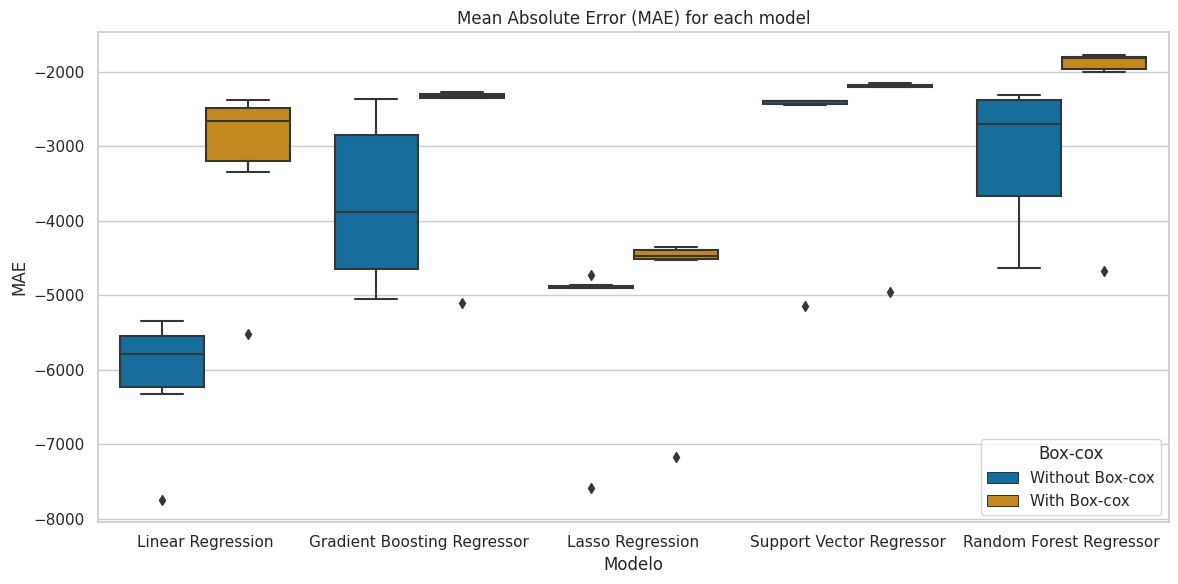

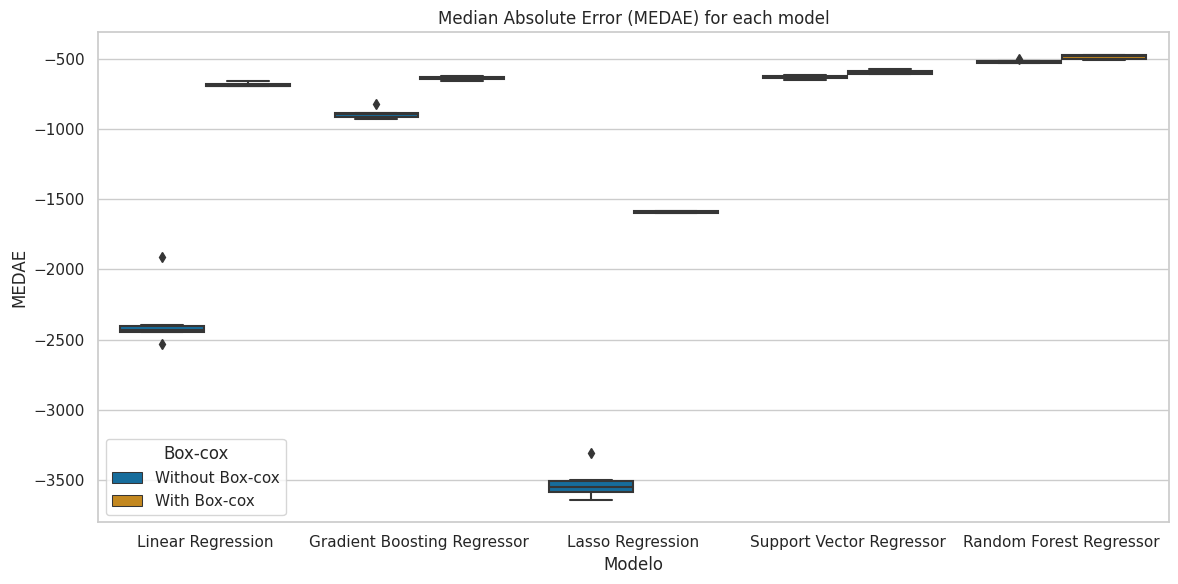

In [91]:
sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='MAE', hue='Box-cox', data=df_scores)
plt.title('Mean Absolute Error (MAE) for each model')
plt.xlabel('Modelo')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()

sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='MEDAE', hue='Box-cox', data=df_scores)
plt.title('Median Absolute Error (MEDAE) for each model')
plt.xlabel('Modelo')
plt.ylabel('MEDAE')
plt.tight_layout()
plt.show()

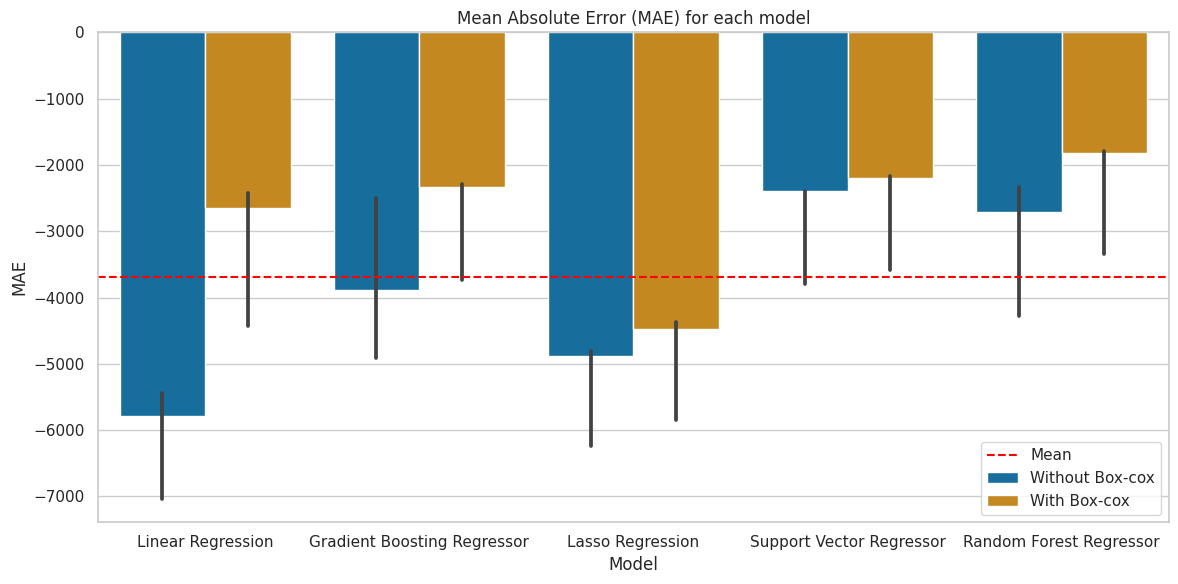

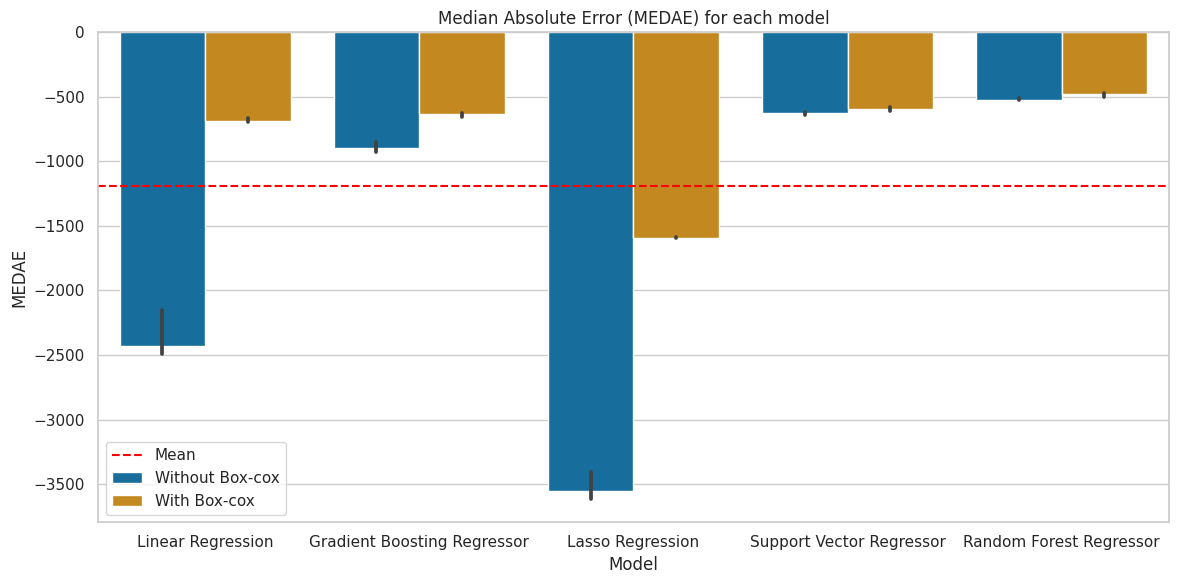

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MAE', hue='Box-cox', data=df_scores, estimator=np.median)
plt.axhline(y=df_scores['MAE'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Mean Absolute Error (MAE) for each model')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MEDAE', hue='Box-cox', data=df_scores, estimator=np.median)
plt.axhline(y=df_scores['MEDAE'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Median Absolute Error (MEDAE) for each model')
plt.xlabel('Model')
plt.ylabel('MEDAE')
plt.legend()
plt.tight_layout()
plt.show()


We can notice the difference between the two values in both errors, those treated with outliers have a smaller error. By the performance in the cross-validation and the analysis done, we will opt for the Random Forest and Gradient Boosting models for its small computational complexity and the boxcox pipeline.

## Hyperparameter optimization

In [93]:
param_grid_gb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 4, 8],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [94]:
def add_prefix_to_params(params, step_name):
    return {f'{step_name}__regressor__{key}': value for key, value in params.items()}

def remove_prefix_from_params(params, step_name):
    prefix_length = len(f'{step_name}__regressor__')
    return {key[prefix_length:]: value for key, value in params.items()}

/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


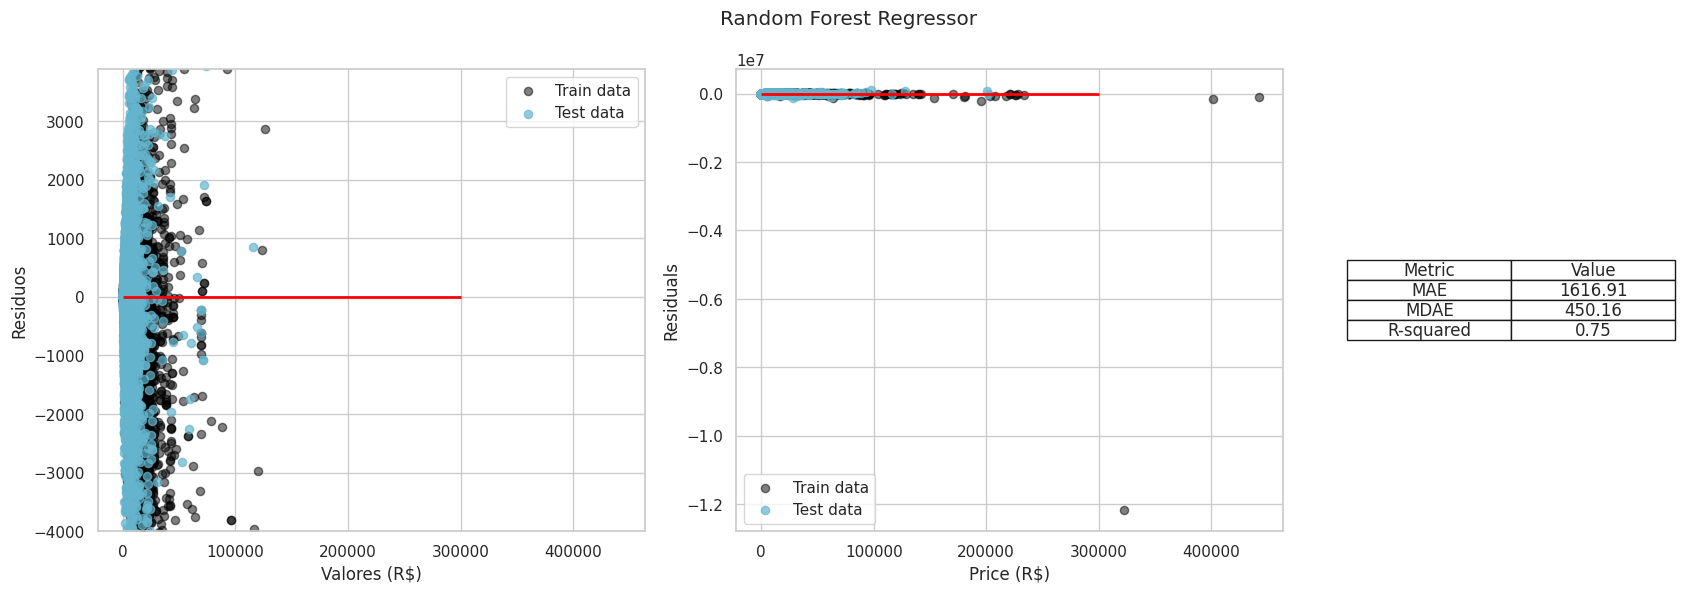

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

final_pipeline = Pipeline([
    ('Feature transformations', simple_with_boxcox),
    ('target_transformation', TransformedTargetRegressor(regressor=RandomForestRegressor(), transformer=target_pipeline_with_boxcox))
])
grid_search = GridSearchCV(final_pipeline,param_grid= add_prefix_to_params(param_grid_rf, 'target_transformation'), cv=kfold, scoring='neg_mean_absolute_error', n_jobs=6, verbose=2, error_score='raise', refit='neg_mean_absolute_error')
grid_search.fit(X_train,y_train)

grid_search = joblib.load('rf_regressor.pkl')

y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

train_residuals = y_pred_train - y_train
test_residuals = y_pred_test - y_test
margin = 10
train_iqr = np.percentile(train_residuals, 75) - np.percentile(train_residuals, 25)
test_iqr = np.percentile(test_residuals, 75) - np.percentile(test_residuals, 25)
y_min = min(np.percentile(train_residuals, 25), np.percentile(test_residuals, 25)) - margin * max(train_iqr, test_iqr)
y_max = max(np.percentile(train_residuals, 75), np.percentile(test_residuals, 75)) + margin * max(train_iqr, test_iqr)



# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, .5]})
# Calculate the IQR for train and test residuals
train_iqr = np.percentile(train_residuals, 75) - np.percentile(train_residuals, 25)
test_iqr = np.percentile(test_residuals, 75) - np.percentile(test_residuals, 25)

# Set the y-axis limits using the IQR
margin = 10  # Adjust this value to control the zoom level
y_min = np.percentile(train_residuals, 25) - margin * train_iqr
y_max = np.percentile(train_residuals, 75) + margin * train_iqr
# Plot with margin
ax1.scatter(y_pred_train, y_pred_train - y_train, c='black', marker='o', s=35, alpha=0.5, label='Train data')
ax1.scatter(y_pred_test, y_pred_test - y_test, c='c', marker='o', s=35, alpha=0.7, label='Test data')
ax1.set_xlabel('Valores (R$)')
ax1.set_ylabel('Residuos')
ax1.legend()
ax1.hlines(y=0, xmin=0, xmax=300000, lw=2, color='red')
ax1.set_ylim(y_min, y_max)  # Set the y-axis limits with margin

# Plot without margin
ax2.scatter(y_pred_train, y_pred_train - y_train, c='black', marker='o', s=35, alpha=0.5, label='Train data')
ax2.scatter(y_pred_test, y_pred_test - y_test, c='c', marker='o', s=35, alpha=0.7, label='Test data')
ax2.set_xlabel('Price (R$)')
ax2.set_ylabel('Residuals')
ax2.legend()
ax2.hlines(y=0, xmin=0, xmax=300000, lw=2, color='red')


mae_test = mean_absolute_error(y_test, y_pred_test)
mdae_test = median_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
data = {
    'Metric': ['MAE', 'MDAE', 'R-squared'],
    'Value': [round(mae_test,2), round(mdae_test,2), round(r2_test,2)]
}
scoreboard = pd.DataFrame(data)

ax3.axis('off')
table = ax3.table(cellText=scoreboard.values, colLabels=scoreboard.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.suptitle('Random Forest Regressor')

# Show the plots
plt.show()

/home/gian/.cache/pypoetry/virtualenvs/pricecalculator-HhG7AheB-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


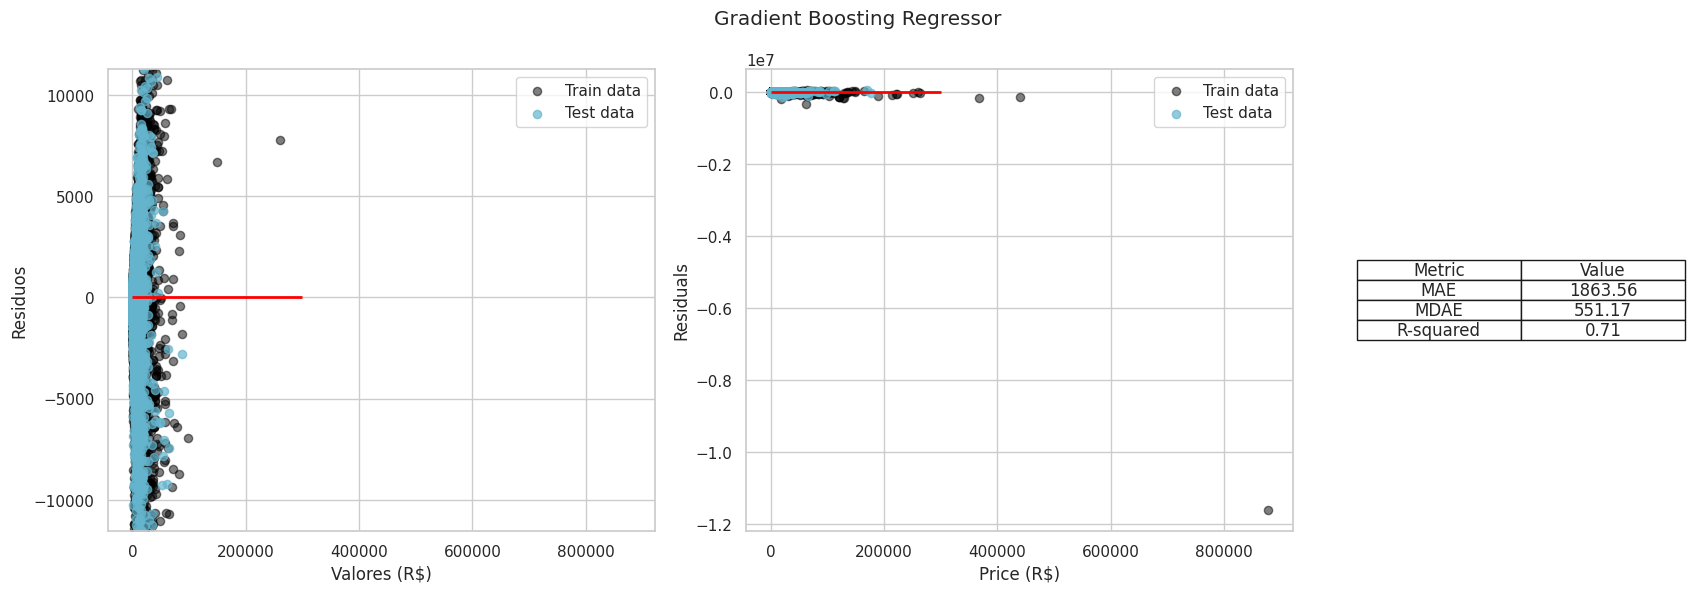

In [97]:
warnings.filterwarnings("ignore", category=UserWarning)

final_pipeline = Pipeline([
    ('Feature transformations', simple_with_boxcox),
    ('target_transformation', TransformedTargetRegressor(regressor=GradientBoostingRegressor(), transformer=target_pipeline_with_boxcox))
])
grid_search = GridSearchCV(final_pipeline,param_grid= add_prefix_to_params(param_grid_gb, 'target_transformation'), cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, error_score='raise', refit='neg_mean_absolute_error')
grid_search.fit(X_train,y_train)
grid_search = joblib.load('gb_regressor.pkl')

y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

train_residuals = y_pred_train - y_train
test_residuals = y_pred_test - y_test
margin = 10
train_iqr = np.percentile(train_residuals, 75) - np.percentile(train_residuals, 25)
test_iqr = np.percentile(test_residuals, 75) - np.percentile(test_residuals, 25)
y_min = min(np.percentile(train_residuals, 25), np.percentile(test_residuals, 25)) - margin * max(train_iqr, test_iqr)
y_max = max(np.percentile(train_residuals, 75), np.percentile(test_residuals, 75)) + margin * max(train_iqr, test_iqr)



# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, .5]})
# Calculate the IQR for train and test residuals
train_iqr = np.percentile(train_residuals, 75) - np.percentile(train_residuals, 25)
test_iqr = np.percentile(test_residuals, 75) - np.percentile(test_residuals, 25)

# Set the y-axis limits using the IQR
margin = 10  # Adjust this value to control the zoom level
y_min = np.percentile(train_residuals, 25) - margin * train_iqr
y_max = np.percentile(train_residuals, 75) + margin * train_iqr
# Plot with margin
ax1.scatter(y_pred_train, y_pred_train - y_train, c='black', marker='o', s=35, alpha=0.5, label='Train data')
ax1.scatter(y_pred_test, y_pred_test - y_test, c='c', marker='o', s=35, alpha=0.7, label='Test data')
ax1.set_xlabel('Valores (R$)')
ax1.set_ylabel('Residuos')
ax1.legend()
ax1.hlines(y=0, xmin=0, xmax=300000, lw=2, color='red')
ax1.set_ylim(y_min, y_max)  # Set the y-axis limits with margin

# Plot without margin
ax2.scatter(y_pred_train, y_pred_train - y_train, c='black', marker='o', s=35, alpha=0.5, label='Train data')
ax2.scatter(y_pred_test, y_pred_test - y_test, c='c', marker='o', s=35, alpha=0.7, label='Test data')
ax2.set_xlabel('Price (R$)')
ax2.set_ylabel('Residuals')
ax2.legend()
ax2.hlines(y=0, xmin=0, xmax=300000, lw=2, color='red')


mae_test = mean_absolute_error(y_test, y_pred_test)
mdae_test = median_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
data = {
    'Metric': ['MAE', 'MDAE', 'R-squared'],
    'Value': [round(mae_test,2), round(mdae_test,2), round(r2_test,2)]
}
scoreboard = pd.DataFrame(data)

ax3.axis('off')
table = ax3.table(cellText=scoreboard.values, colLabels=scoreboard.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.suptitle('Gradient Boosting Regressor')

# Show the plots
plt.show()